# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import sklearn
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA

from sklearn.cluster import KMeans
# magic word for producing visualizations in notebook
%matplotlib inline

pd.options.display.max_rows = None
pd.options.display.max_columns = None

import warnings

# Suppress warnings
with warnings.catch_warnings():
    warnings.simplefilter("ignore")

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [2]:
# Load in the general demographics data.
AZDIAS_data = pd.read_csv('Udacity_AZDIAS_Subset.csv',sep=";")
# Load in the feature summary file.
feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv',sep=";")

In [3]:
feat_info

attribute information_level         type missing_or_unknown
0                AGER_TYP            person  categorical             [-1,0]
1    ALTERSKATEGORIE_GROB            person      ordinal           [-1,0,9]
2               ANREDE_KZ            person  categorical             [-1,0]
3           CJT_GESAMTTYP            person  categorical                [0]
4       FINANZ_MINIMALIST            person      ordinal               [-1]
5           FINANZ_SPARER            person      ordinal               [-1]
6        FINANZ_VORSORGER            person      ordinal               [-1]
7          FINANZ_ANLEGER            person      ordinal               [-1]
8   FINANZ_UNAUFFAELLIGER            person      ordinal               [-1]
9        FINANZ_HAUSBAUER            person      ordinal               [-1]
10              FINANZTYP            person  categorical               [-1]
11            GEBURTSJAHR            person      numeric                [0]
12        GFK_URLAUBERTYP            person  categorical                 []
13       GREEN_AVANTGARDE            person  categorical                 []
14             HEALTH_TYP            person      ordinal             [-1,0]
15    LP_LEBENSPHASE_FEIN            person        mixed                [0]
16    LP_LEBENSPHASE_GROB            person        mixed                [0]
17        LP_FAMILIE_FEIN            person  categorical                [0]
18        LP_FAMILIE_GROB            person  categorical                [0]
19         LP_STATUS_FEIN            person  categorical                [0]
20         LP_STATUS_GROB            person  categorical                [0]
21       NATIONALITAET_KZ            person  categorical             [-1,0]
22  PRAEGENDE_JUGENDJAHRE            person        mixed             [-1,0]
23         RETOURTYP_BK_S            person      ordinal                [0]
24              SEMIO_SOZ            person      ordinal             [-1,9]
25              SEMIO_FAM            person      ordinal             [-1,9]
26              SEMIO_REL            person      ordinal             [-1,9]
27              SEMIO_MAT            person      ordinal             [-1,9]
28             SEMIO_VERT            person      ordinal             [-1,9]
29             SEMIO_LUST            person      ordinal             [-1,9]
30              SEMIO_ERL            person      ordinal             [-1,9]
31             SEMIO_KULT            person      ordinal             [-1,9]
32              SEMIO_RAT            person      ordinal             [-1,9]
33             SEMIO_KRIT            person      ordinal             [-1,9]
34              SEMIO_DOM            person      ordinal             [-1,9]
35             SEMIO_KAEM            person      ordinal             [-1,9]
36          SEMIO_PFLICHT            person      ordinal             [-1,9]
37            SEMIO_TRADV            person      ordinal             [-1,9]
38            SHOPPER_TYP            person  categorical               [-1]
39                SOHO_KZ            person  categorical               [-1]
40               TITEL_KZ            person  categorical             [-1,0]
41               VERS_TYP            person  categorical               [-1]
42               ZABEOTYP            person  categorical             [-1,9]
43               ALTER_HH         household     interval                [0]
44           ANZ_PERSONEN         household      numeric                 []
45              ANZ_TITEL         household      numeric                 []
46     HH_EINKOMMEN_SCORE         household      ordinal             [-1,0]
47           KK_KUNDENTYP         household  categorical               [-1]
48         W_KEIT_KIND_HH         household      ordinal             [-1,0]
49         WOHNDAUER_2008         household      ordinal             [-1,0]
50    ANZ_HAUSHALTE_AKTIV          building      numeric                [0]
51           ANZ_HH_TITEL          building      numeric        

In [72]:
# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).
AZDIAS_data.shape

(891221, 85)

In [5]:
AZDIAS_data.head()

AGER_TYP  ALTERSKATEGORIE_GROB  ANREDE_KZ  CJT_GESAMTTYP  \
0        -1                     2          1            2.0   
1        -1                     1          2            5.0   
2        -1                     3          2            3.0   
3         2                     4          2            2.0   
4        -1                     3          1            5.0   

   FINANZ_MINIMALIST  FINANZ_SPARER  FINANZ_VORSORGER  FINANZ_ANLEGER  \
0                  3              4                 3               5   
1                  1              5                 2               5   
2                  1              4                 1               2   
3                  4              2                 5               2   
4                  4              3                 4               1   

   FINANZ_UNAUFFAELLIGER  FINANZ_HAUSBAUER  FINANZTYP  GEBURTSJAHR  \
0                      5                 3          4            0   
1                      4                 5          1         1996   
2                      3                 5          1         1979   
3                      1                 2          6         1957   
4                      3                 2          5         1963   

   GFK_URLAUBERTYP  GREEN_AVANTGARDE  HEALTH_TYP  LP_LEBENSPHASE_FEIN  \
0             10.0                 0          -1                 15.0   
1             10.0                 0           3                 21.0   
2             10.0                 1           3                  3.0   
3              1.0                 0           2                  0.0   
4              5.0                 0           3                 32.0   

   LP_LEBENSPHASE_GROB  LP_FAMILIE_FEIN  LP_FAMILIE_GROB  LP_STATUS_FEIN  \
0                  4.0              2.0              2.0             1.0   
1                  6.0              5.0              3.0             2.0   
2                  1.0              1.0              1.0             3.0   
3                  0.0              0.0              0.0             9.0   
4                 10.0             10.0              5.0             3.0   

   LP_STATUS_GROB  NATIONALITAET_KZ  PRAEGENDE_JUGENDJAHRE  RETOURTYP_BK_S  \
0             1.0                 0                      0             5.0   
1             1.0                 1                     14             1.0   
2             2.0                 1                     15             3.0   
3             4.0                 1                      8             2.0   
4             2.0                 1                      8             5.0   

   SEMIO_SOZ  SEMIO_FAM  SEMIO_REL  SEMIO_MAT  SEMIO_VERT  SEMIO_LUST  \
0          2          6          7          5           1           5   
1          5          4          4          3           1           2   
2          4          1          3          3           4           4   
3          5          1          2          1           4           4   
4          6          4          4          2           7           4   

   SEMIO_ERL  SEMIO_KULT  SEMIO_RAT  SEMIO_KRIT  SEMIO_DOM  SEMIO_KAEM  \
0          3           3          4           7          6           6   
1          2           3          6           4          7           4   
2          6           3          4           7          7           7   
3          7           4          3           4          4           5   
4          4           6          2           3          2           2   

   SEMIO_PFLICHT  SEMIO_TRADV  SHOPPER_TYP  SOHO_KZ  TITEL_KZ  VERS_TYP  \
0              5            3           -1      NaN       NaN        -1   
1              7            6            3      1.0       0.0         2   
2              3            3            2      0.0       0.0         1   
3              4            4            1      0.0       0.0         1   
4              4            2            2      0.0       0.0         2   

   ZABEOTYP  ALTER_HH  ANZ_PERSONEN  ANZ_TITEL  HH_EINKOMMEN_SCO

In [6]:
AZDIAS_data.describe()

AGER_TYP  ALTERSKATEGORIE_GROB      ANREDE_KZ  CJT_GESAMTTYP  \
count  891221.000000         891221.000000  891221.000000  886367.000000   
mean       -0.358435              2.777398       1.522098       3.632838   
std         1.198724              1.068775       0.499512       1.595021   
min        -1.000000              1.000000       1.000000       1.000000   
25%        -1.000000              2.000000       1.000000       2.000000   
50%        -1.000000              3.000000       2.000000       4.000000   
75%        -1.000000              4.000000       2.000000       5.000000   
max         3.000000              9.000000       2.000000       6.000000   

       FINANZ_MINIMALIST  FINANZ_SPARER  FINANZ_VORSORGER  FINANZ_ANLEGER  \
count      891221.000000  891221.000000     891221.000000   891221.000000   
mean            3.074528       2.821039          3.401106        3.033328   
std             1.321055       1.464749          1.322134        1.529603   
min             1.000000       1.000000          1.000000        1.000000   
25%             2.000000       1.000000          3.000000        2.000000   
50%             3.000000       3.000000          3.000000        3.000000   
75%             4.000000       4.000000          5.000000        5.000000   
max             5.000000       5.000000          5.000000        5.000000   

       FINANZ_UNAUFFAELLIGER  FINANZ_HAUSBAUER      FINANZTYP    GEBURTSJAHR  \
count          891221.000000     891221.000000  891221.000000  891221.000000   
mean                2.874167          3.075121       3.790586    1101.178533   
std                 1.486731          1.353248       1.987876     976.583551   
min                 1.000000          1.000000       1.000000       0.000000   
25%                 2.000000          2.000000       2.000000       0.000000   
50%                 3.000000          3.000000       4.000000    1943.000000   
75%                 4.000000          4.000000       6.000000    1970.000000   
max                 5.000000          5.000000       6.000000    2017.000000   

       GFK_URLAUBERTYP  GREEN_AVANTGARDE     HEALTH_TYP  LP_LEBENSPHASE_FEIN  \
count    886367.000000     891221.000000  891221.000000        886367.000000   
mean          7.350304          0.196612       1.792102            14.622637   
std           3.525723          0.397437       1.269062            12.616883   
min           1.000000          0.000000      -1.000000             0.000000   
25%           5.000000          0.000000       1.000000             4.000000   
50%           8.000000          0.000000       2.000000            11.000000   
75%          10.000000          0.000000       3.000000            27.000000   
max          12.000000          1.000000       3.000000            40.000000   

       LP_LEBENSPHASE_GROB  LP_FAMILIE_FEIN  LP_FAMILIE_GROB  LP_STATUS_FEIN  \
count        886367.000000    886367.000000    886367.000000   886367.000000   
mean              4.453621         3.599574         2.185966        4.791151   
std               3.855639         3.926486         1.756537        3.425305   
min               0.000000         0.000000         0.000000        1.000000   
25%               1.000000         1.000000         1.000000        2.000000   
50%               3.000000         1.000000         1.000000        4.000000   
75%               8.000000         8.000000         4.000000        9.000000   
max              12.000000        11.000000         5.000000       10.000000   

       LP_STATUS_GROB  NATIONALITAET_KZ  PRAEGENDE_JUGENDJAHRE  \
count   886367.000000     891221.000000          891221.000000   
mean         2.432575          1.026827               8.154346   
std          1.474315          0.586634               4.844532   
min          1.000000          0.000000               0.000000   
25%          1.000000          1.000000               5.000000   
50%          2.000000          1.000000               8.000000   
75%     

In [7]:
AZDIAS_data.isna().sum()

AGER_TYP                      0
ALTERSKATEGORIE_GROB          0
ANREDE_KZ                     0
CJT_GESAMTTYP              4854
FINANZ_MINIMALIST             0
FINANZ_SPARER                 0
FINANZ_VORSORGER              0
FINANZ_ANLEGER                0
FINANZ_UNAUFFAELLIGER         0
FINANZ_HAUSBAUER              0
FINANZTYP                     0
GEBURTSJAHR                   0
GFK_URLAUBERTYP            4854
GREEN_AVANTGARDE              0
HEALTH_TYP                    0
LP_LEBENSPHASE_FEIN        4854
LP_LEBENSPHASE_GROB        4854
LP_FAMILIE_FEIN            4854
LP_FAMILIE_GROB            4854
LP_STATUS_FEIN             4854
LP_STATUS_GROB             4854
NATIONALITAET_KZ              0
PRAEGENDE_JUGENDJAHRE         0
RETOURTYP_BK_S             4854
SEMIO_SOZ                     0
SEMIO_FAM                     0
SEMIO_REL                     0
SEMIO_MAT                     0
SEMIO_VERT                    0
SEMIO_LUST                    0
SEMIO_ERL                     0
SEMIO_KU

> **Tip**: Add additional cells to keep everything in reasonably-sized chunks! Keyboard shortcut `esc --> a` (press escape to enter command mode, then press the 'A' key) adds a new cell before the active cell, and `esc --> b` adds a new cell after the active cell. If you need to convert an active cell to a markdown cell, use `esc --> m` and to convert to a code cell, use `esc --> y`. 

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

In [8]:
# Identify missing or unknown data values and convert them to NaNs.
# test one feature
AZDIAS_data.CAMEO_INTL_2015.isnull().sum()

98979

In [9]:
m=feat_info[feat_info['attribute']=='CAMEO_INTL_2015']['missing_or_unknown'].iloc[0].replace('[','').replace(']','').split(',')
m1 =[int(item) if item.lstrip('-').isdigit() else item for item in m]
m1

[-1, 'XX']

In [10]:
AZDIAS_data['CAMEO_INTL_2015'] = AZDIAS_data['CAMEO_INTL_2015'].replace(m1,np.nan)

In [11]:
AZDIAS_data.CAMEO_INTL_2015.isnull().sum()

99352

In [4]:
# Identify missing or unknown data values and convert them to NaNs.
#Apply to all features
for feature in feat_info['attribute']:
    string_to_list=feat_info[feat_info['attribute']==feature]['missing_or_unknown'].iloc[0].replace('[','').replace(']','').split(',')
    values =[int(item) if item.lstrip('-').isdigit() else item for item in string_to_list]
    
    AZDIAS_data[feature].replace(to_replace=values,
                      value=np.nan, inplace=True)

#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

In [13]:
AZDIAS_data.shape

(891221, 85)

In [14]:
# Perform an assessment of how much missing data there is in each column of the
# dataset.
AZDIAS_data.isnull().sum().sort_values(ascending=False)

TITEL_KZ                 889061
AGER_TYP                 685843
KK_KUNDENTYP             584612
KBA05_BAUMAX             476524
GEBURTSJAHR              392318
ALTER_HH                 310267
KKK                      158064
REGIOTYP                 158064
W_KEIT_KIND_HH           147988
KBA05_ANTG1              133324
KBA05_ANTG2              133324
KBA05_ANTG3              133324
KBA05_ANTG4              133324
KBA05_GBZ                133324
MOBI_REGIO               133324
PLZ8_ANTG3               116515
PLZ8_ANTG2               116515
PLZ8_GBZ                 116515
PLZ8_HHZ                 116515
PLZ8_ANTG1               116515
PLZ8_BAUMAX              116515
PLZ8_ANTG4               116515
VERS_TYP                 111196
HEALTH_TYP               111196
SHOPPER_TYP              111196
NATIONALITAET_KZ         108315
PRAEGENDE_JUGENDJAHRE    108164
KBA13_ANZAHL_PKW         105800
ANZ_HAUSHALTE_AKTIV       99611
CAMEO_INTL_2015           99352
CAMEO_DEU_2015            99352
CAMEO_DE

In [5]:
# Investigate patterns in the amount of missing data in each column.
missing_percentage_per_feature = round (AZDIAS_data.isnull().mean(),2)

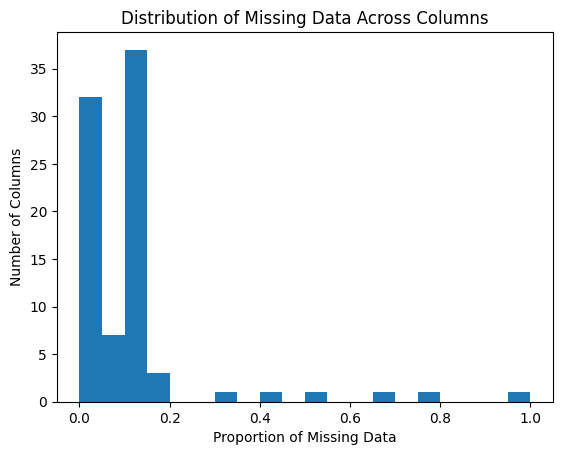

In [16]:
# vizualize missing data percentage
missing_percentage_per_feature.plot(kind='hist', bins=20)
plt.xlabel('Proportion of Missing Data')
plt.ylabel('Number of Columns')
plt.title('Distribution of Missing Data Across Columns')
plt.show()

In [6]:
# Remove the outlier_ columns from the dataset. (You'll perform other data
# engineering tasks such as re-encoding and imputation later.)
threshold = 0.5
outlier_columns = missing_percentage_per_feature[missing_percentage_per_feature > threshold].index
print(f'outlier_columns: {outlier_columns}')

outlier_columns: Index(['AGER_TYP', 'TITEL_KZ', 'KK_KUNDENTYP', 'KBA05_BAUMAX'], dtype='object')


In [7]:
AZDIAS_data_no_outlier = AZDIAS_data.drop(columns = outlier_columns,axis = 1)

In [77]:
AZDIAS_data_no_outlier.shape

(891221, 81)

#### Discussion 1.1.2: Assess Missing Data in Each Column

(Double click this cell and replace this text with your own text, reporting your observations regarding the amount of missing data in each column. Are there any patterns in missing values? Which columns were removed from the dataset?)

### Answer 1.1.2 : 
In general, most of the columns have a reasonable amounts of missing data taking into consadration that these data is real data. However, there are few columns have percentage of missing data more than 50% of the values which is could be considered as outlier unless there is a reason of having that amount of missing values, but here, we will remove these 4 columns which are:
['AGER_TYP', 
'TITEL_KZ', 
'KK_KUNDENTYP', 
'KBA05_BAUMAX']

#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

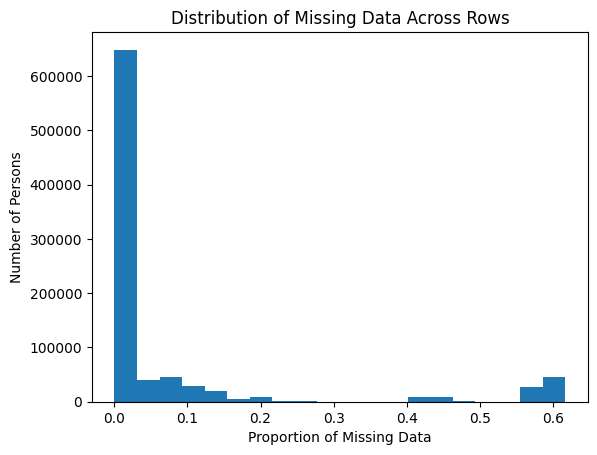

In [8]:
# How much data is missing in each row of the dataset?
missing_percentage_per_row = AZDIAS_data_no_outlier.isnull().mean(axis=1)
# vizualize missing data percentage
missing_percentage_per_row.plot(kind='hist', bins=20)
plt.xlabel('Proportion of Missing Data')
plt.ylabel('Number of Persons')
plt.title('Distribution of Missing Data Across Rows')
plt.show()

In [20]:
# Write code to divide the data into two subsets based on the number of missing
# values in each row.
threshold = 0.3
above_threshold=AZDIAS_data_no_outlier[missing_percentage_per_row >= threshold]
below_threshold=AZDIAS_data_no_outlier[missing_percentage_per_row < threshold]

In [21]:
# Compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.
columns_with_no_missing = missing_percentage_per_feature[missing_percentage_per_feature ==0].index
print(f'columns_with_no_missing_data: {columns_with_no_missing}')

columns_with_no_missing_data: Index(['ALTERSKATEGORIE_GROB', 'ANREDE_KZ', 'FINANZ_MINIMALIST',
       'FINANZ_SPARER', 'FINANZ_VORSORGER', 'FINANZ_ANLEGER',
       'FINANZ_UNAUFFAELLIGER', 'FINANZ_HAUSBAUER', 'FINANZTYP',
       'GREEN_AVANTGARDE', 'SEMIO_SOZ', 'SEMIO_FAM', 'SEMIO_REL', 'SEMIO_MAT',
       'SEMIO_VERT', 'SEMIO_LUST', 'SEMIO_ERL', 'SEMIO_KULT', 'SEMIO_RAT',
       'SEMIO_KRIT', 'SEMIO_DOM', 'SEMIO_KAEM', 'SEMIO_PFLICHT', 'SEMIO_TRADV',
       'ZABEOTYP'],
      dtype='object')


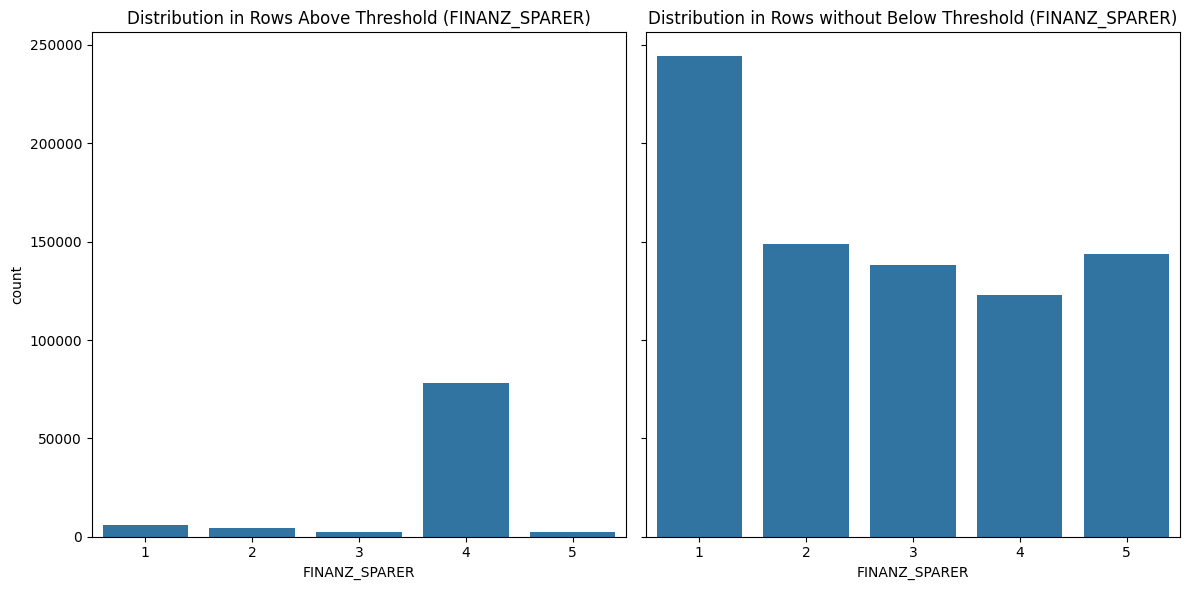

In [23]:
# Test for one column
column_name = 'FINANZ_SPARER'
fig, axes = plt.subplots(1, 2, figsize=(12, 6), sharey=True)

sns.countplot(x='FINANZ_SPARER', data=above_threshold, ax=axes[0])
axes[0].set_title(f'Distribution in Rows Above Threshold ({column_name})')

sns.countplot(x='FINANZ_SPARER', data=below_threshold, ax=axes[1])
axes[1].set_title(f'Distribution in Rows without Below Threshold ({column_name})')

plt.tight_layout()
plt.show()

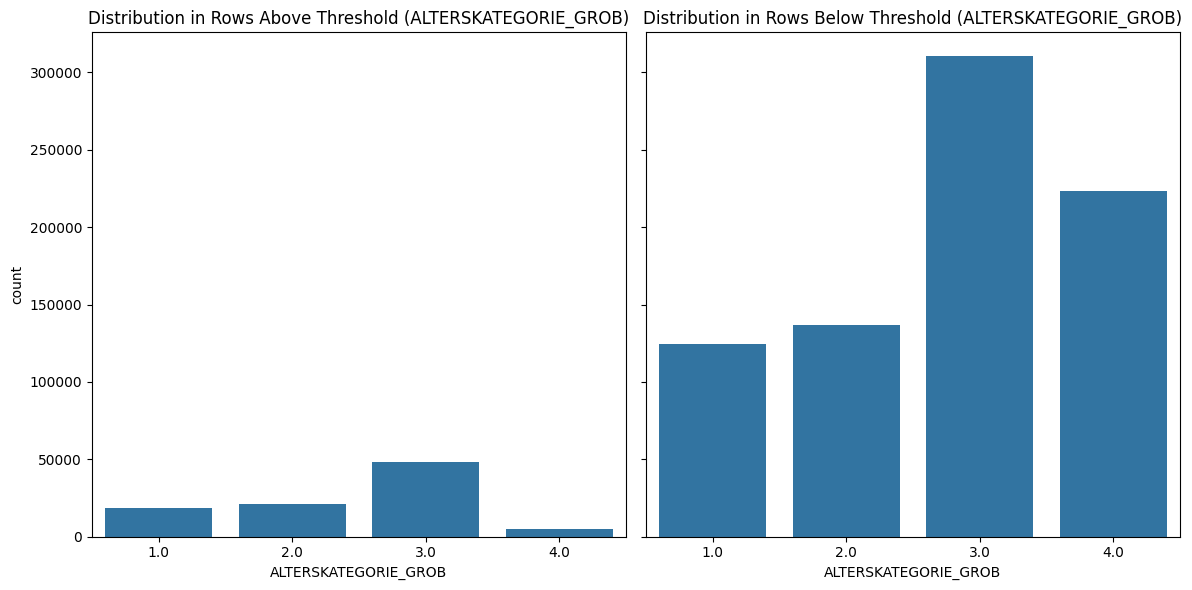

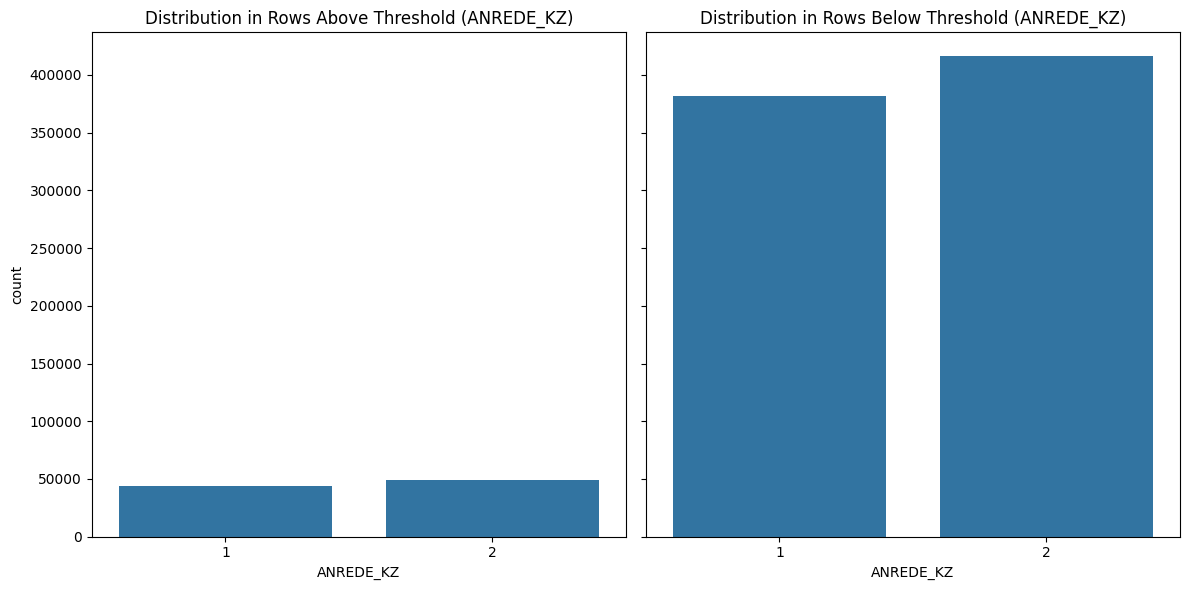

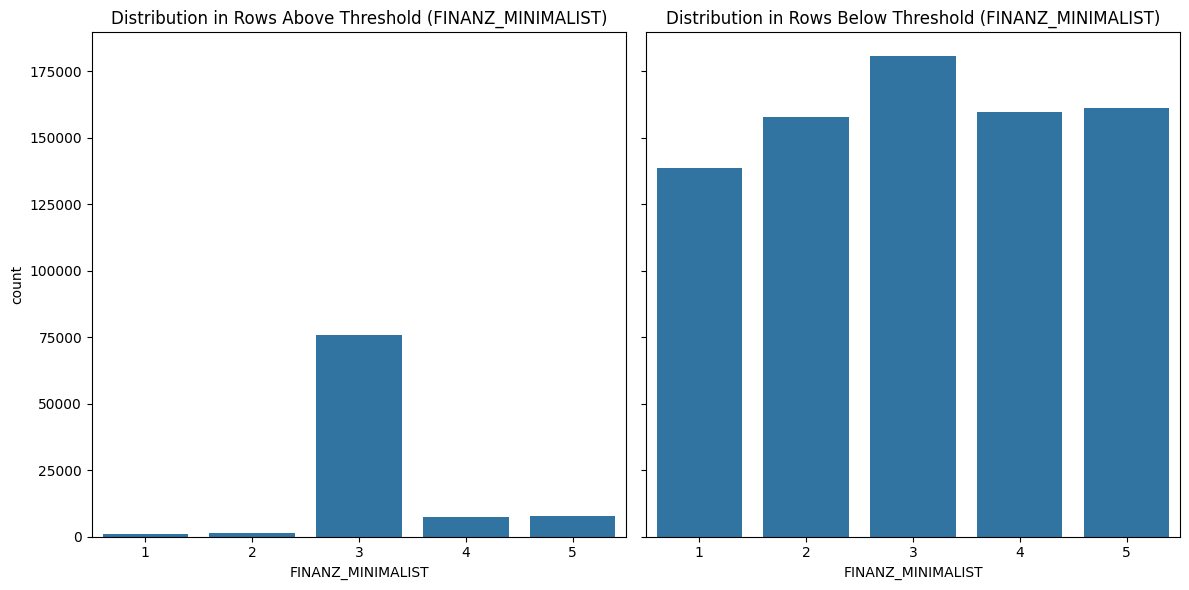

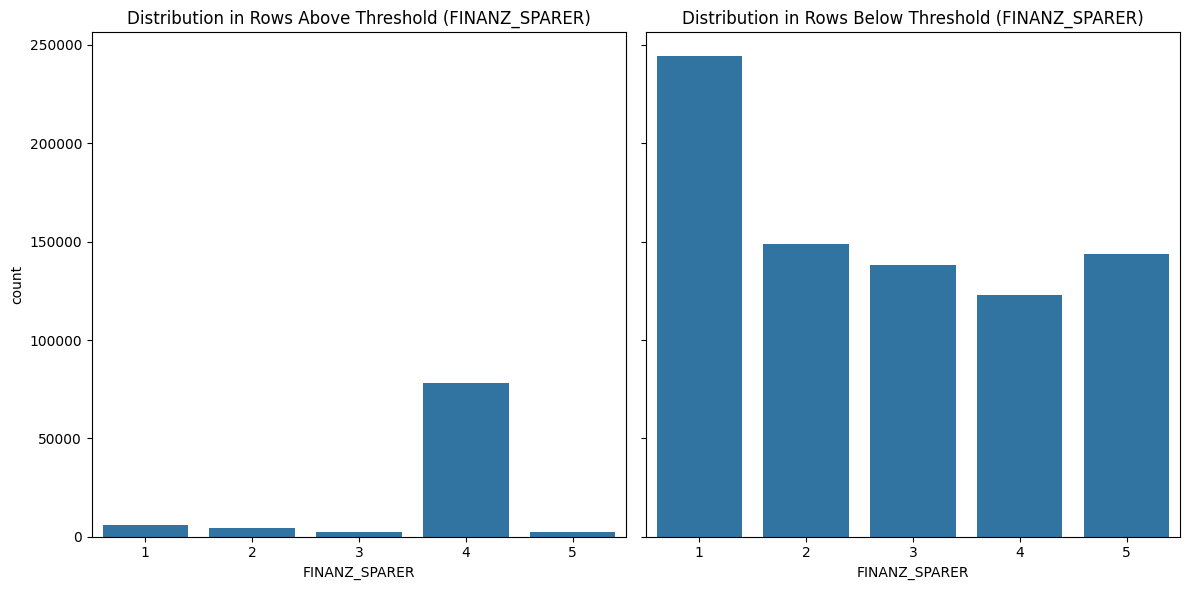

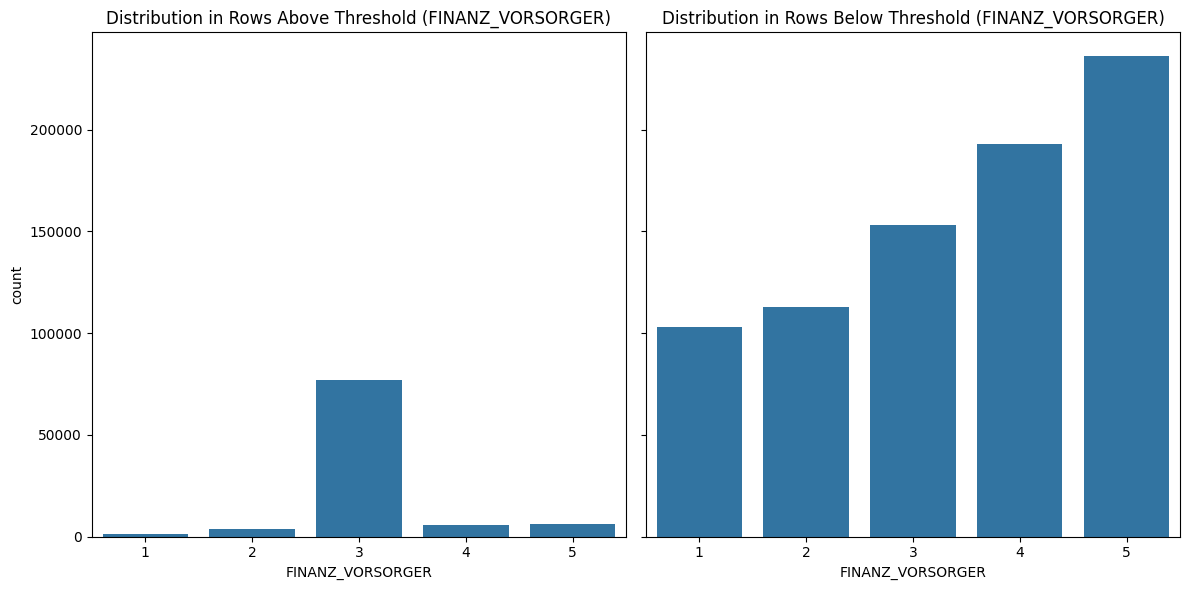

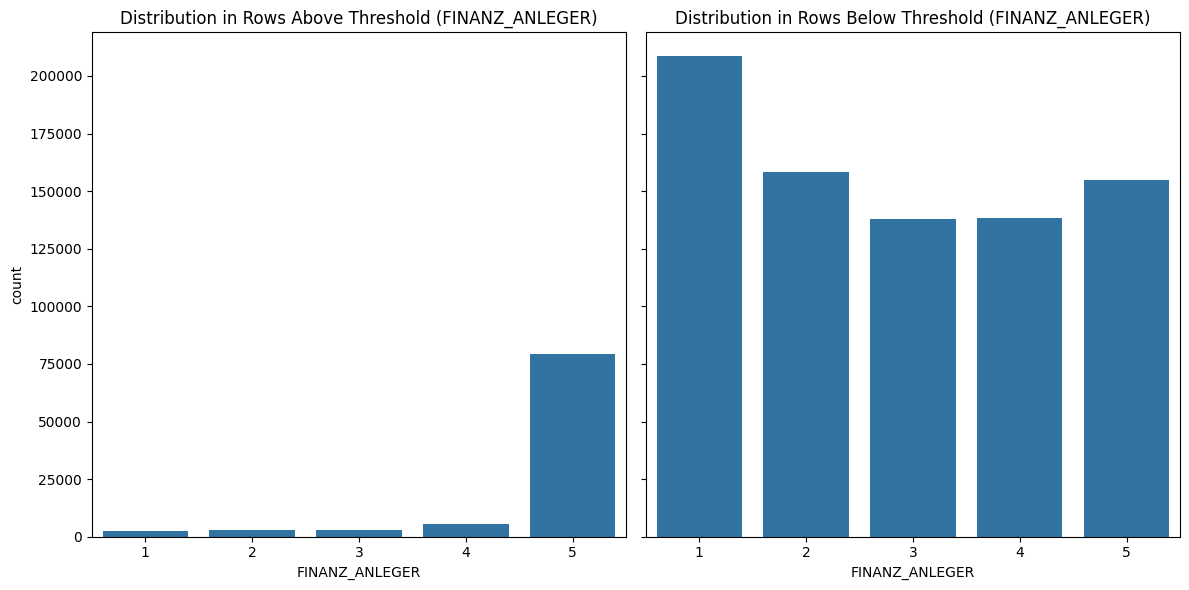

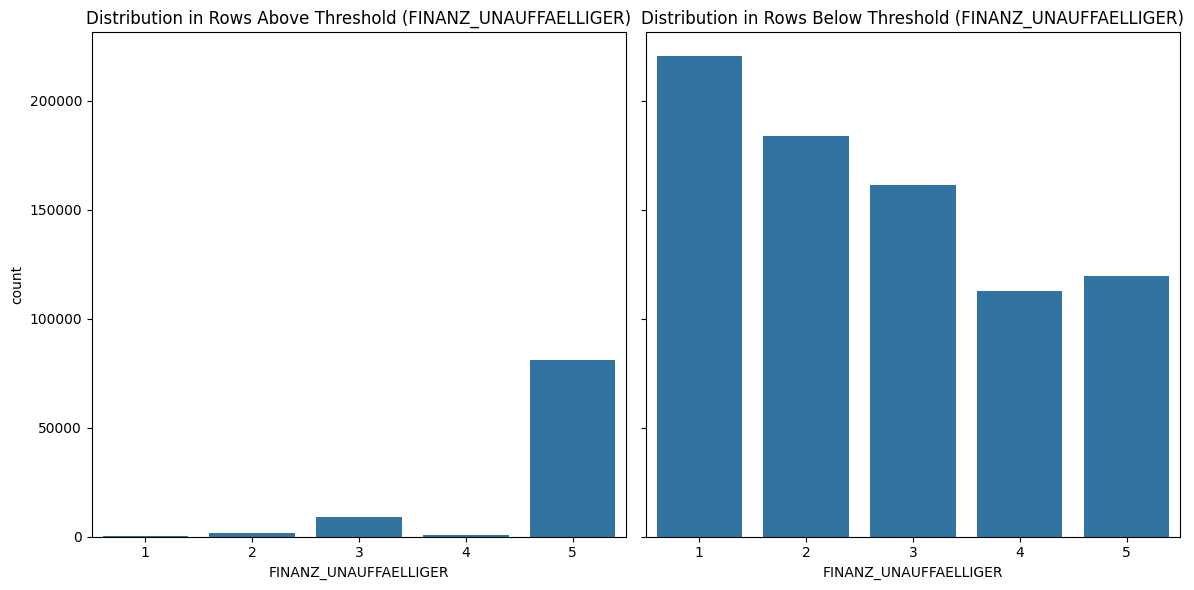

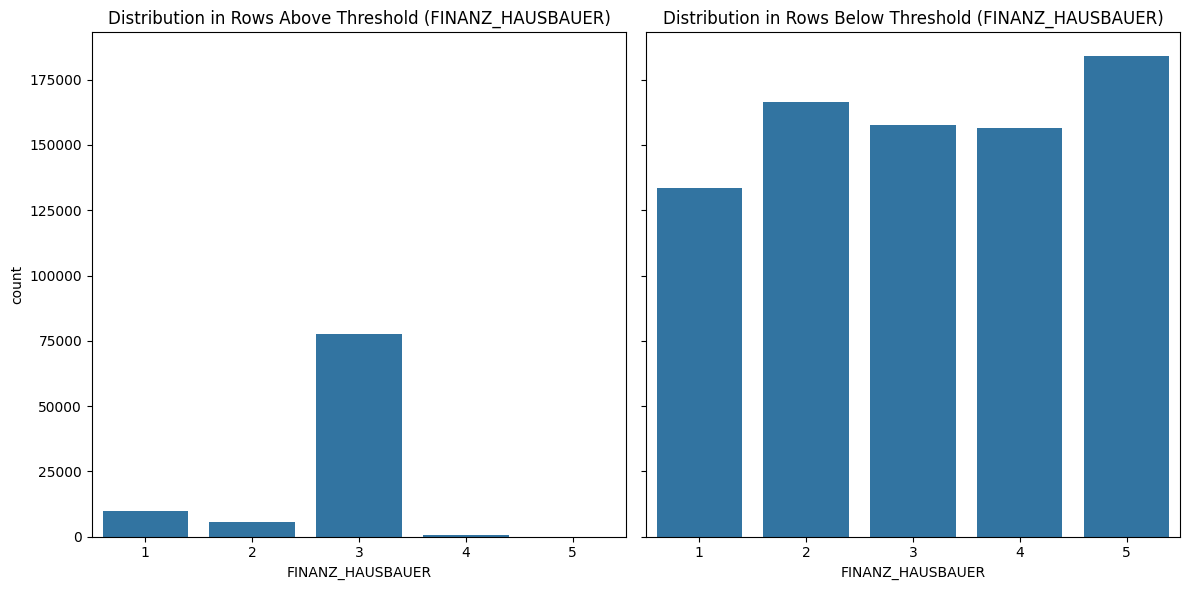

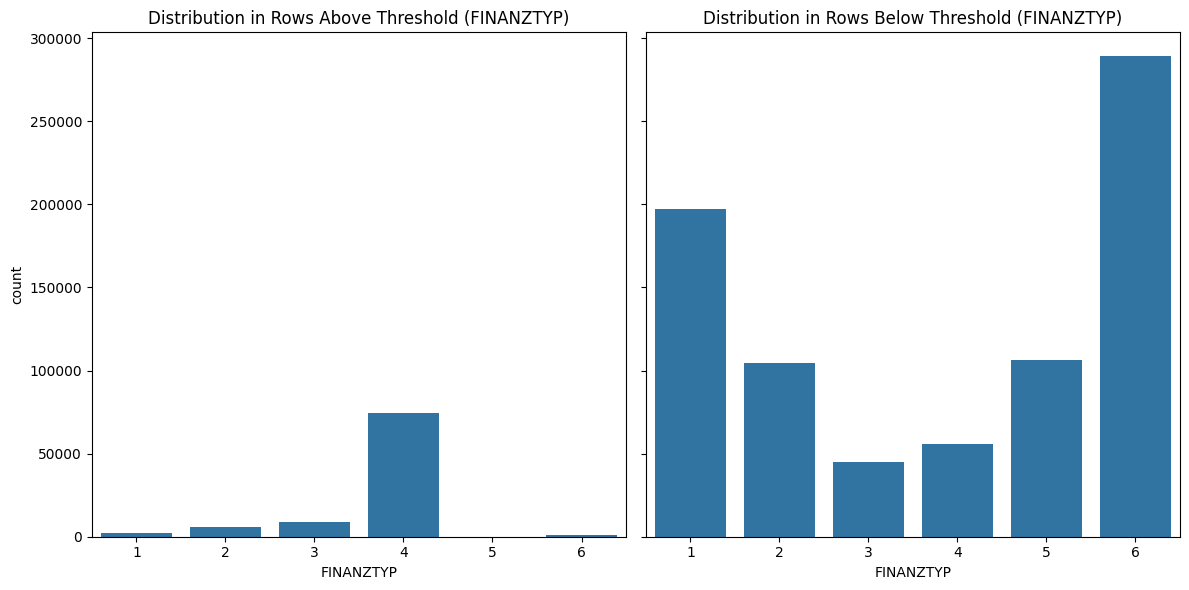

In [24]:
#Compare at least distribution for 5 columns 
columns_to_compare = ['ALTERSKATEGORIE_GROB', 'ANREDE_KZ', 'FINANZ_MINIMALIST',
       'FINANZ_SPARER', 'FINANZ_VORSORGER', 'FINANZ_ANLEGER',
                      'FINANZ_UNAUFFAELLIGER', 'FINANZ_HAUSBAUER', 'FINANZTYP']

for column in columns_to_compare:
    fig, axes = plt.subplots(1, 2, figsize=(12, 6), sharey=True)

    sns.countplot(x=column, data=above_threshold, ax=axes[0])
    axes[0].set_title(f'Distribution in Rows Above Threshold ({column})')

    sns.countplot(x=column, data=below_threshold, ax=axes[1])
    axes[1].set_title(f'Distribution in Rows Below Threshold ({column})')

    plt.tight_layout()
    plt.show()


#### Discussion 1.1.3: Assess Missing Data in Each Row

(Double-click this cell and replace this text with your own text, reporting your observations regarding missing data in rows. Are the data with lots of missing values are qualitatively different from data with few or no missing values?)

### Answer 1.1.3:
We took columns with no missing data and compare the distribution for two subsets one above threshold (rows with missing data more or equal to 30%) the other subset is below threshold (rows with missing data less than 30%). We make both charts having the same scale to ease the comparing of the distribution.
There are some columns doesn't differ a lot between the two subset. On the other hand, there are columns with clear difference in the distribution like: 
['FINANZ_MINIMALIST', 'FINANZ_SPARER', 'FINANZ_VORSORGER', 'FINANZ_ANLEGER',
                      'FINANZ_UNAUFFAELLIGER', 'FINANZ_HAUSBAUER','FINANZTYP']

### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [81]:
# How many features are there of each data type?
feat_info.groupby(feat_info['type'])['attribute'].count()

type
categorical    21
interval        1
mixed           7
numeric         7
ordinal        49
Name: attribute, dtype: int64

#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [22]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?
cat_features = feat_info[feat_info['type']=='categorical']['attribute']
for cat_feature in cat_features:
    if cat_feature in below_threshold.columns:
        if below_threshold[cat_feature].nunique()==2:
            values = below_threshold[cat_feature].unique()
            print(f'({cat_feature}): is a binary feature with values:{values}')

(ANREDE_KZ): is a binary feature with values:[2 1]
(GREEN_AVANTGARDE): is a binary feature with values:[0 1]
(SOHO_KZ): is a binary feature with values:[1. 0.]
(VERS_TYP): is a binary feature with values:[ 2.  1. nan]
(OST_WEST_KZ): is a binary feature with values:['W' 'O']


In [25]:
multi_level_features = []
for cat_feature in cat_features:
    if cat_feature in below_threshold.columns:
        if below_threshold[cat_feature].nunique() > 2: 
            multi_level_features.append(cat_feature)
below_threshold = below_threshold.drop(multi_level_features,axis = 1)

In [26]:
multi_level_features

['CJT_GESAMTTYP',
 'FINANZTYP',
 'GFK_URLAUBERTYP',
 'LP_FAMILIE_FEIN',
 'LP_FAMILIE_GROB',
 'LP_STATUS_FEIN',
 'LP_STATUS_GROB',
 'NATIONALITAET_KZ',
 'SHOPPER_TYP',
 'ZABEOTYP',
 'GEBAEUDETYP',
 'CAMEO_DEUG_2015',
 'CAMEO_DEU_2015']

In [30]:
# Re-encode categorical variable(s) to be kept in the analysis.
below_threshold['OST_WEST_KZ'] = below_threshold['OST_WEST_KZ'].replace({'W': 0, 'O': 1})

In [31]:
below_threshold.shape

(797795, 68)

#### Discussion 1.2.1: Re-Encode Categorical Features

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding categorical features. Which ones did you keep, which did you drop, and what engineering steps did you perform?)

### Answer 1.2.1:
I kept all binary features which are : ANREDE_KZ, GREEN_AVANTGARDE, SOHO_KZ, VERS_TYP and finally OST_WEST_KZ which contains values W and O, so I perform simple replacement for 'W' by 0 and 'O' by 1.

For the multi_level features which are ['CJT_GESAMTTYP',
 'FINANZTYP',
 'GFK_URLAUBERTYP',
 'LP_FAMILIE_FEIN',
 'LP_FAMILIE_GROB',
 'LP_STATUS_FEIN',
 'LP_STATUS_GROB',
 'NATIONALITAET_KZ',
 'SHOPPER_TYP',
 'ZABEOTYP',
 'GEBAEUDETYP',
 'CAMEO_DEUG_2015',
 'CAMEO_DEU_2015'] I droped all of them to keep things simple so know, the data contains 68 columns

#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

In [32]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.
below_threshold['PRAEGENDE_JUGENDJAHRE'].unique()

array([14., 15.,  8.,  3., 10., 11.,  5.,  9.,  6.,  4., nan,  2.,  1.,
       12., 13.,  7.])

In [33]:
decade_map = {
    1: 40,
    2: 40,
    3: 50,
    4: 50,
    5: 60,
    6: 60,
    7: 60,
    8: 70,
    9: 70,
    10: 80,
    11: 80,
    12: 80,
    13: 80,
    14: 90,
    15: 90,
    np.nan: np.nan 
}
#Decade
below_threshold['decade'] = below_threshold['PRAEGENDE_JUGENDJAHRE'].map(decade_map)
#Movement
below_threshold.loc[below_threshold['PRAEGENDE_JUGENDJAHRE'].isin([1,3,5,8,10,12,14]),'WHETHER_MAINSTREAM']=1
below_threshold.loc[below_threshold['PRAEGENDE_JUGENDJAHRE'].isin([2,4,6,7,9,11,13,15]),'WHETHER_MAINSTREAM']=0


In [34]:
# drop PRAEGENDE_JUGENDJAHRE
below_threshold=below_threshold.drop('PRAEGENDE_JUGENDJAHRE',axis=1)

In [35]:
below_threshold.shape

(797795, 69)

In [36]:
# Investigate "CAMEO_INTL_2015" and engineer two new variables.
below_threshold['CAMEO_INTL_2015'].unique()

array(['51', '24', '12', '43', '54', '22', '14', '13', '15', '33', '41',
       '34', '55', nan, '25', '23', '31', '52', '35', '45', '44', '32'],
      dtype=object)

In [37]:
below_threshold['CAMEO_INTL_2015_wealth'] = below_threshold['CAMEO_INTL_2015'].str[0].astype(float)
below_threshold['CAMEO_INTL_2015_life_stage'] = below_threshold['CAMEO_INTL_2015'].str[1].astype(float)

In [38]:
# drop CAMEO_INTL_2015
below_threshold=below_threshold.drop('CAMEO_INTL_2015',axis=1)

In [39]:
below_threshold.shape

(797795, 70)

In [40]:
for feature in feat_info[feat_info['type']=='mixed']['attribute'].values:
    if feature in below_threshold.columns:
        below_threshold = below_threshold.drop(feature,axis=1)

In [41]:
below_threshold.shape

(797795, 66)

#### Discussion 1.2.2: Engineer Mixed-Type Features

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding mixed-value features. Which ones did you keep, which did you drop, and what engineering steps did you perform?)

### Answer 1.2.2:
For mixed features, I decided to keep only the new features generated from : PRAEGENDE_JUGENDJAHRE and CAMEO_INTL_2015. 

For PRAEGENDE_JUGENDJAHRE and based on the documentation the numbers were related to decades and movement so I did map for the decade and I loc for the numbers representing either MAINSTREAM or Avantgarde and I made two new features from these numbers.

For CAMEO_INTL_2015, the code contains 2 digits one represents the wealth degree (tens digit) where less number represents more wealthy and the other is the life stage (ones digit) where higher number represents higher life stage

#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

In [81]:
# If there are other re-engineering tasks you need to perform, make sure you
# take care of them here. (Dealing with missing data will come in step 2.1.)

In [42]:
# Do whatever you need to in order to ensure that the dataframe only contains
# the columns that should be passed to the algorithm functions.
below_threshold.shape

(797795, 66)

In [43]:
below_threshold.columns

Index(['ALTERSKATEGORIE_GROB', 'ANREDE_KZ', 'FINANZ_MINIMALIST',
       'FINANZ_SPARER', 'FINANZ_VORSORGER', 'FINANZ_ANLEGER',
       'FINANZ_UNAUFFAELLIGER', 'FINANZ_HAUSBAUER', 'GEBURTSJAHR',
       'GREEN_AVANTGARDE', 'HEALTH_TYP', 'RETOURTYP_BK_S', 'SEMIO_SOZ',
       'SEMIO_FAM', 'SEMIO_REL', 'SEMIO_MAT', 'SEMIO_VERT', 'SEMIO_LUST',
       'SEMIO_ERL', 'SEMIO_KULT', 'SEMIO_RAT', 'SEMIO_KRIT', 'SEMIO_DOM',
       'SEMIO_KAEM', 'SEMIO_PFLICHT', 'SEMIO_TRADV', 'SOHO_KZ', 'VERS_TYP',
       'ALTER_HH', 'ANZ_PERSONEN', 'ANZ_TITEL', 'HH_EINKOMMEN_SCORE',
       'W_KEIT_KIND_HH', 'WOHNDAUER_2008', 'ANZ_HAUSHALTE_AKTIV',
       'ANZ_HH_TITEL', 'KONSUMNAEHE', 'MIN_GEBAEUDEJAHR', 'OST_WEST_KZ',
       'KBA05_ANTG1', 'KBA05_ANTG2', 'KBA05_ANTG3', 'KBA05_ANTG4', 'KBA05_GBZ',
       'BALLRAUM', 'EWDICHTE', 'INNENSTADT', 'GEBAEUDETYP_RASTER', 'KKK',
       'MOBI_REGIO', 'ONLINE_AFFINITAET', 'REGIOTYP', 'KBA13_ANZAHL_PKW',
       'PLZ8_ANTG1', 'PLZ8_ANTG2', 'PLZ8_ANTG3', 'PLZ8_ANTG4', 'PLZ8_HHZ'

In [44]:
below_threshold.isnull().mean()

ALTERSKATEGORIE_GROB          0.003508
ANREDE_KZ                     0.000000
FINANZ_MINIMALIST             0.000000
FINANZ_SPARER                 0.000000
FINANZ_VORSORGER              0.000000
FINANZ_ANLEGER                0.000000
FINANZ_UNAUFFAELLIGER         0.000000
FINANZ_HAUSBAUER              0.000000
GEBURTSJAHR                   0.389455
GREEN_AVANTGARDE              0.000000
HEALTH_TYP                    0.045868
RETOURTYP_BK_S                0.005852
SEMIO_SOZ                     0.000000
SEMIO_FAM                     0.000000
SEMIO_REL                     0.000000
SEMIO_MAT                     0.000000
SEMIO_VERT                    0.000000
SEMIO_LUST                    0.000000
SEMIO_ERL                     0.000000
SEMIO_KULT                    0.000000
SEMIO_RAT                     0.000000
SEMIO_KRIT                    0.000000
SEMIO_DOM                     0.000000
SEMIO_KAEM                    0.000000
SEMIO_PFLICHT                 0.000000
SEMIO_TRADV              

### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [3]:
def clean_data(df):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    
    # Put in code here to execute all main cleaning steps:
    # convert missing value codes into NaNs, ...
    for feature in feat_info['attribute']:
        string_to_list=feat_info[feat_info['attribute']==feature]['missing_or_unknown'].iloc[0].replace('[','').replace(']','').split(',')
        values =[int(item) if item.lstrip('-').isdigit() else item for item in string_to_list]

        df[feature].replace(to_replace=values,
                          value=np.nan, inplace=True)  
    # remove selected columns and rows, ...
    
    #remove outlier columns
    threshold_columns = 0.5
    missing_percentage_per_feature = round (df.isnull().mean(),2)
    outlier_columns = missing_percentage_per_feature[missing_percentage_per_feature > threshold_columns].index
    df_no_outlier = df.drop(columns = outlier_columns,axis = 1)
    
    #remove outlier rows
    threshold_rows = 0.3
    missing_percentage_per_row = df_no_outlier.isnull().mean(axis=1)
    below_threshold=df_no_outlier[missing_percentage_per_row < threshold_rows]
    
    # select, re-encode, and engineer column values.
    
    #re-encode
    below_threshold.loc[:,'OST_WEST_KZ'] = below_threshold['OST_WEST_KZ'].replace({'W': 0, 'O': 1})

    #remove multi-level features
    multi_level_features = []
    cat_features = feat_info[feat_info['type']=='categorical']['attribute']
    for cat_feature in cat_features:
        if cat_feature in below_threshold.columns:
            if below_threshold[cat_feature].nunique() > 2: 
                multi_level_features.append(cat_feature)
    below_threshold = below_threshold.drop(multi_level_features,axis = 1)

    #engineer mixed-type features
    decade_map = {
    1: 40,
    2: 40,
    3: 50,
    4: 50,
    5: 60,
    6: 60,
    7: 60,
    8: 70,
    9: 70,
    10: 80,
    11: 80,
    12: 80,
    13: 80,
    14: 90,
    15: 90,
    np.nan: np.nan 
    }
    #Decade
    below_threshold['decade'] = below_threshold['PRAEGENDE_JUGENDJAHRE'].map(decade_map)
    #Movement
    below_threshold.loc[below_threshold['PRAEGENDE_JUGENDJAHRE'].isin([1,3,5,8,10,12,14]),'WHETHER_MAINSTREAM']=1
    below_threshold.loc[below_threshold['PRAEGENDE_JUGENDJAHRE'].isin([2,4,6,7,9,11,13,15]),'WHETHER_MAINSTREAM']=0
    #Wealth
    below_threshold['CAMEO_INTL_2015_wealth'] = below_threshold['CAMEO_INTL_2015'].str[0].astype(float)
    #Life stage
    below_threshold['CAMEO_INTL_2015_life_stage'] = below_threshold['CAMEO_INTL_2015'].str[1].astype(float)   
    
    #remove other Mixed features 
    for feature in feat_info[feat_info['type']=='mixed']['attribute'].values:
        if feature in below_threshold.columns:
            below_threshold = below_threshold.drop(feature,axis=1)
    
    final_cleaned_data = below_threshold
    # Return the cleaned dataframe.
    return final_cleaned_data    

In [4]:
final_cleaned_data = clean_data(AZDIAS_data)
#final_cleaned_data.head()
final_cleaned_data.shape

(797795, 66)

## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [SimpleImputer](https://scikit-learn.org/stable/modules/generated/sklearn.impute.SimpleImputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [5]:
# If you've not yet cleaned the dataset of all NaN values, then investigate and
# do that now.
imputer = SimpleImputer()
imputer = imputer.fit(final_cleaned_data)
clean_df = imputer.transform(final_cleaned_data)

In [6]:
# Apply feature scaling to the general population demographics data.
scaler = StandardScaler()
scaler = scaler.fit(clean_df)
new_df = scaler.transform(clean_df)

In [7]:
scaled_df = pd.DataFrame(new_df, columns = final_cleaned_data.columns, index = final_cleaned_data.index)
scaled_df.shape

(797795, 66)

In [9]:
scaled_df.isnull().sum()

ALTERSKATEGORIE_GROB          0
ANREDE_KZ                     0
FINANZ_MINIMALIST             0
FINANZ_SPARER                 0
FINANZ_VORSORGER              0
FINANZ_ANLEGER                0
FINANZ_UNAUFFAELLIGER         0
FINANZ_HAUSBAUER              0
GEBURTSJAHR                   0
GREEN_AVANTGARDE              0
HEALTH_TYP                    0
RETOURTYP_BK_S                0
SEMIO_SOZ                     0
SEMIO_FAM                     0
SEMIO_REL                     0
SEMIO_MAT                     0
SEMIO_VERT                    0
SEMIO_LUST                    0
SEMIO_ERL                     0
SEMIO_KULT                    0
SEMIO_RAT                     0
SEMIO_KRIT                    0
SEMIO_DOM                     0
SEMIO_KAEM                    0
SEMIO_PFLICHT                 0
SEMIO_TRADV                   0
SOHO_KZ                       0
VERS_TYP                      0
ALTER_HH                      0
ANZ_PERSONEN                  0
ANZ_TITEL                     0
HH_EINKO

In [10]:
scaled_df.head()

ALTERSKATEGORIE_GROB  ANREDE_KZ  FINANZ_MINIMALIST  FINANZ_SPARER  \
1             -1.765916   0.957985          -1.494636       1.538067   
2              0.201266   0.957985          -1.494636       0.864699   
3              1.184857   0.957985           0.683148      -0.482037   
4              0.201266  -1.043858           0.683148       0.191331   
5             -1.765916   0.957985          -0.042780      -1.155404   

   FINANZ_VORSORGER  FINANZ_ANLEGER  FINANZ_UNAUFFAELLIGER  FINANZ_HAUSBAUER  \
1         -1.040678        1.466228               0.959119          1.339107   
2         -1.766921       -0.570875               0.244500          1.339107   
3          1.138050       -0.570875              -1.184737         -0.791567   
4          0.411807       -1.249909               0.244500         -0.791567   
5          1.138050       -0.570875              -0.470119          1.339107   

   GEBURTSJAHR  GREEN_AVANTGARDE  HEALTH_TYP  RETOURTYP_BK_S  SEMIO_SOZ  \
1     2.078861         -0.530476    1.085791       -1.684582   0.442980   
2     0.856351          1.885099    1.085791       -0.305440  -0.072232   
3    -0.725722         -0.530476   -0.269895       -0.995011   0.442980   
4    -0.294247         -0.530476    1.085791        1.073702   0.958192   
5    -1.732495         -0.530476    1.085791       -0.305440  -1.102656   

   SEMIO_FAM  SEMIO_REL  SEMIO_MAT  SEMIO_VERT  SEMIO_LUST  SEMIO_ERL  \
1  -0.059209   0.003056  -0.463704   -1.684827   -1.109896  -1.435486   
2  -1.626872  -0.520409  -0.463704   -0.142647   -0.158779   0.754153   
3  -1.626872  -1.043874  -1.509014   -0.142647   -0.158779   1.301563   
4  -0.059209   0.003056  -0.986359    1.399533   -0.158779  -0.340666   
5  -0.059209   1.573452   0.058951   -1.170767   -1.109896  -1.435486   

   SEMIO_KULT  SEMIO_RAT  SEMIO_KRIT  SEMIO_DOM  SEMIO_KAEM  SEMIO_PFLICHT  \
1   -0.578238   1.274158   -0.312026   1.339252   -0.157542       1.518534   
2   -0.578238   0.064280    1.392368   1.339252    1.448687      -0.638784   
3   -0.067480  -0.540659   -0.312026  -0.303513    0.377868      -0.099454   
4    0.954035  -1.145599   -0.880158  -1.398690   -1.228362      -0.099454   
5    0.443278   1.879097   -0.312026  -0.303513   -0.157542       1.518534   

   SEMIO_TRADV    SOHO_KZ  VERS_TYP      ALTER_HH  ANZ_PERSONEN  ANZ_TITEL  \
1     1.288853  10.853119  0.987762  5.539354e-16      0.234262  -0.060397   
2    -0.410283  -0.092139 -1.061058  5.329564e-01     -0.630406  -0.060397   
3     0.156096  -0.092139 -1.061058 -7.143952e-01     -1.495075  -0.060397   
4    -0.976661  -0.092139  0.987762  1.468470e+00      1.963598  -0.060397   
5     1.288853  -0.092139  0.987762 -1.649909e+00     -0.630406  -0.060397   

   HH_EINKOMMEN_SCORE  W_KEIT_KIND_HH  WOHNDAUER_2008  ANZ_HAUSHALTE_AKTIV  \
1            1.026452   -6.788244e-01        0.567048             0.169350   
2           -0.267930   -6.788244e-01        0.567048             0.105298   
3           -2.209504   -5.189232e-16        0.567048            -0.471170   
4            0.379261   -1.263080e+00        0.567048            -0.343066   
5            0.379261    1.073942e+00        0.567048            -0.214962   

   ANZ_HH_TITEL  KONSUMNAEHE  MIN_GEBAEUDEJAHR  OST_WEST_KZ  KBA05_ANTG1  \
1     -0.125735    -1.304660         -0.383227    -0.517461    -1.091985   
2     -0.125735     1.274942         -0.383227    -0.517461    -0.361207   
3     -0.125735     0.630042          1.124126    -0.517461     1.831130   
4     -0.125735     0.630042         -0.383227    -0.517461    -0.361207   
5     -0.125735     1.274942         -0.383227    -0.517461     0.369572   

   KBA05_ANTG2  KBA05_ANTG3  KBA05_ANTG4  KBA05_GBZ  BALLRAUM  EWDICHTE  \
1    -1.042799    -0.632255     2.721191  -1.665745   0.84613 -0.546657   
2     1.429101     0.380120    -0.491411  -0.122372  -0.98627  0.035302   
3    -0.218832    -0.632255    -0.491411   0.649315  -0.07007 -1.128616   
4     2.253067     0.380120    -0.4

In [8]:
# make a function for scaling to be used in the other dataframe
def scaling(df):
    
    clean_df = imputer.transform(df)
    
    new_df = scaler.transform(clean_df)
    
    scaled_df = pd.DataFrame(new_df, columns = df.columns, index = df.index)
    
    return scaled_df

### Discussion 2.1: Apply Feature Scaling

(Double-click this cell and replace this text with your own text, reporting your decisions regarding feature scaling.)

### Answer 2.1:
After the first step of re-encode, engineering, dealing with missing data per column and per row, here, I started with simple imputer to deal with null values in all features to be able of scalling the data and then I used standard scaler to scale all of other features and put it in a new dataframe to be able to perform PCA. After that, I define a function combine all steps to be used for the other dataframe.

### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [11]:
# Apply PCA to the data.
def do_pca(comp, df):
    pca = PCA(n_components=comp)
    pca_X = pca.fit_transform(df)
    return pca, pca_X

In [8]:
pca, pca_X = do_pca(40, scaled_df)

In [12]:
# Investigate the variance accounted for by each principal component.
def scree_plot(pca):

    num_components=len(pca.explained_variance_ratio_)
    ind = np.arange(num_components)
    vals = pca.explained_variance_ratio_
 
    plt.figure(figsize=(10, 6))
    ax = plt.subplot(111)
    cumvals = np.cumsum(vals)
    ax.bar(ind, vals)
    ax.plot(ind, cumvals)
    for i in range(num_components):
        ax.annotate(r"%s%%" % ((str(vals[i]*100)[:4])), (ind[i]+0.2, vals[i]), va="bottom", ha="center", fontsize=12)
 
    ax.xaxis.set_tick_params(width=0)
    ax.yaxis.set_tick_params(width=2, length=12)
 
    ax.set_xlabel("Principal Component")
    ax.set_ylabel("Variance-Explained Ratio")
    plt.title('Explained Variance Per Principal Component')
    

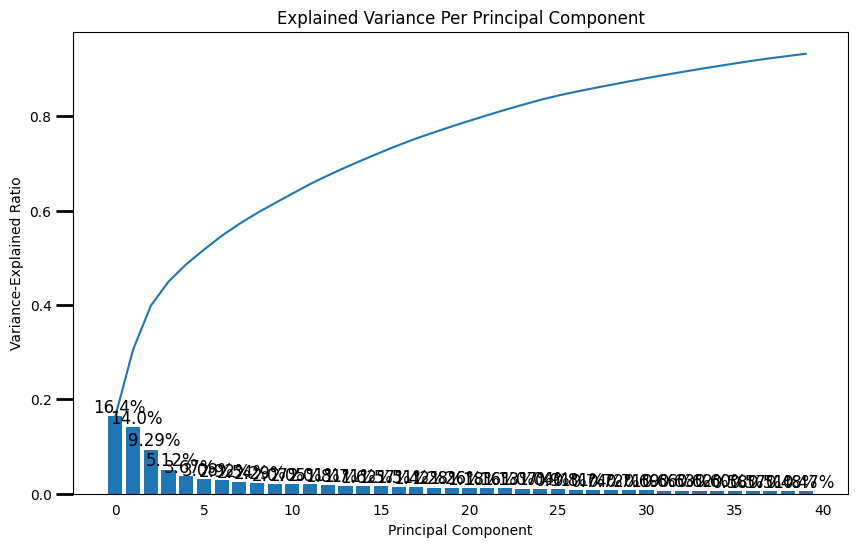

In [10]:
scree_plot(pca)

In [13]:
def pca_results(full_dataset, pca):
    '''
    Create a DataFrame of the PCA results
    Includes dimension feature weights and explained variance
    Visualizes the PCA results
    '''

    # Dimension indexing
    dimensions = dimensions = ['Dimension {}'.format(i) for i in range(1,len(pca.components_)+1)]

    # PCA components
    components = pd.DataFrame(np.round(pca.components_, 4), columns = full_dataset.keys())
    components.index = dimensions

    # PCA explained variance
    ratios = pca.explained_variance_ratio_.reshape(len(pca.components_), 1)
    variance_ratios = pd.DataFrame(np.round(ratios, 4), columns = ['Explained Variance'])
    variance_ratios.index = dimensions

    # Create a bar plot visualization
    fig, ax = plt.subplots(figsize = (14,8))

    # Plot the feature weights as a function of the components
    components.plot(ax = ax, kind = 'bar');
    ax.set_ylabel("Feature Weights")
    ax.set_xticklabels(dimensions, rotation=0)


    # Display the explained variance ratios
    for i, ev in enumerate(pca.explained_variance_ratio_):
        ax.text(i-0.40, ax.get_ylim()[1] + 0.05, "Explained Variance\n          %.4f"%(ev))

    # Return a concatenated DataFrame
    return pd.concat([variance_ratios, components], axis = 1)

/tmp/ipykernel_13/390130797.py:21: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(figsize = (14,8))


Using 27 components, we can explain 0.8513% of the variability in the original data.


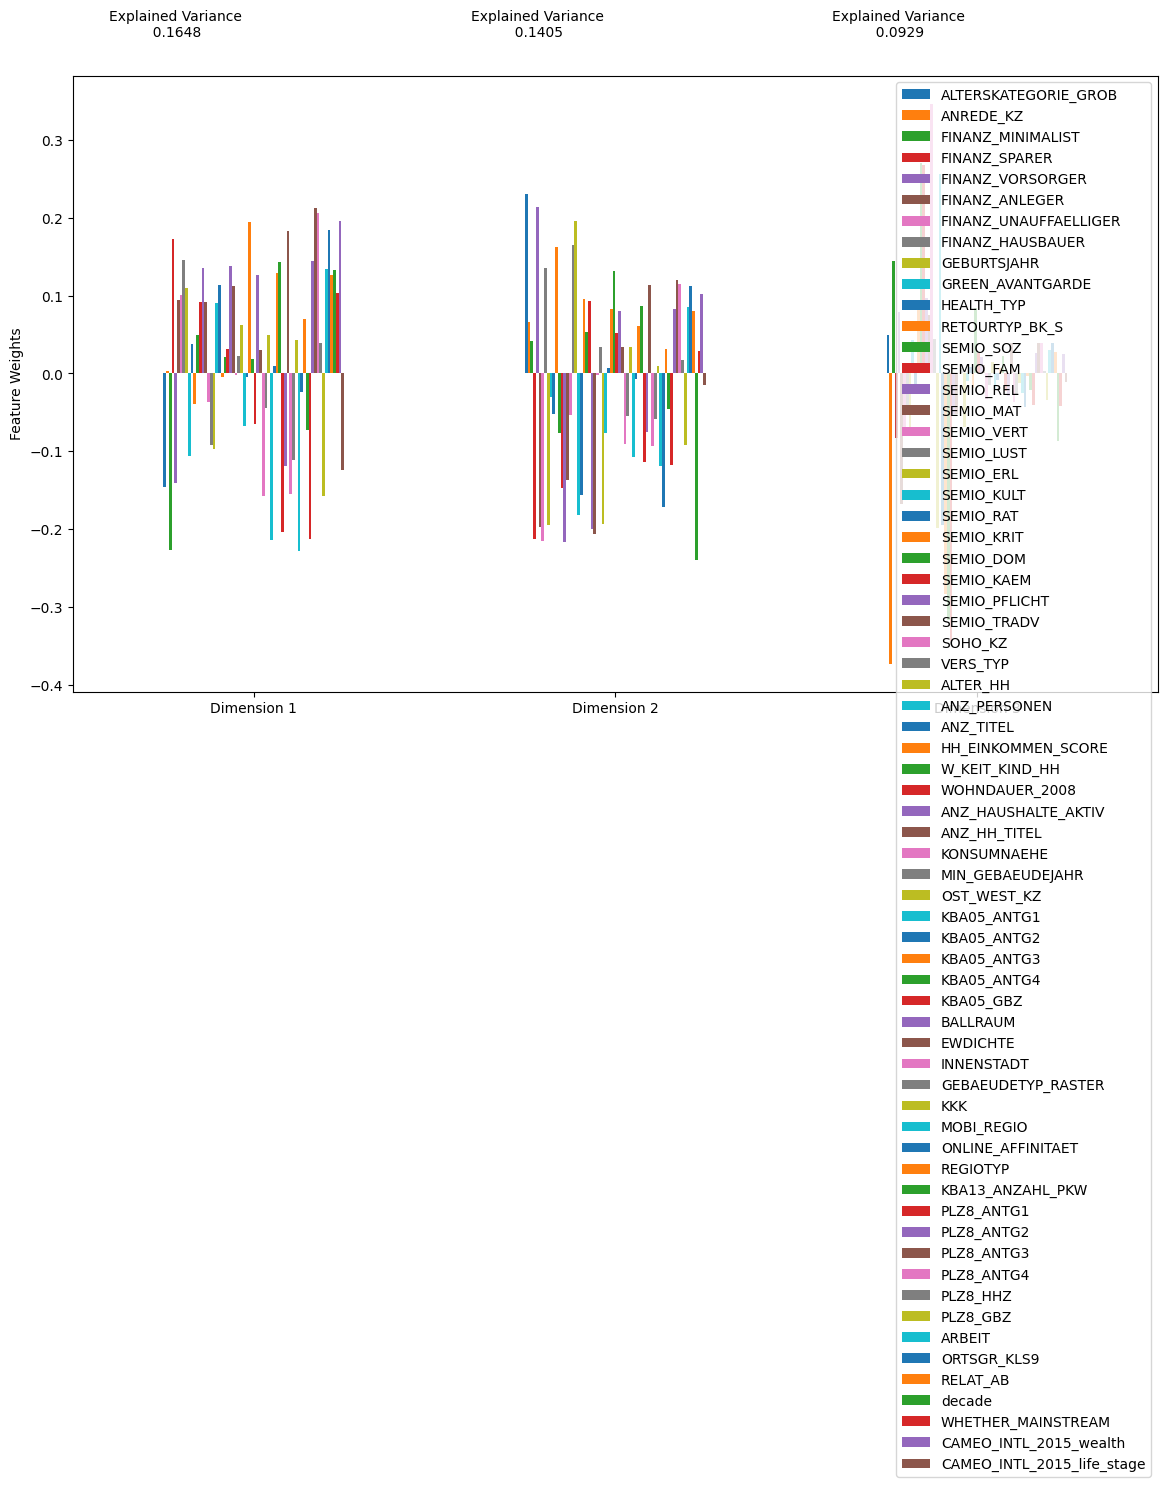

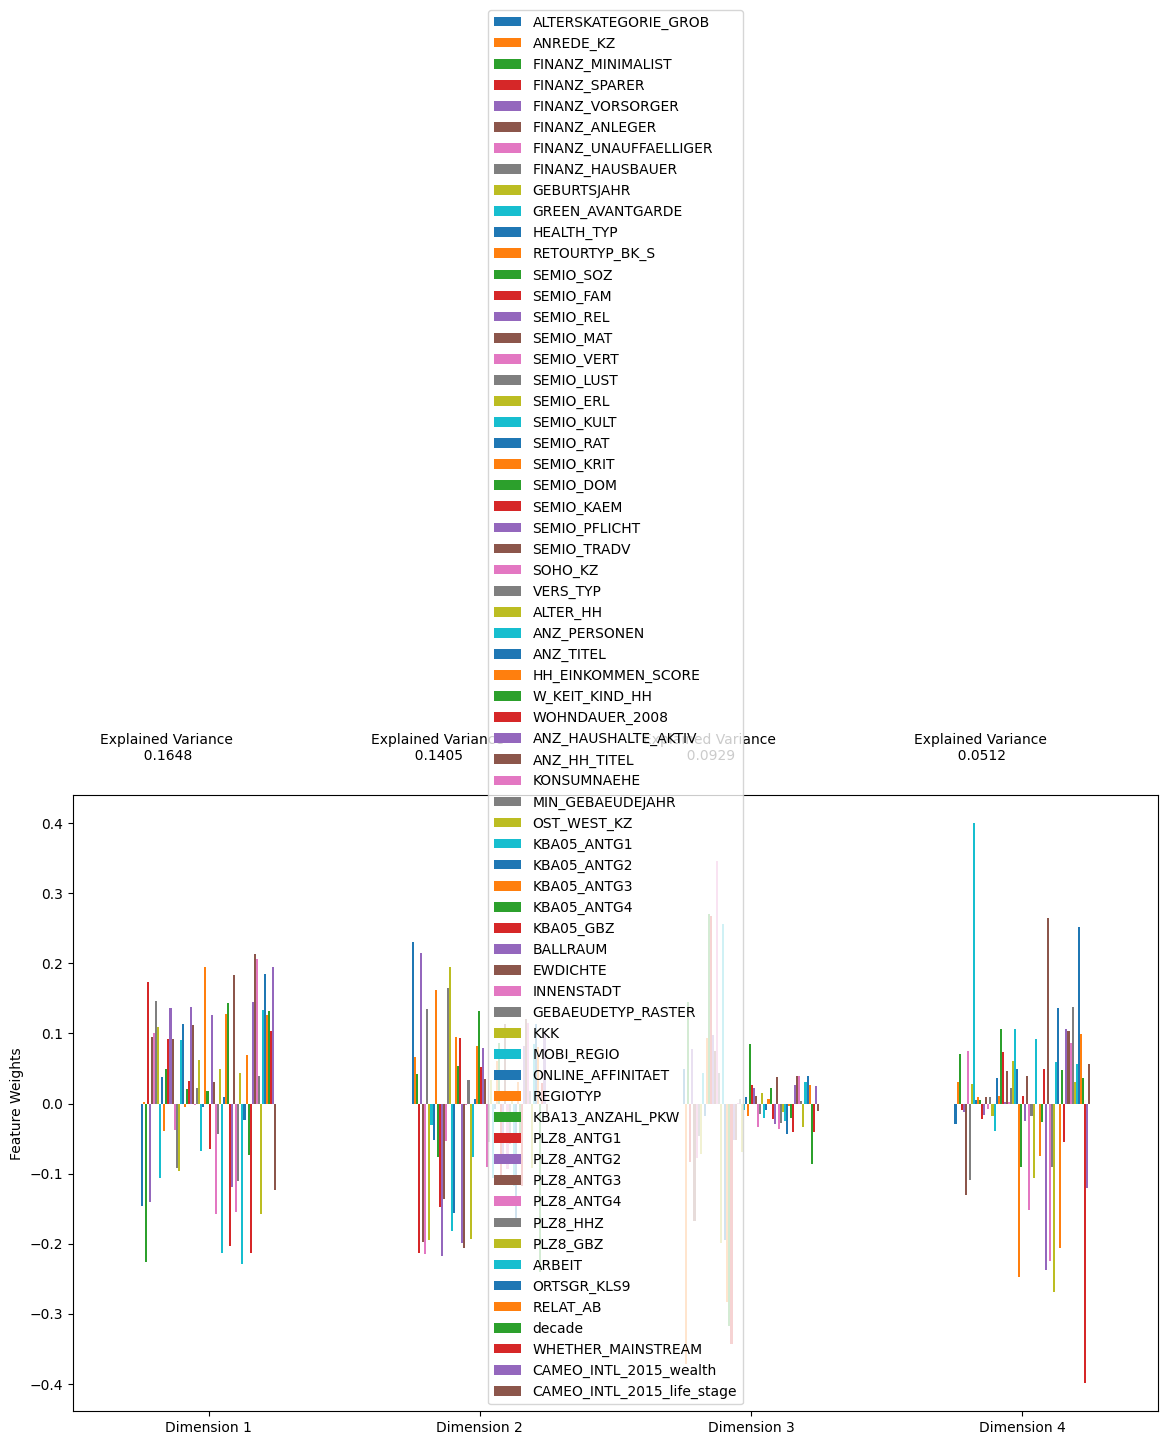

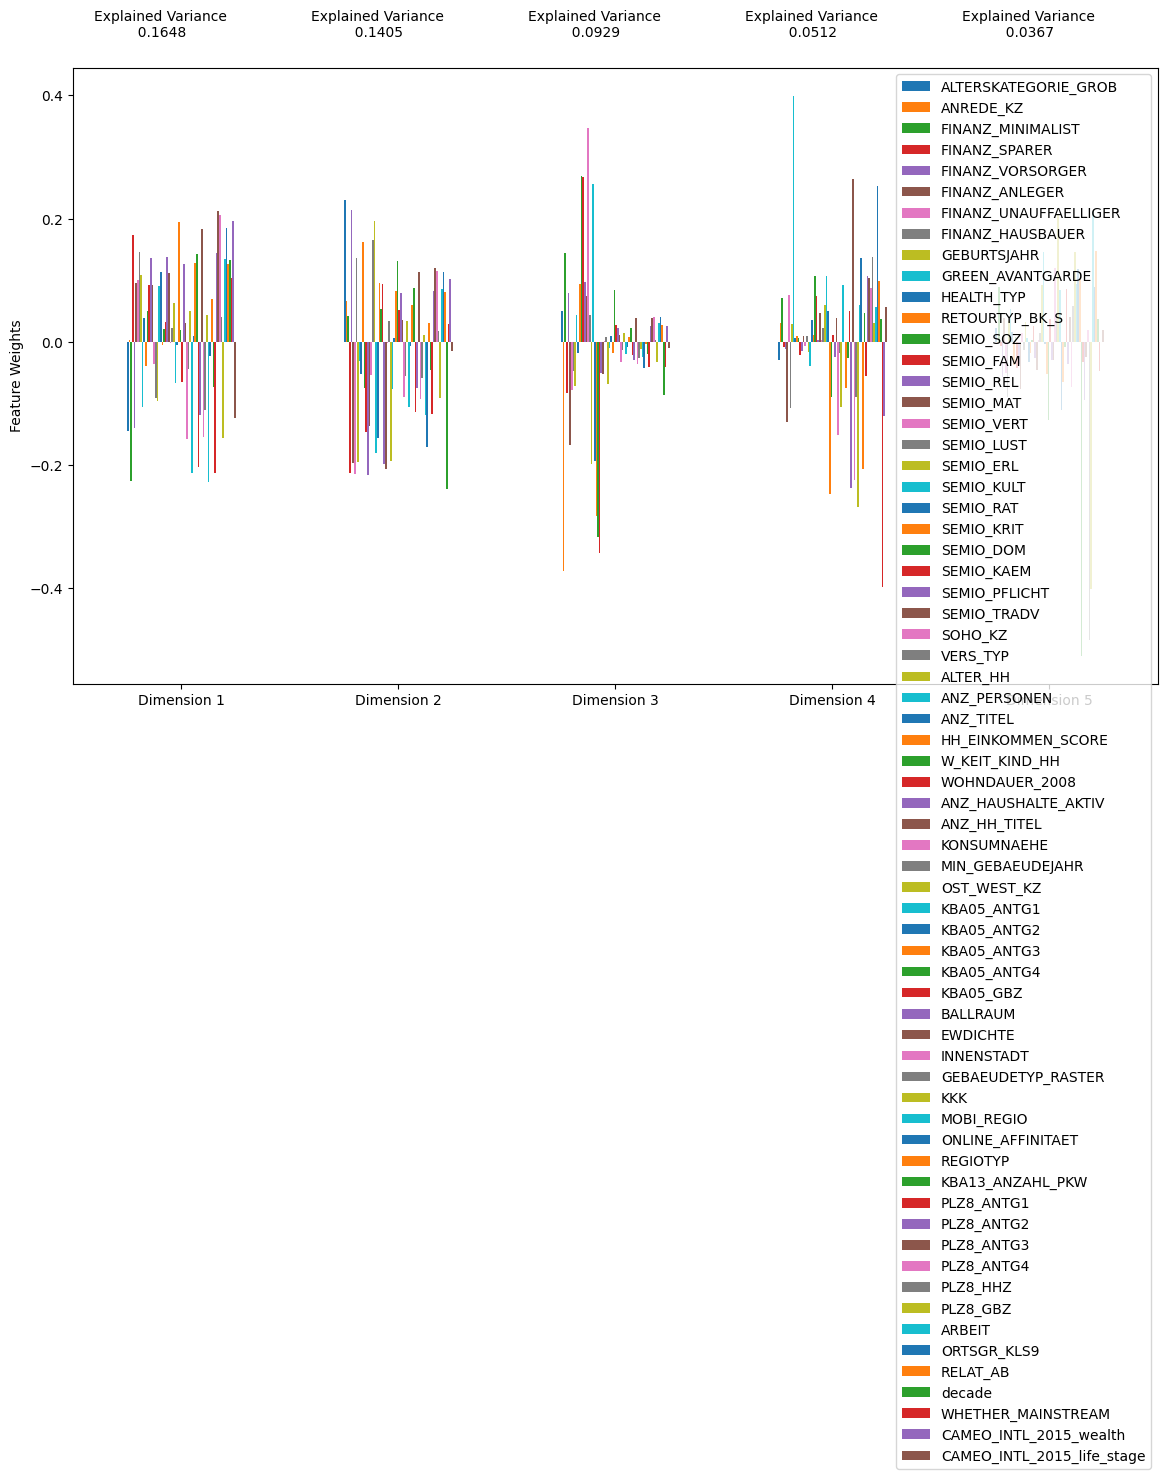

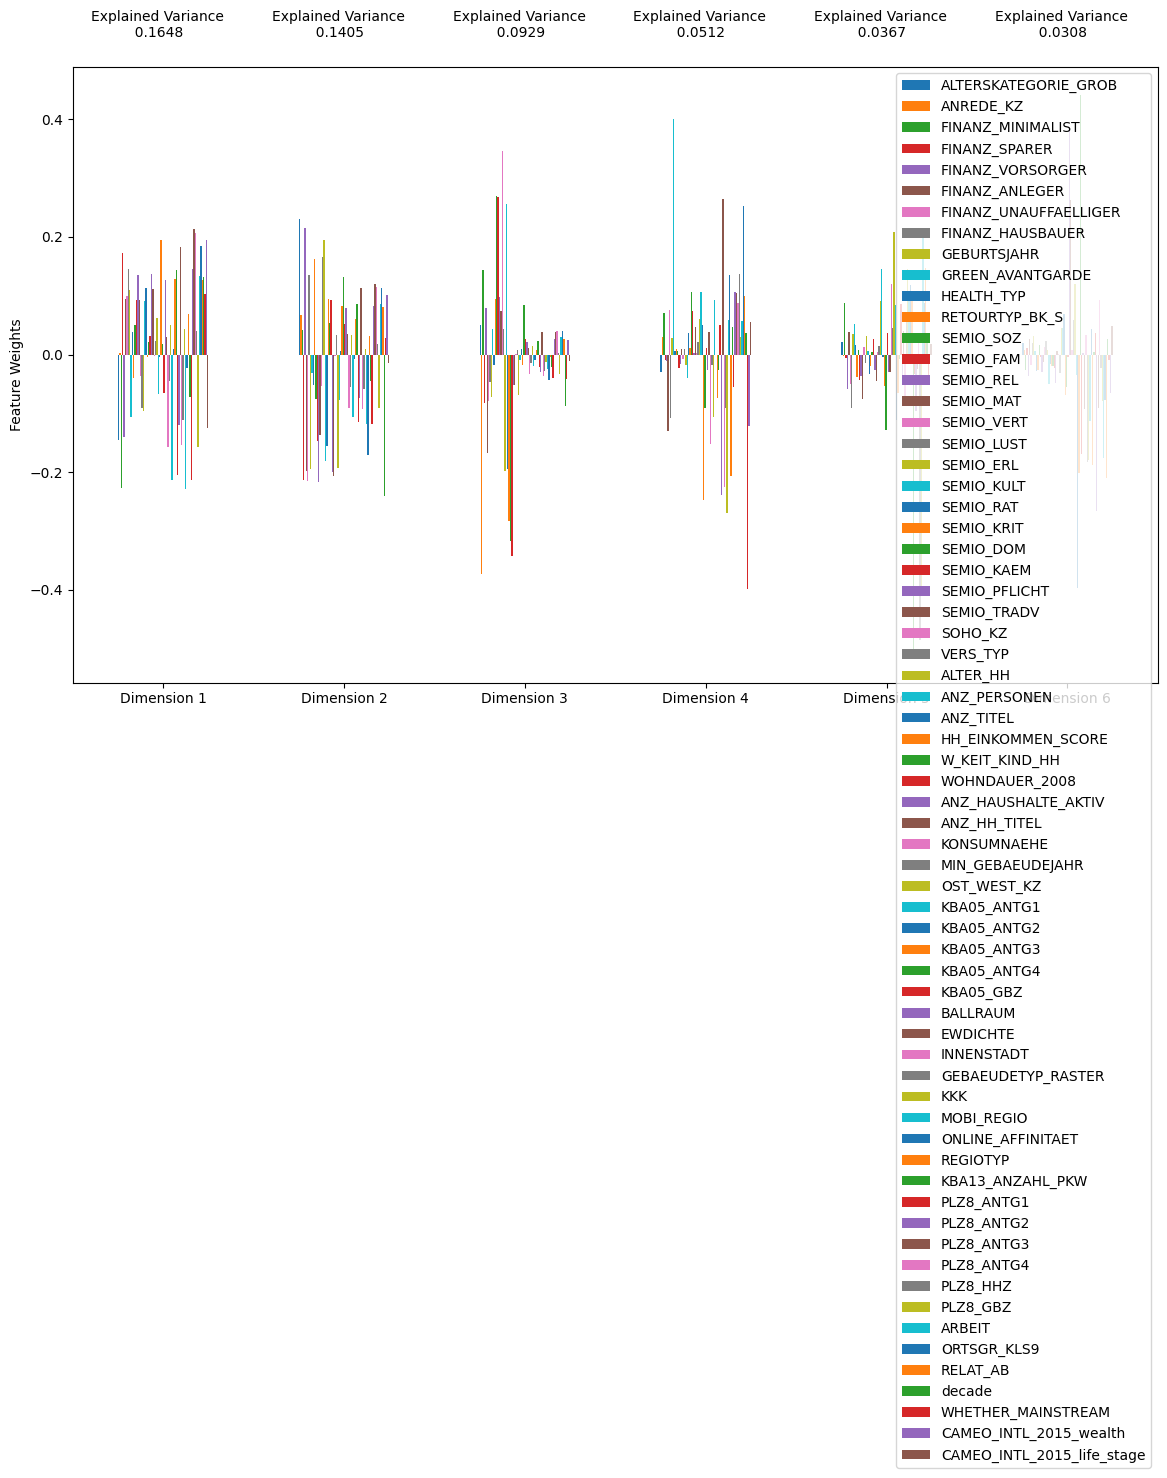

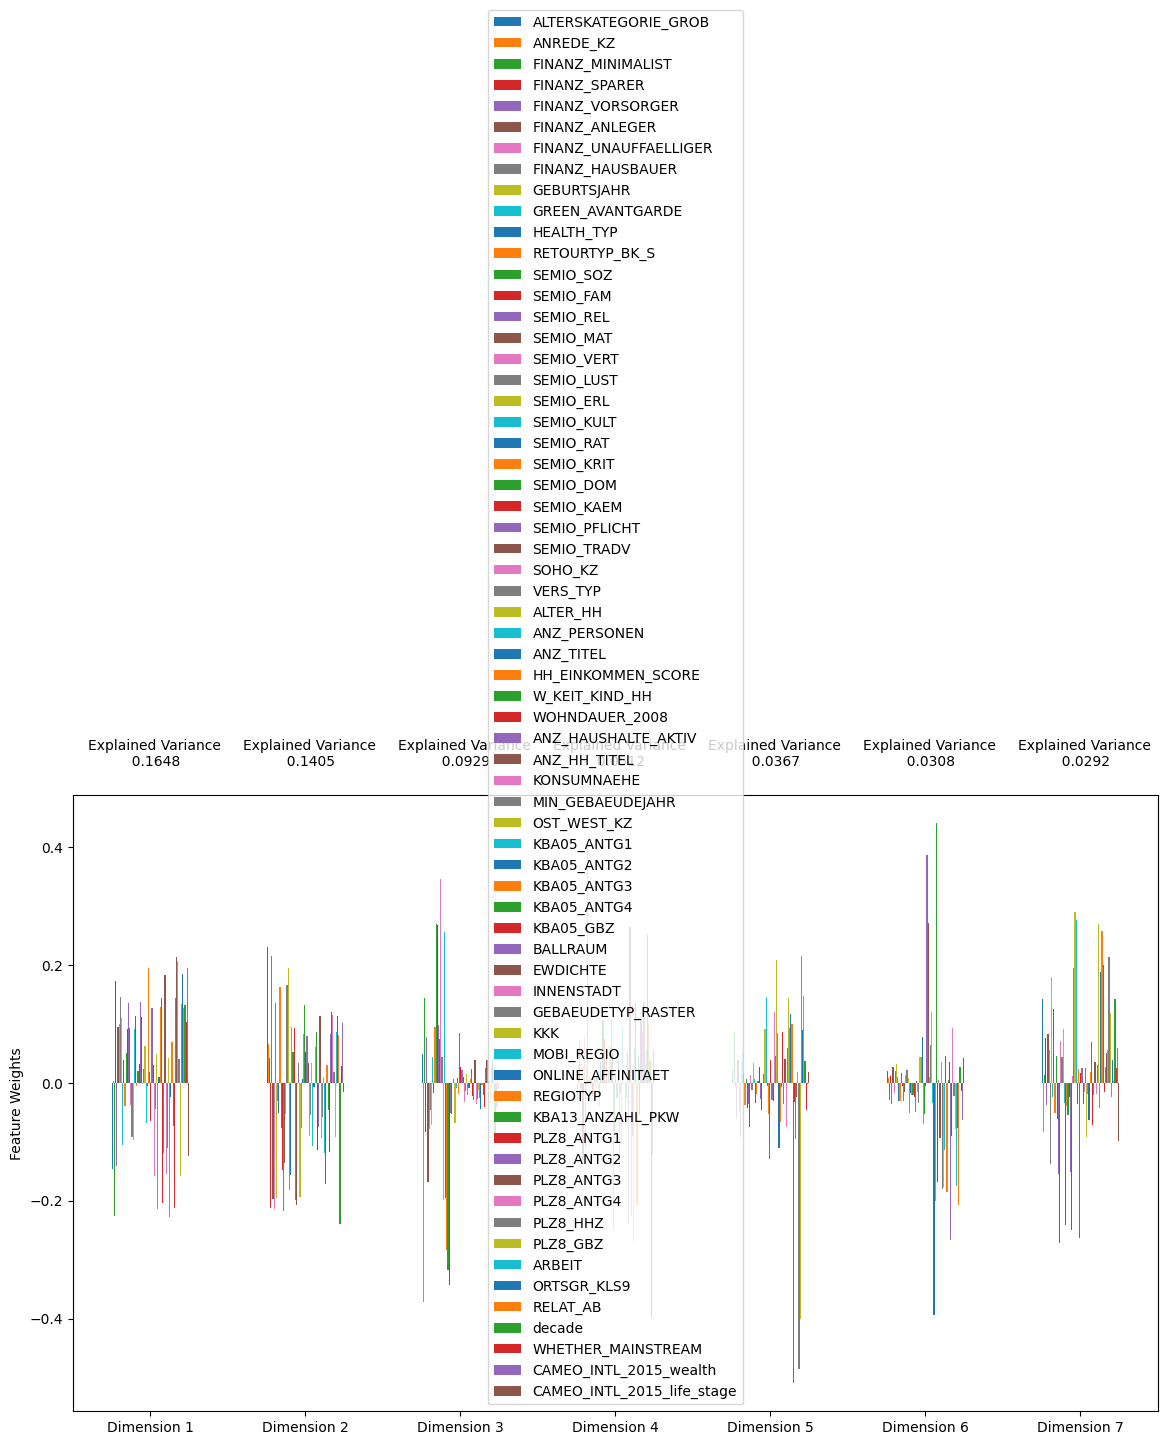

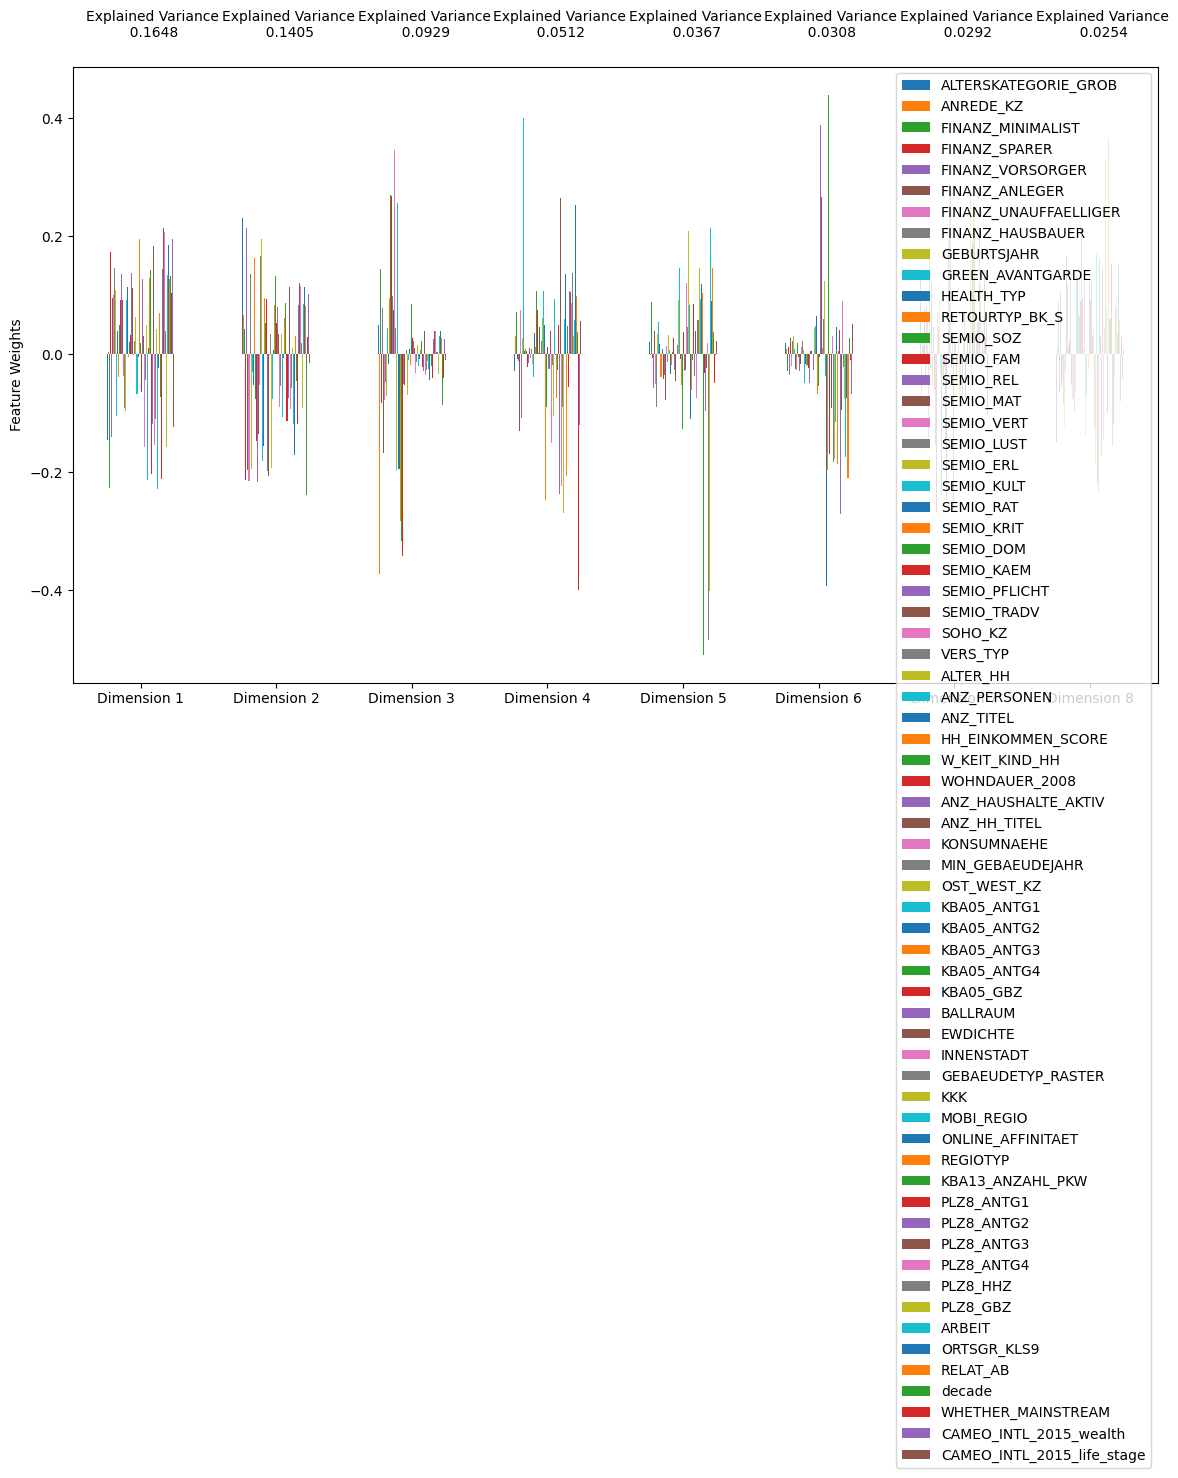

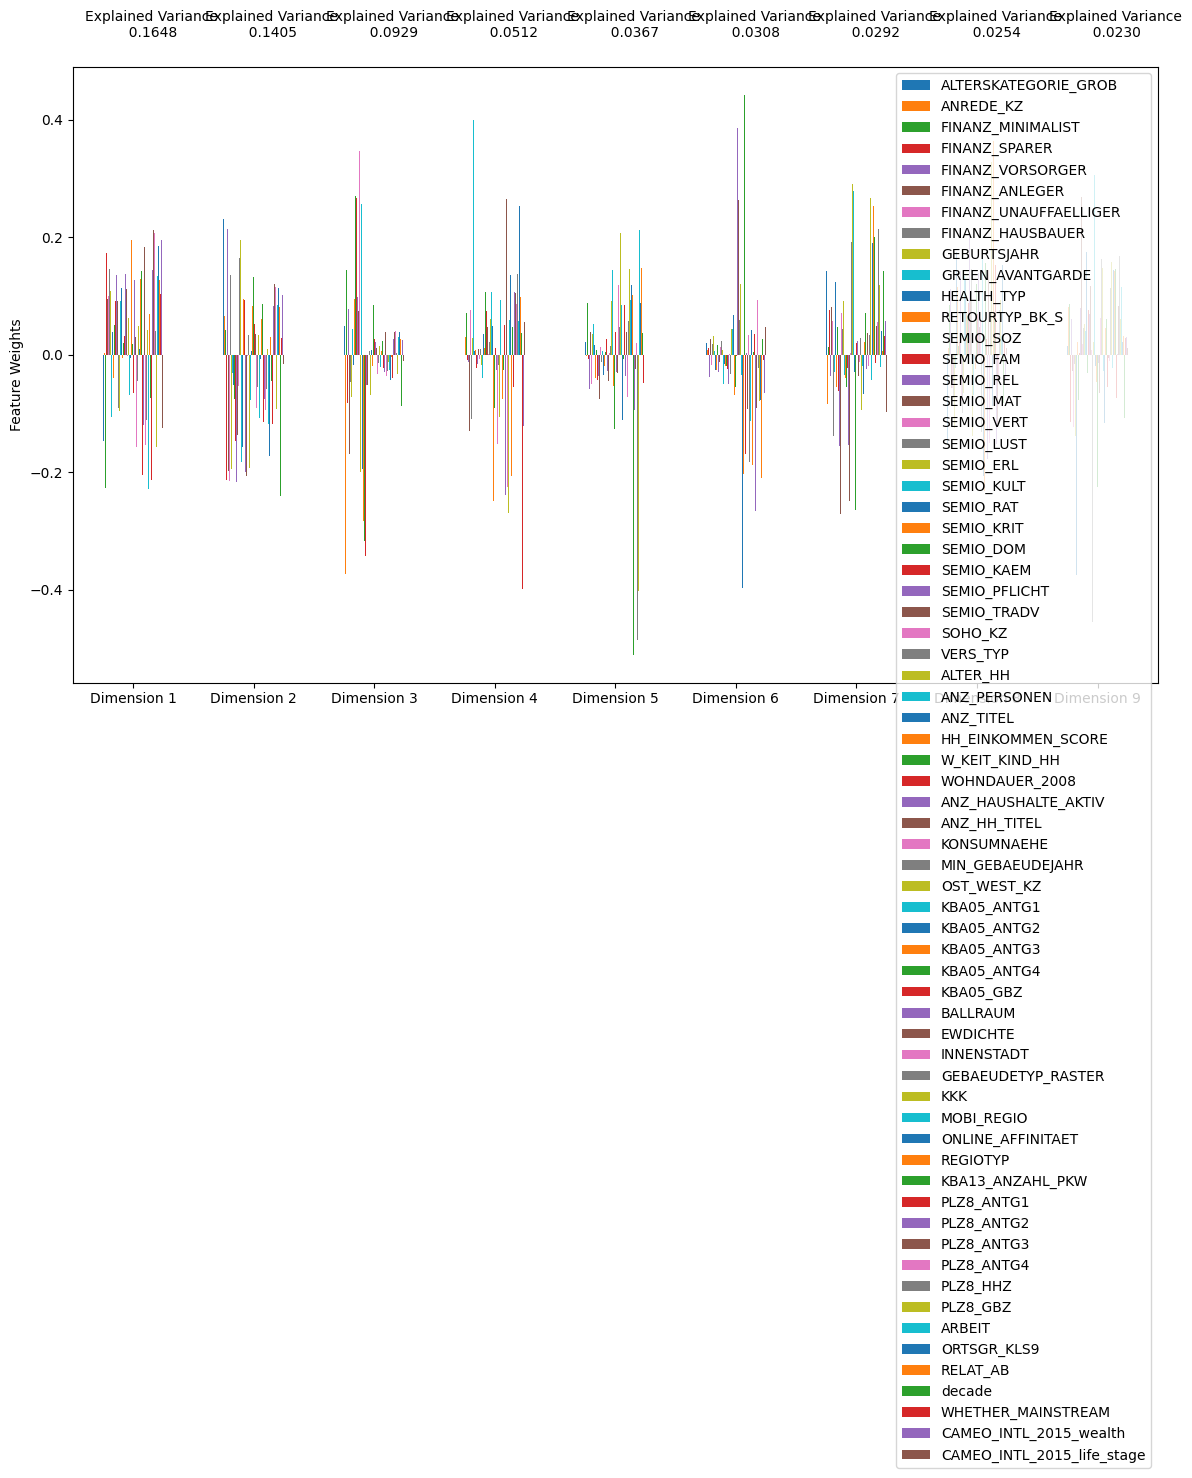

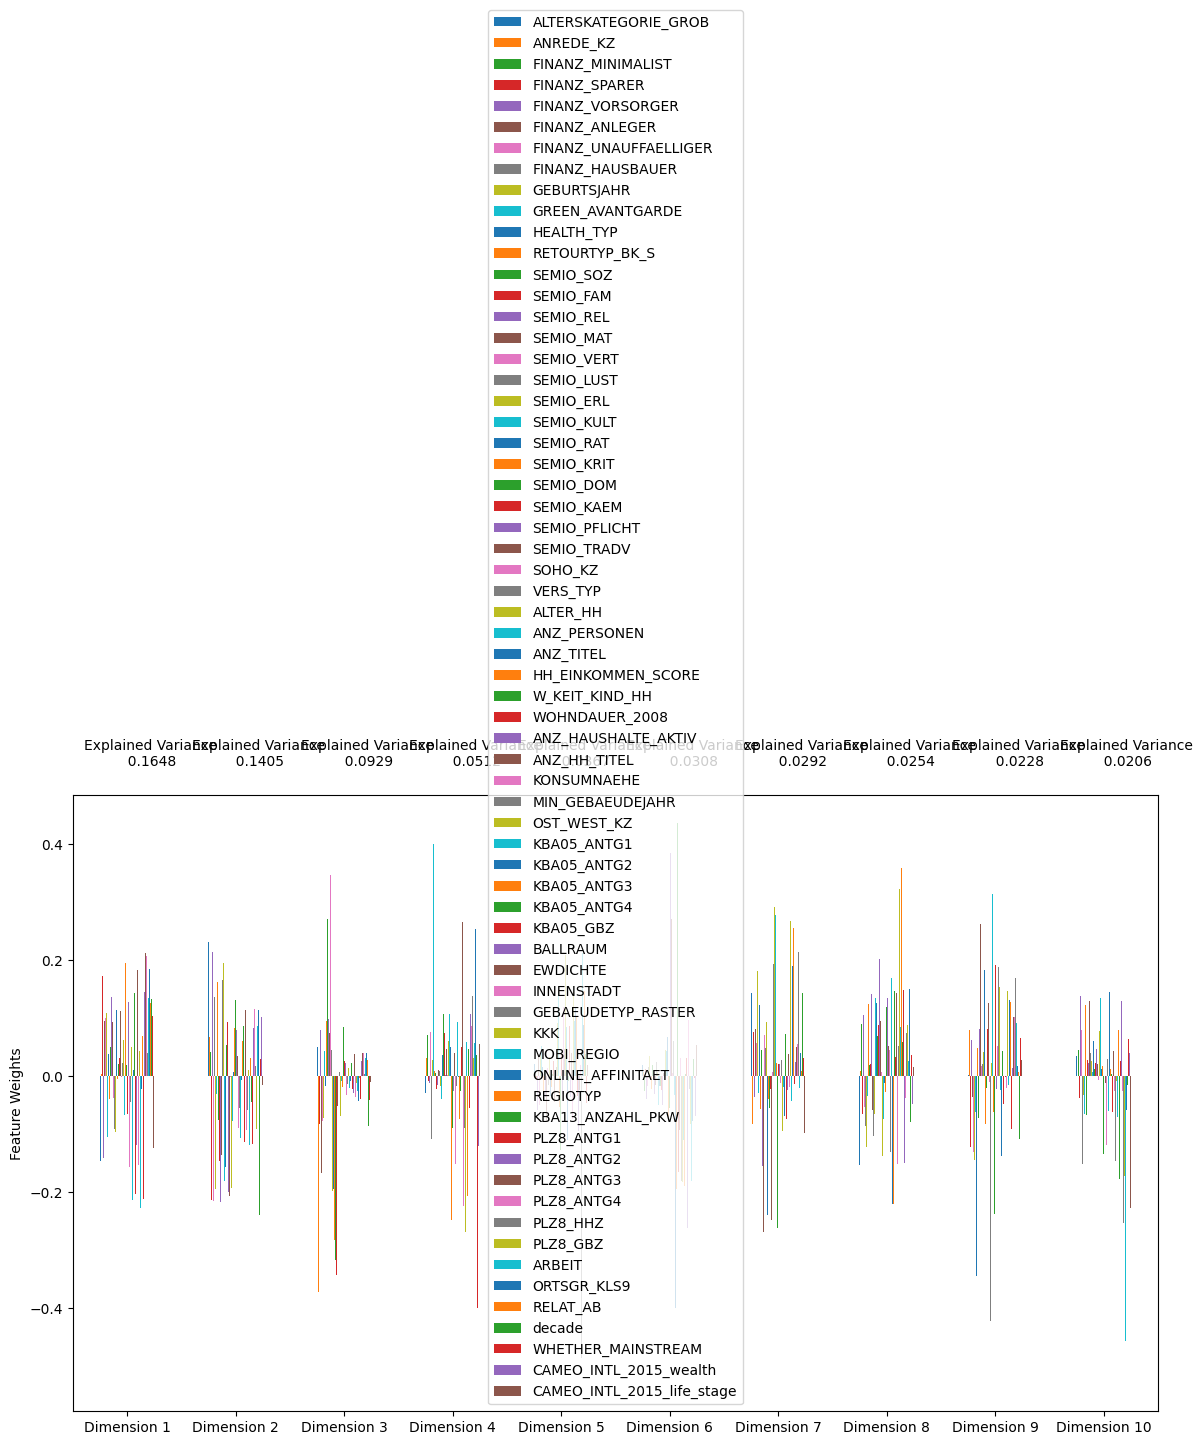

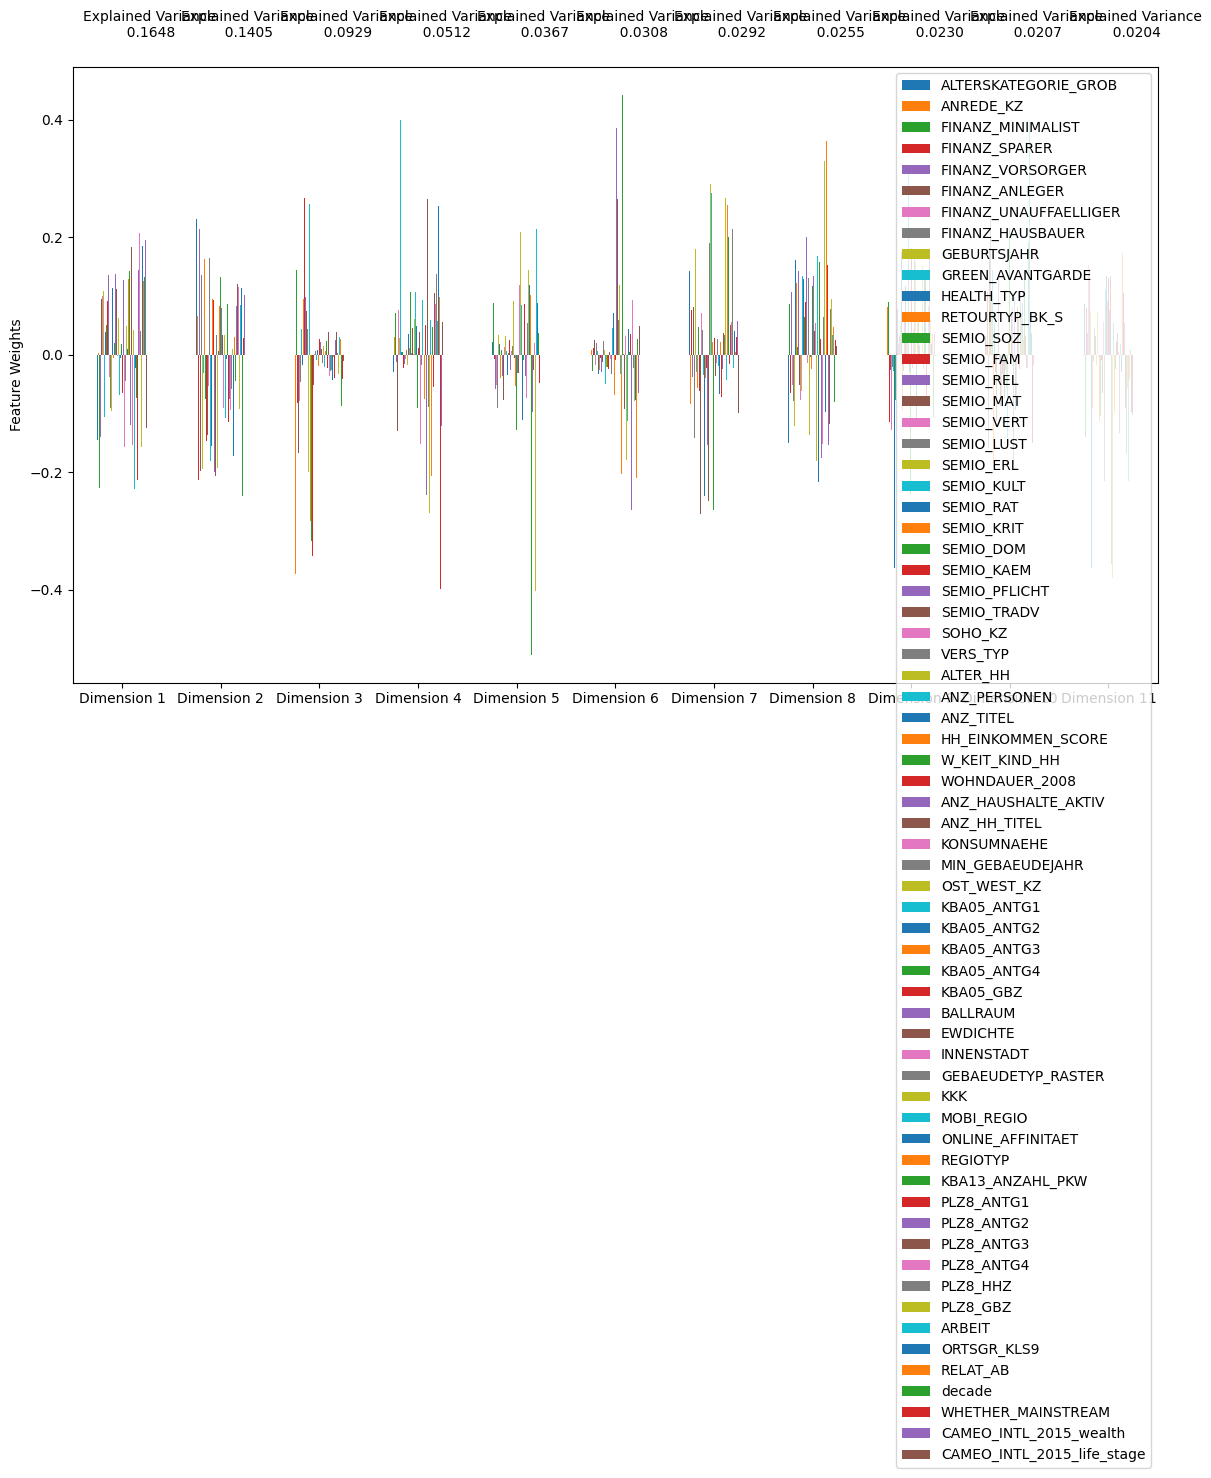

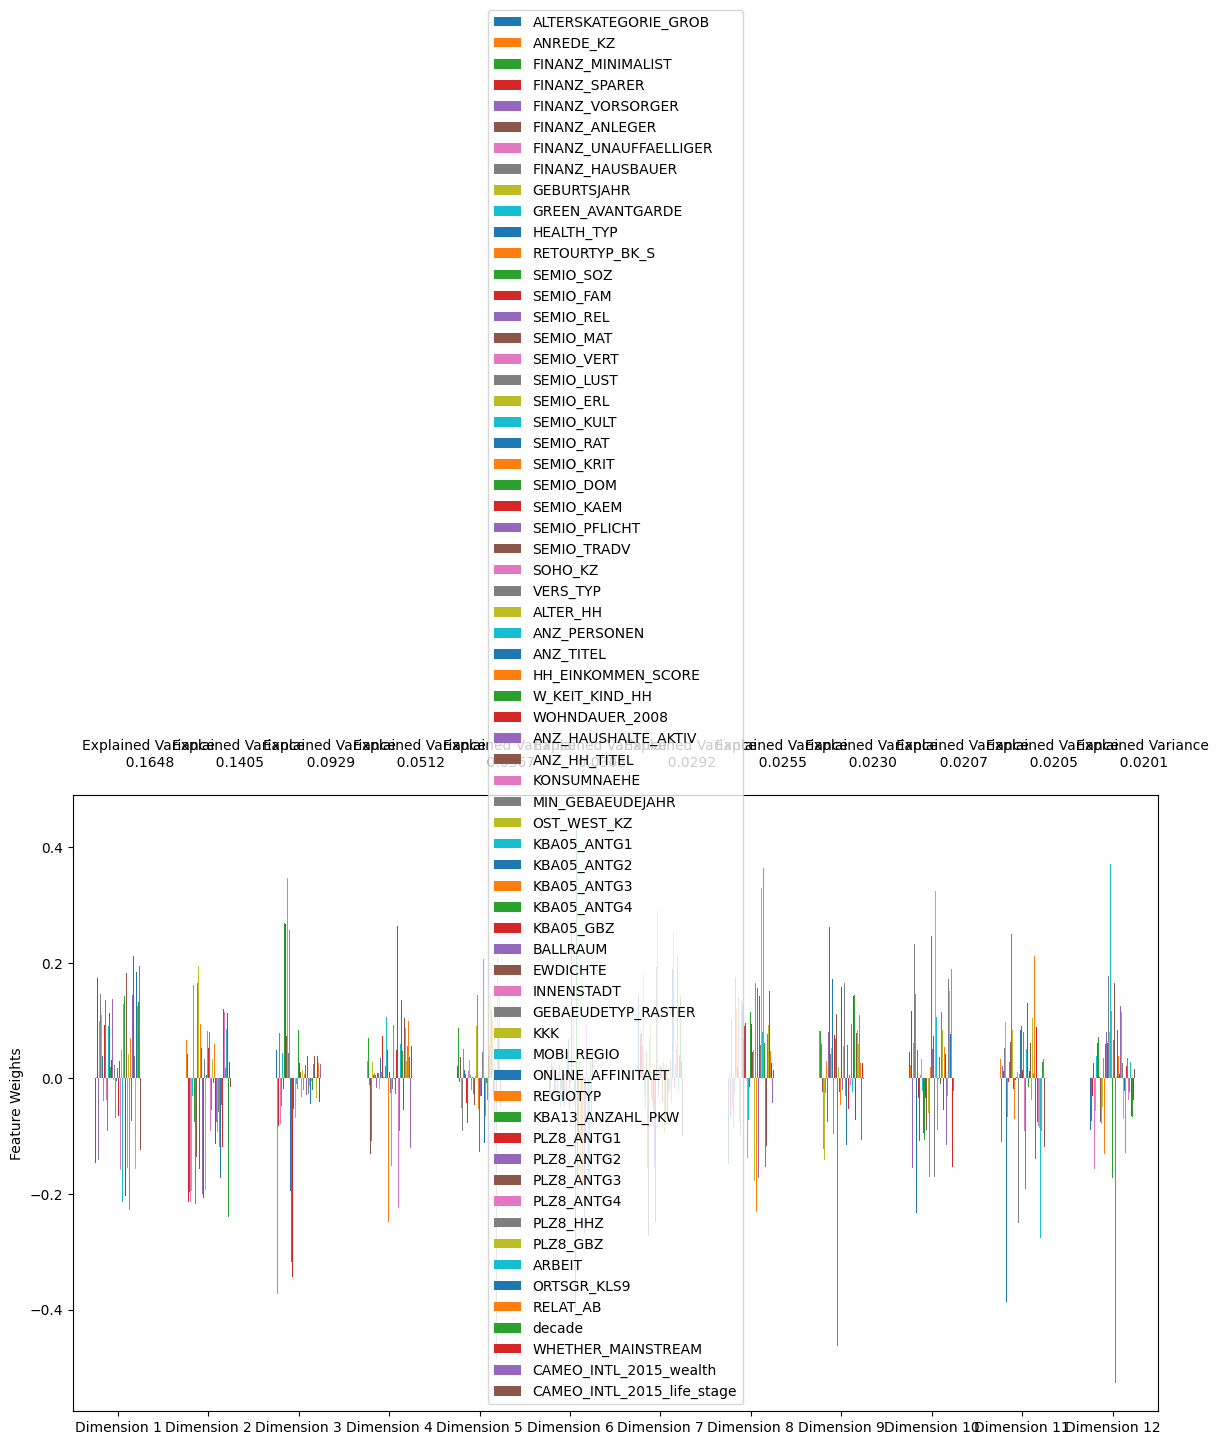

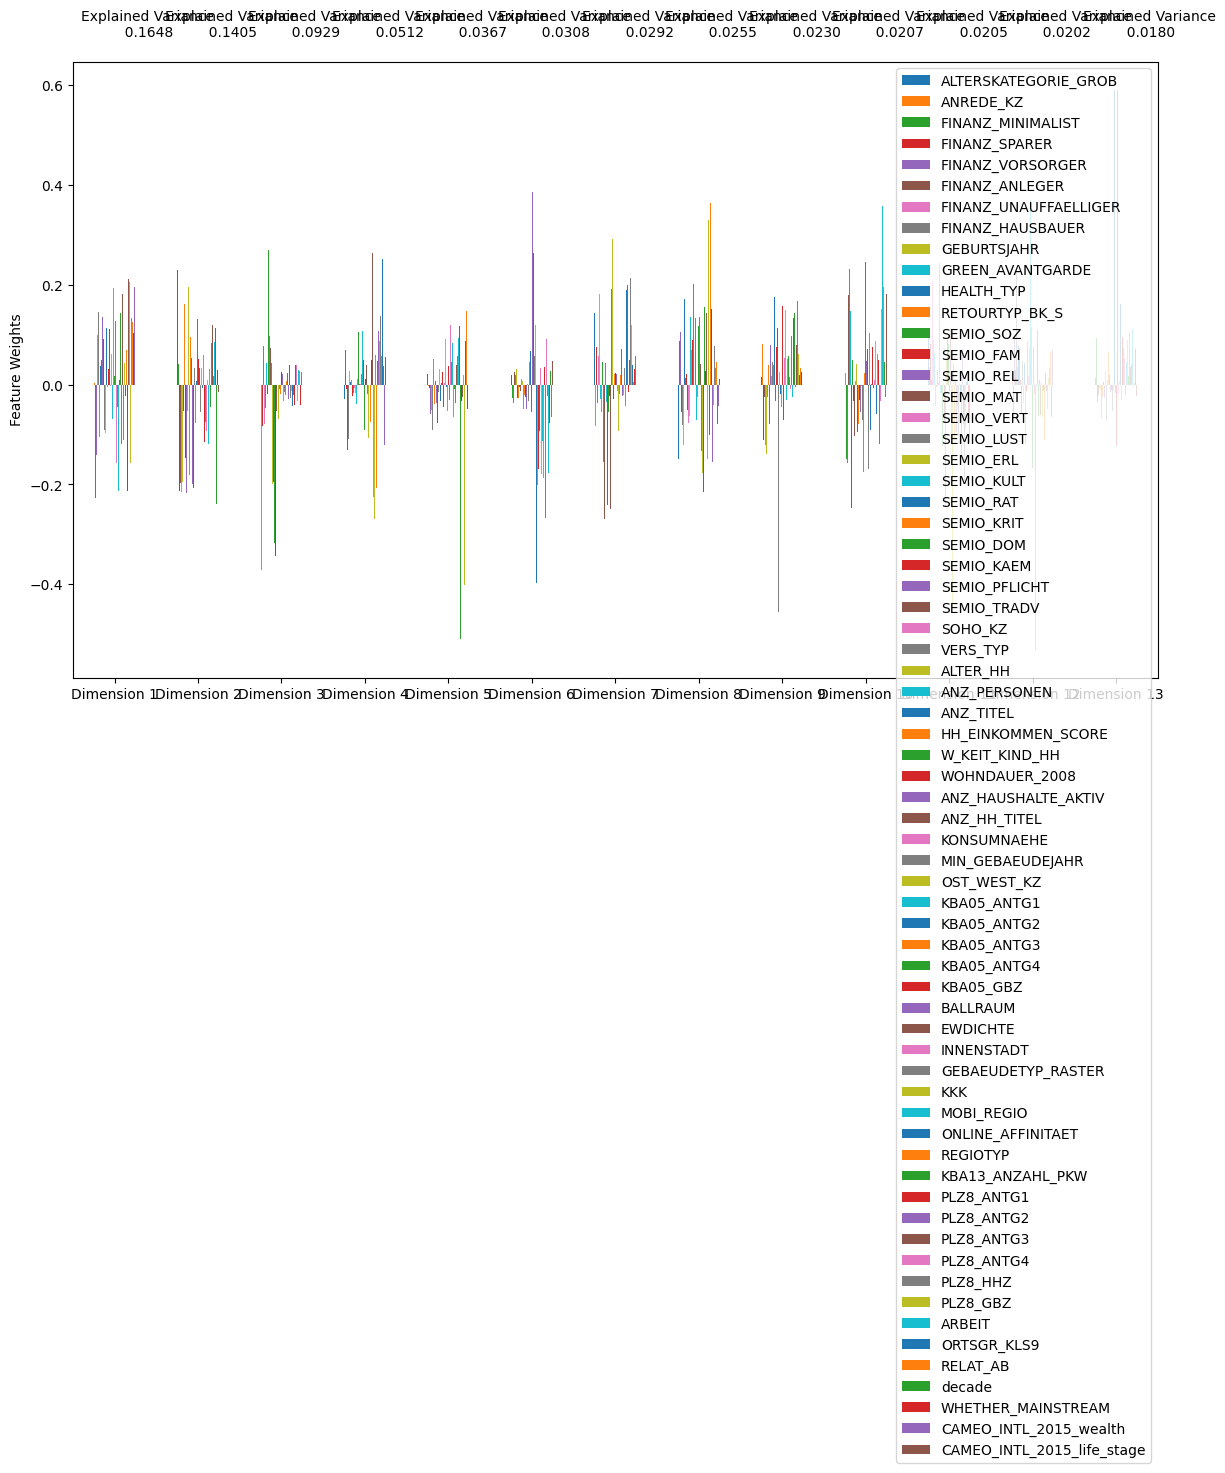

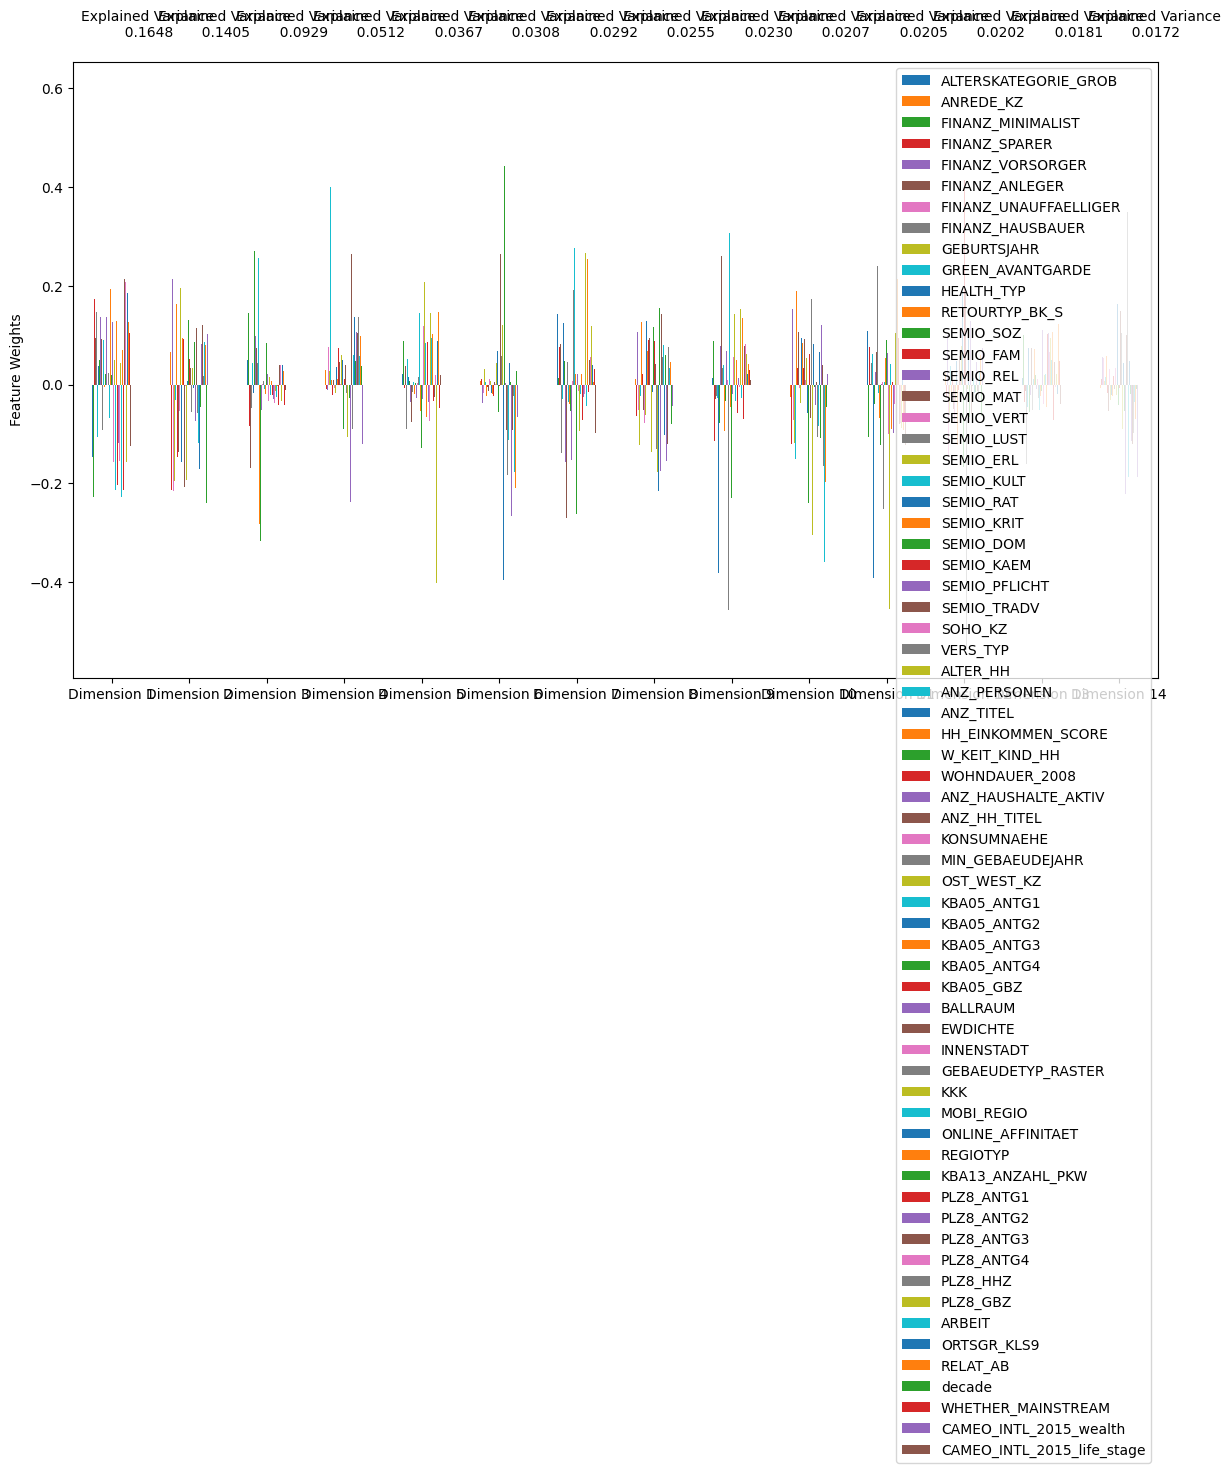

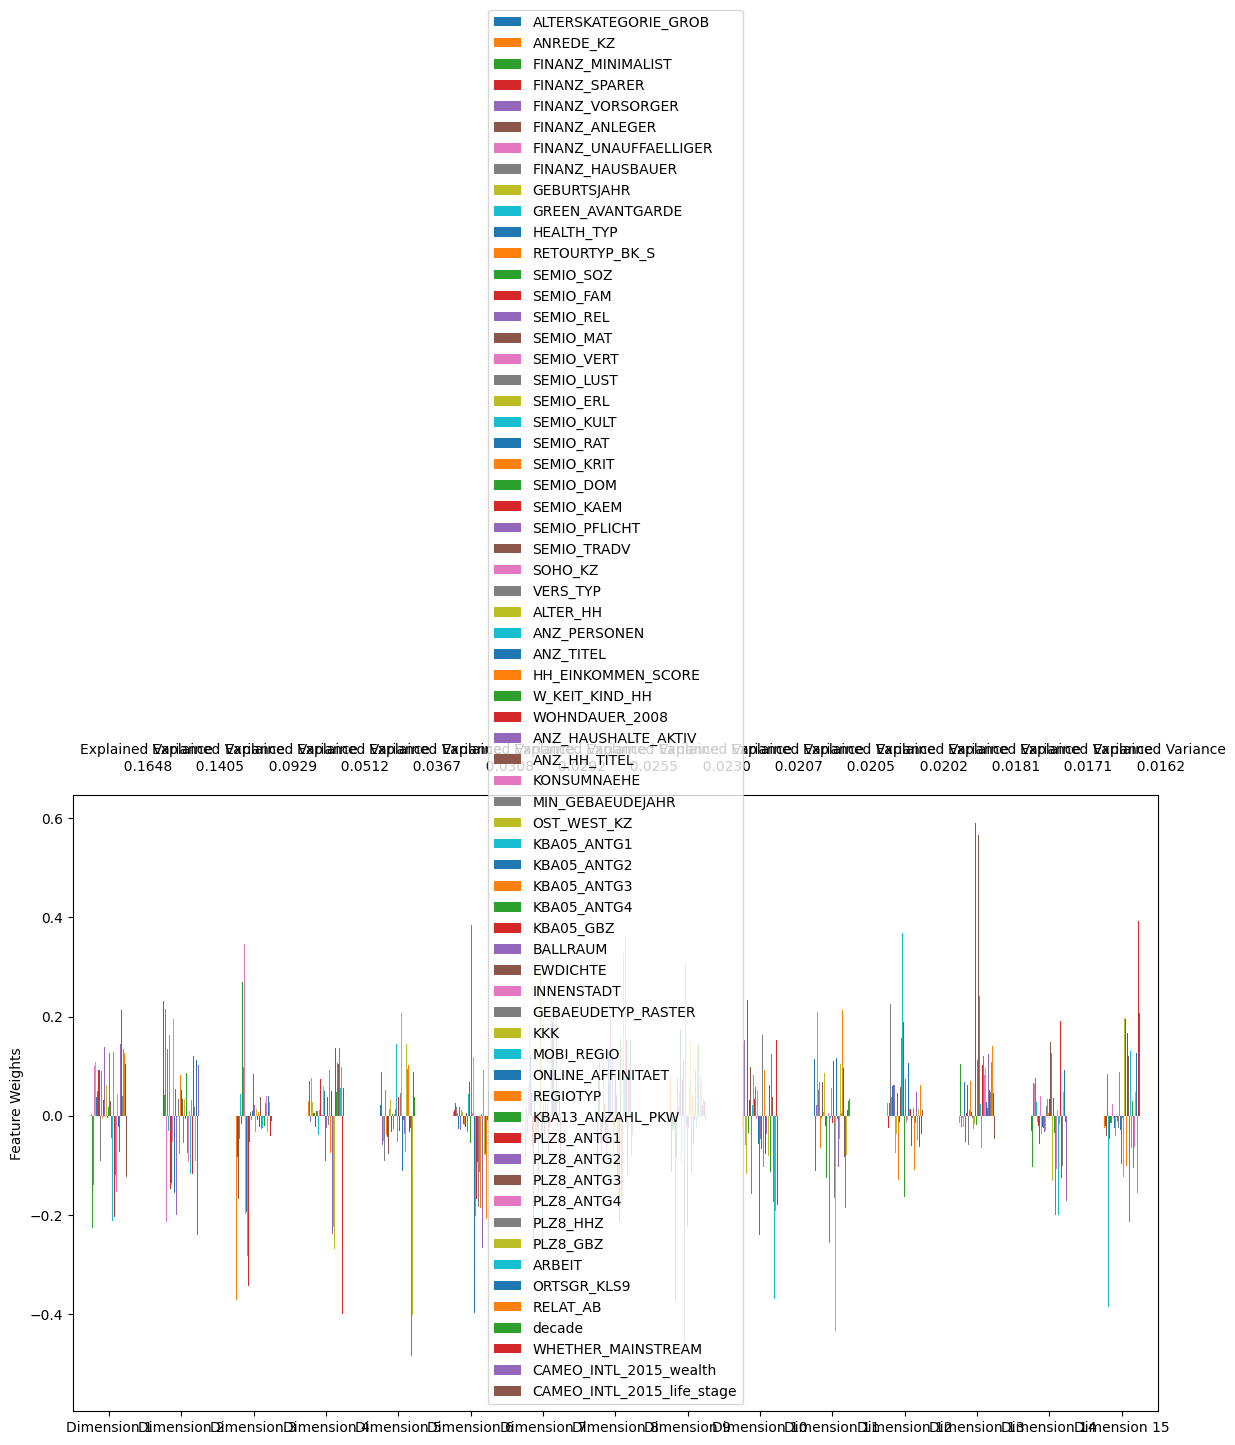

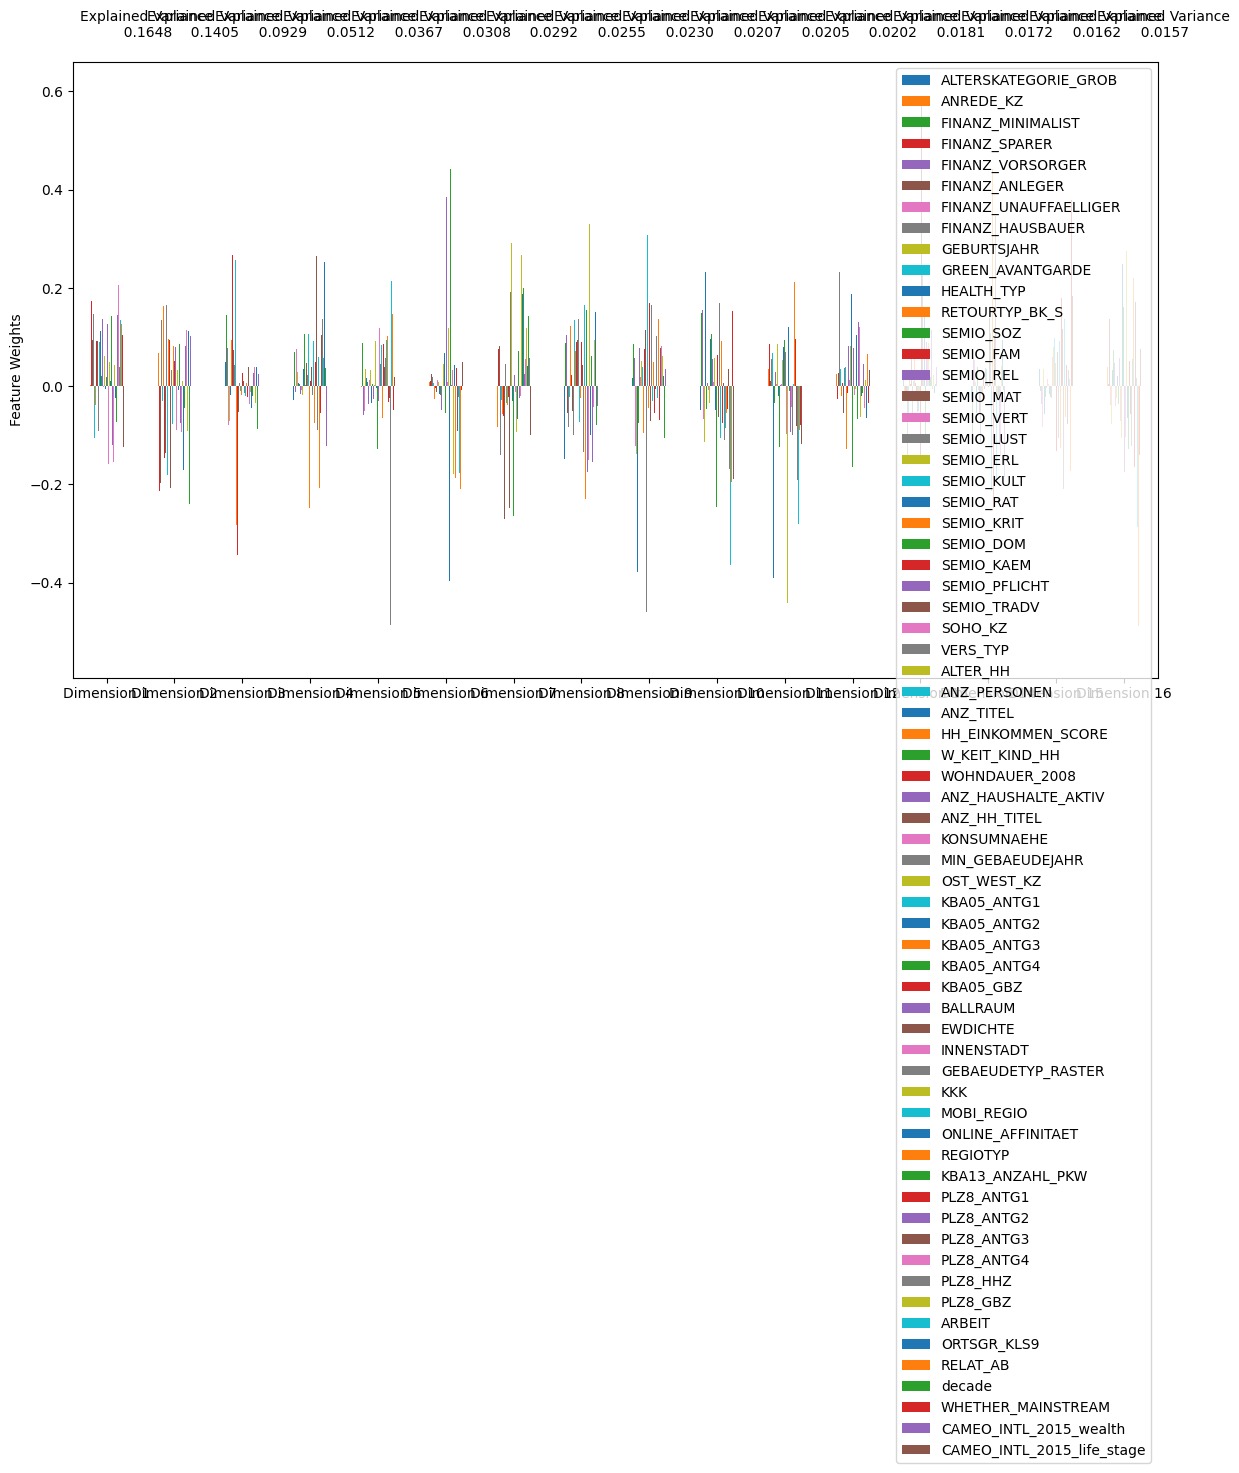

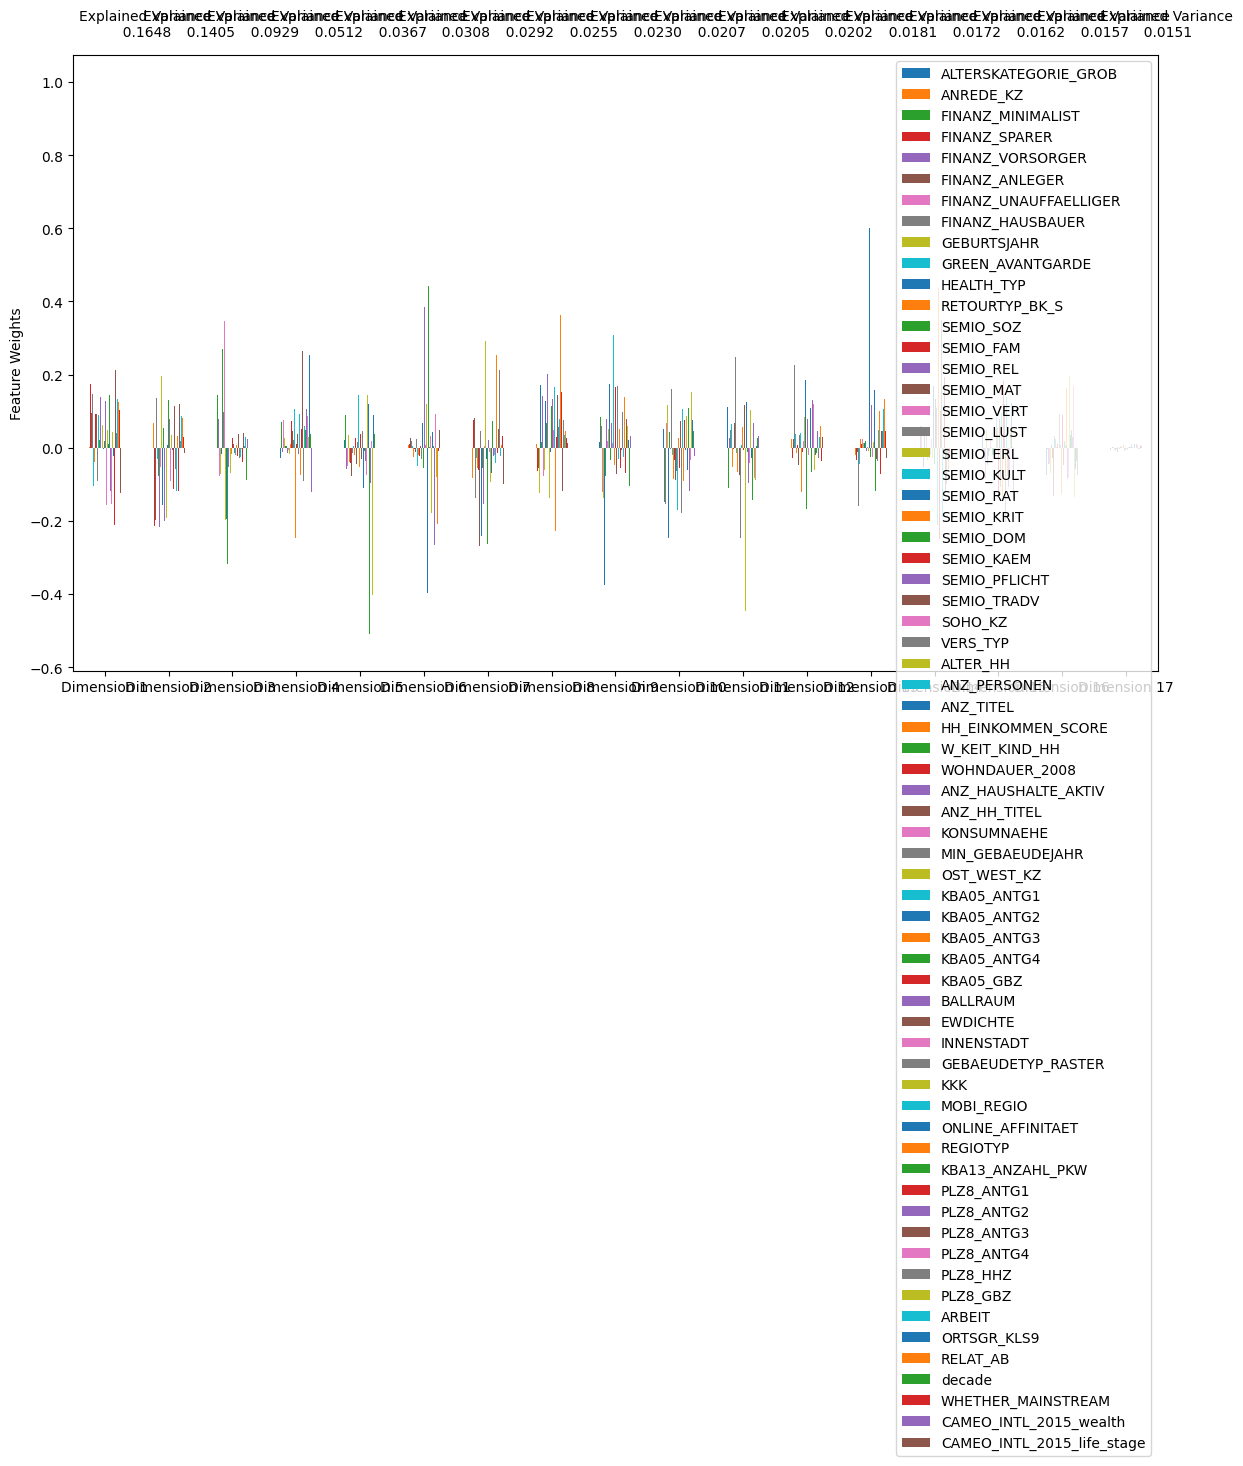

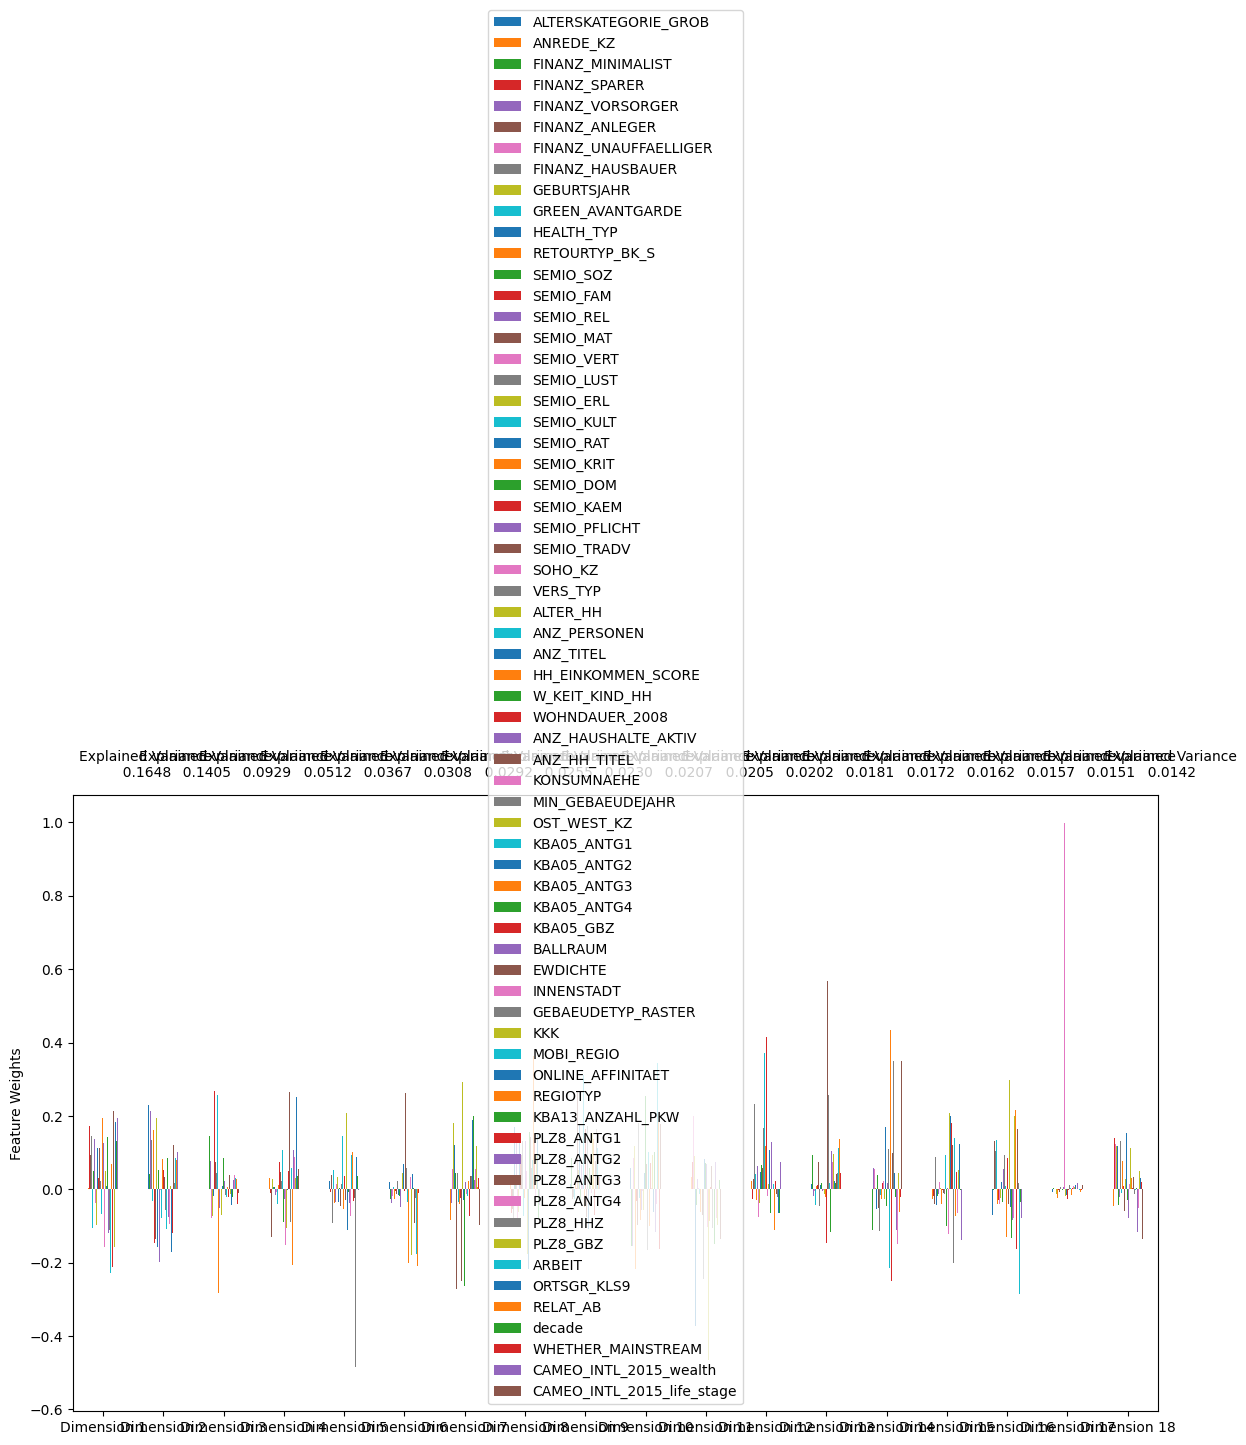

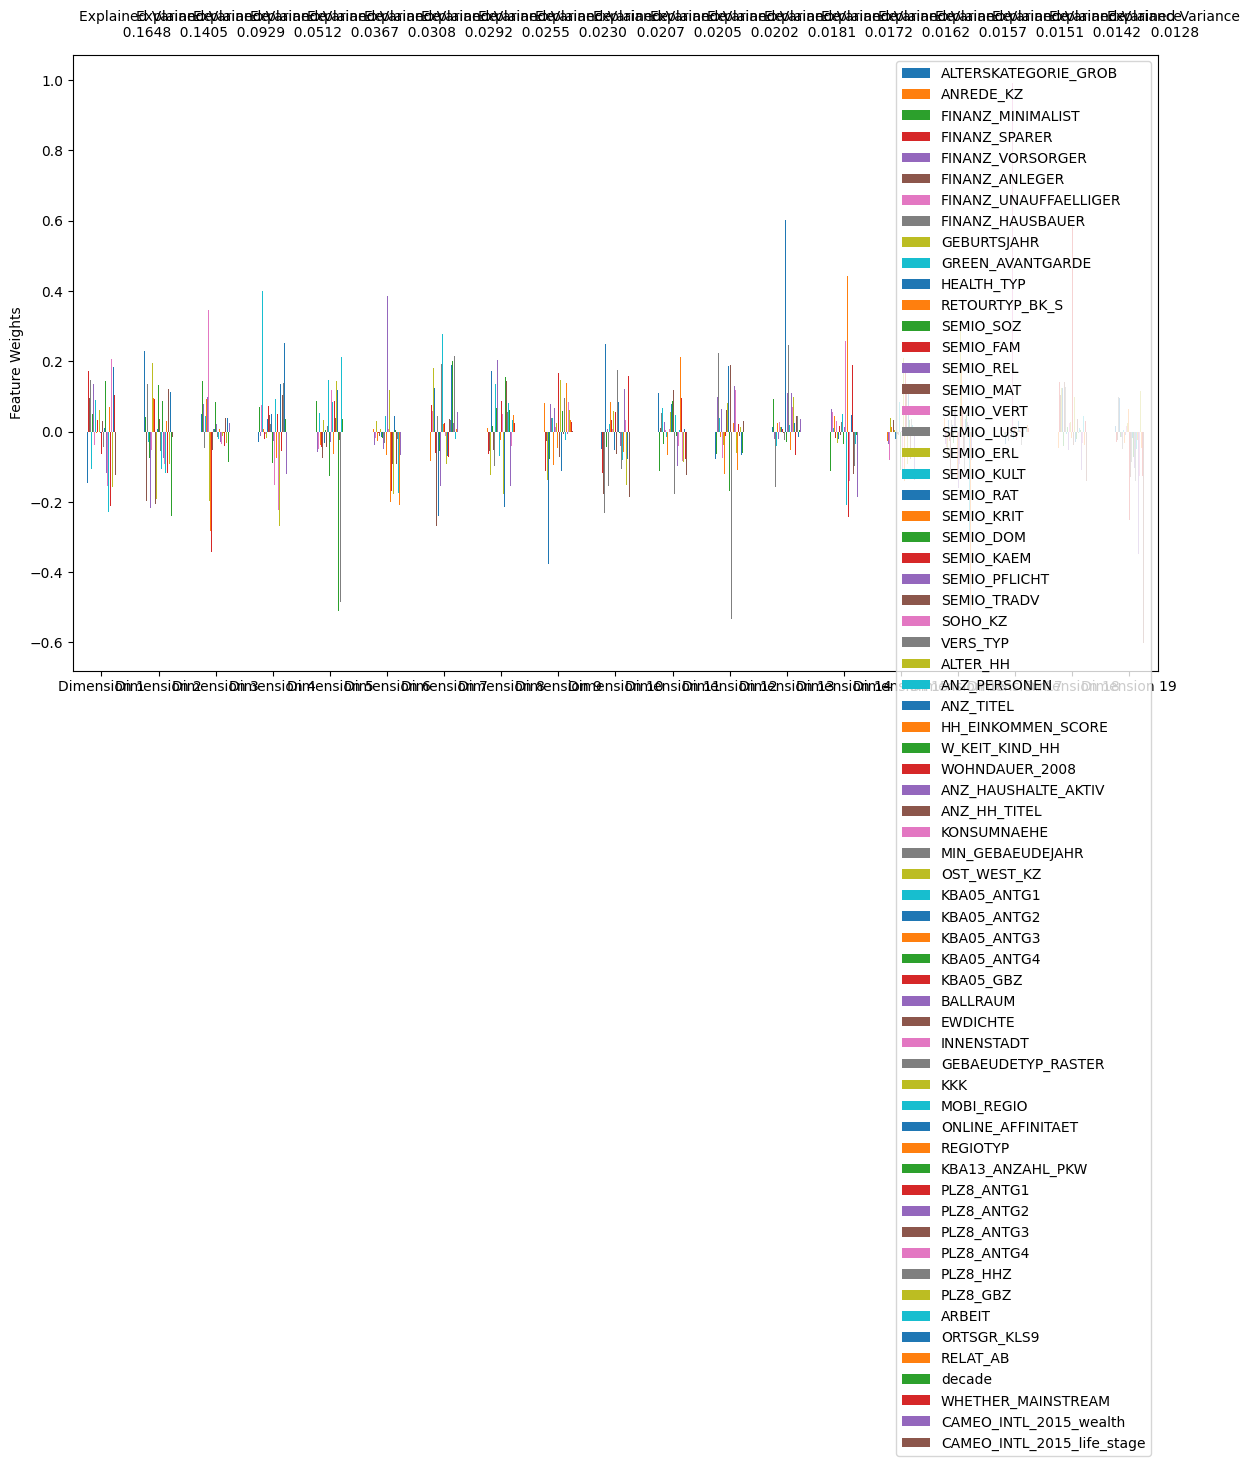

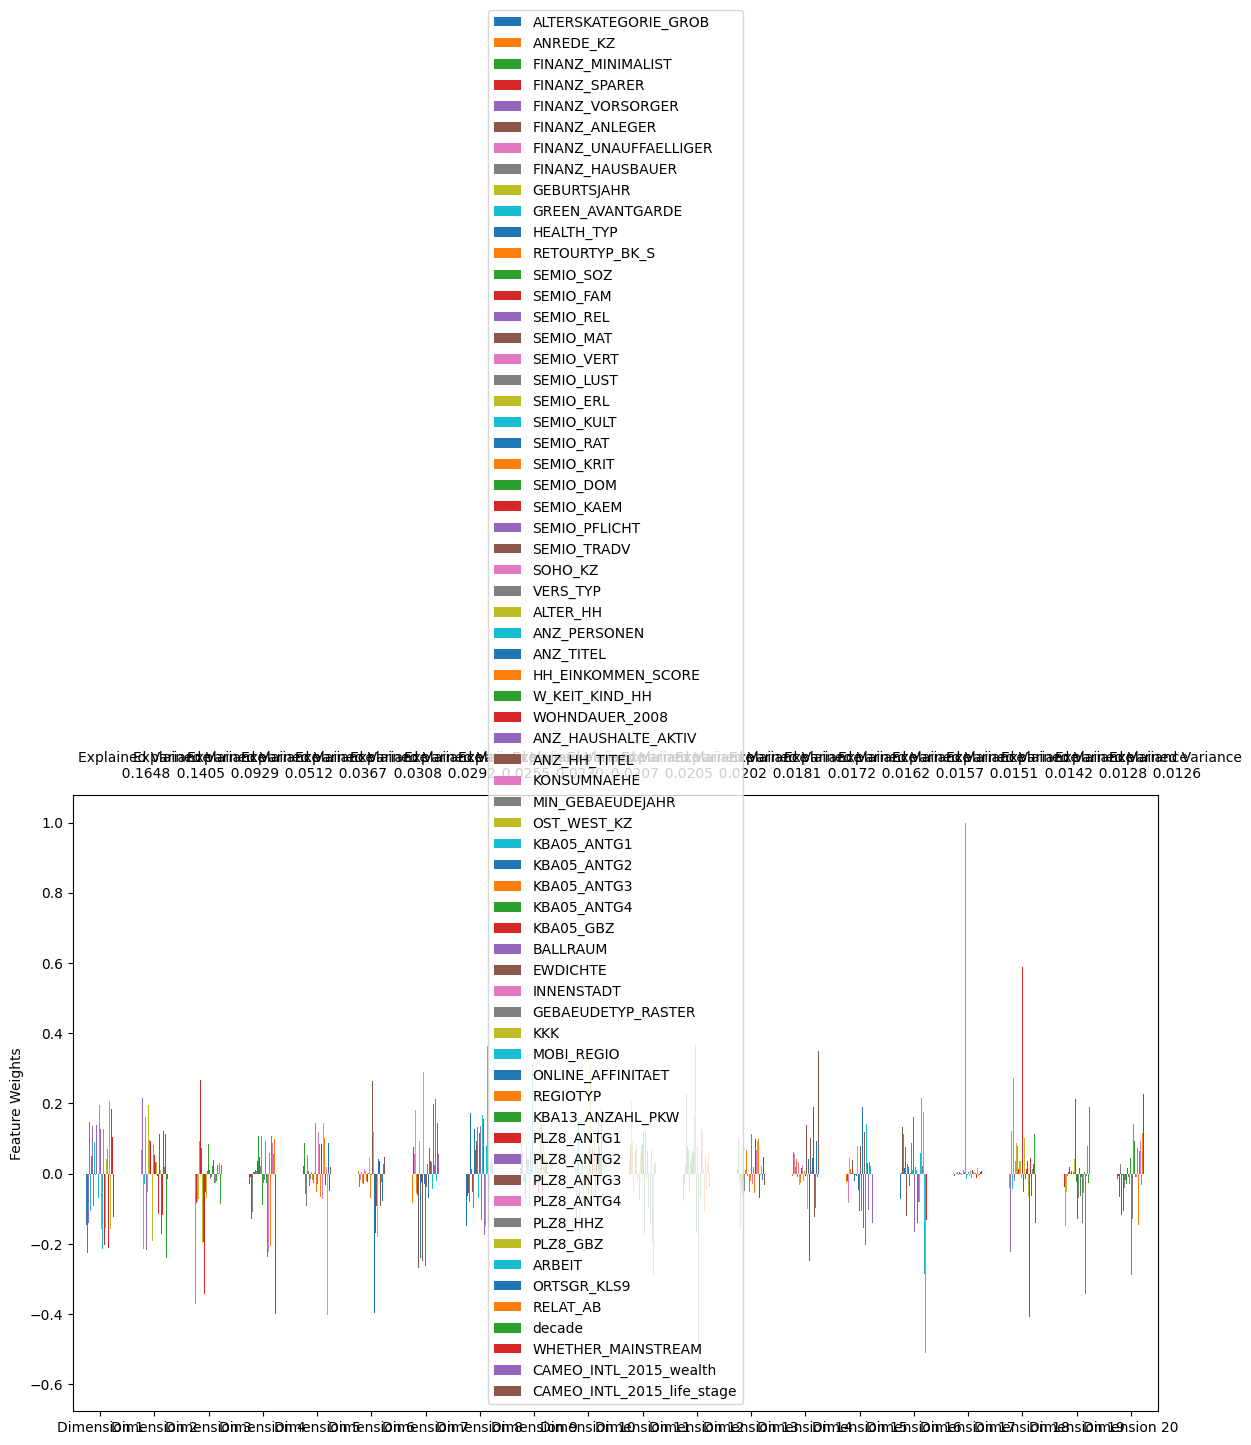

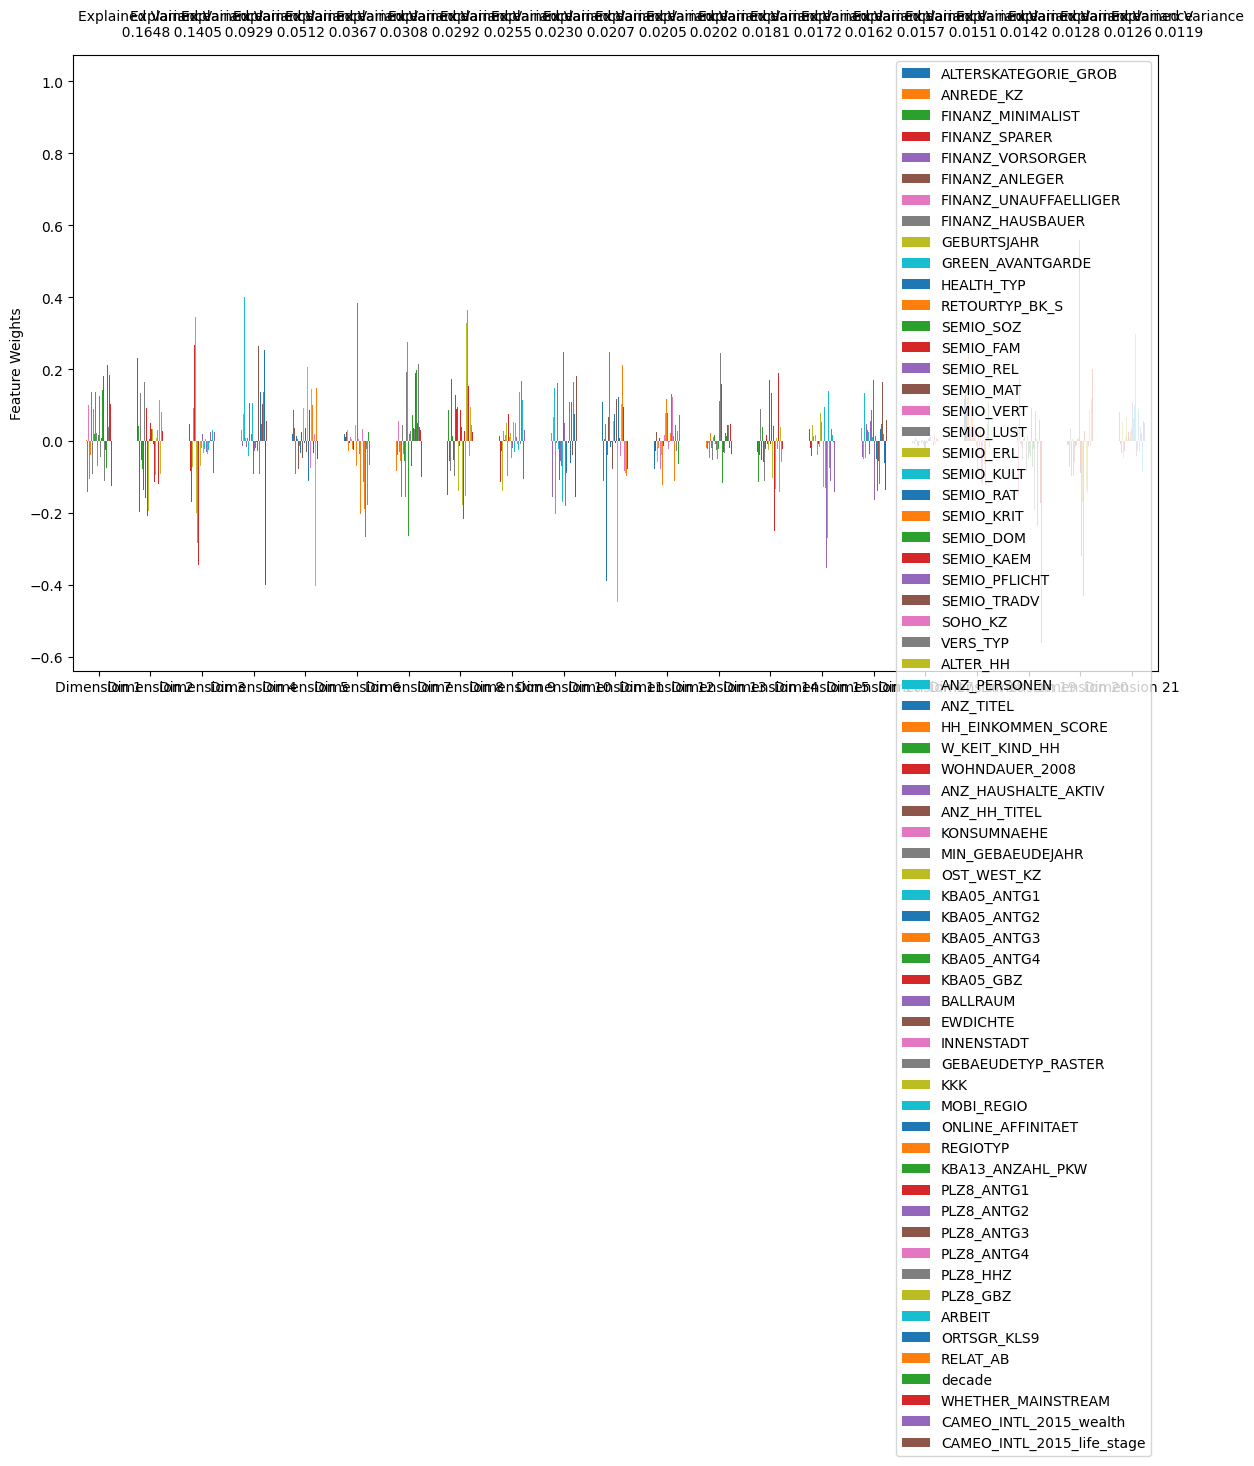

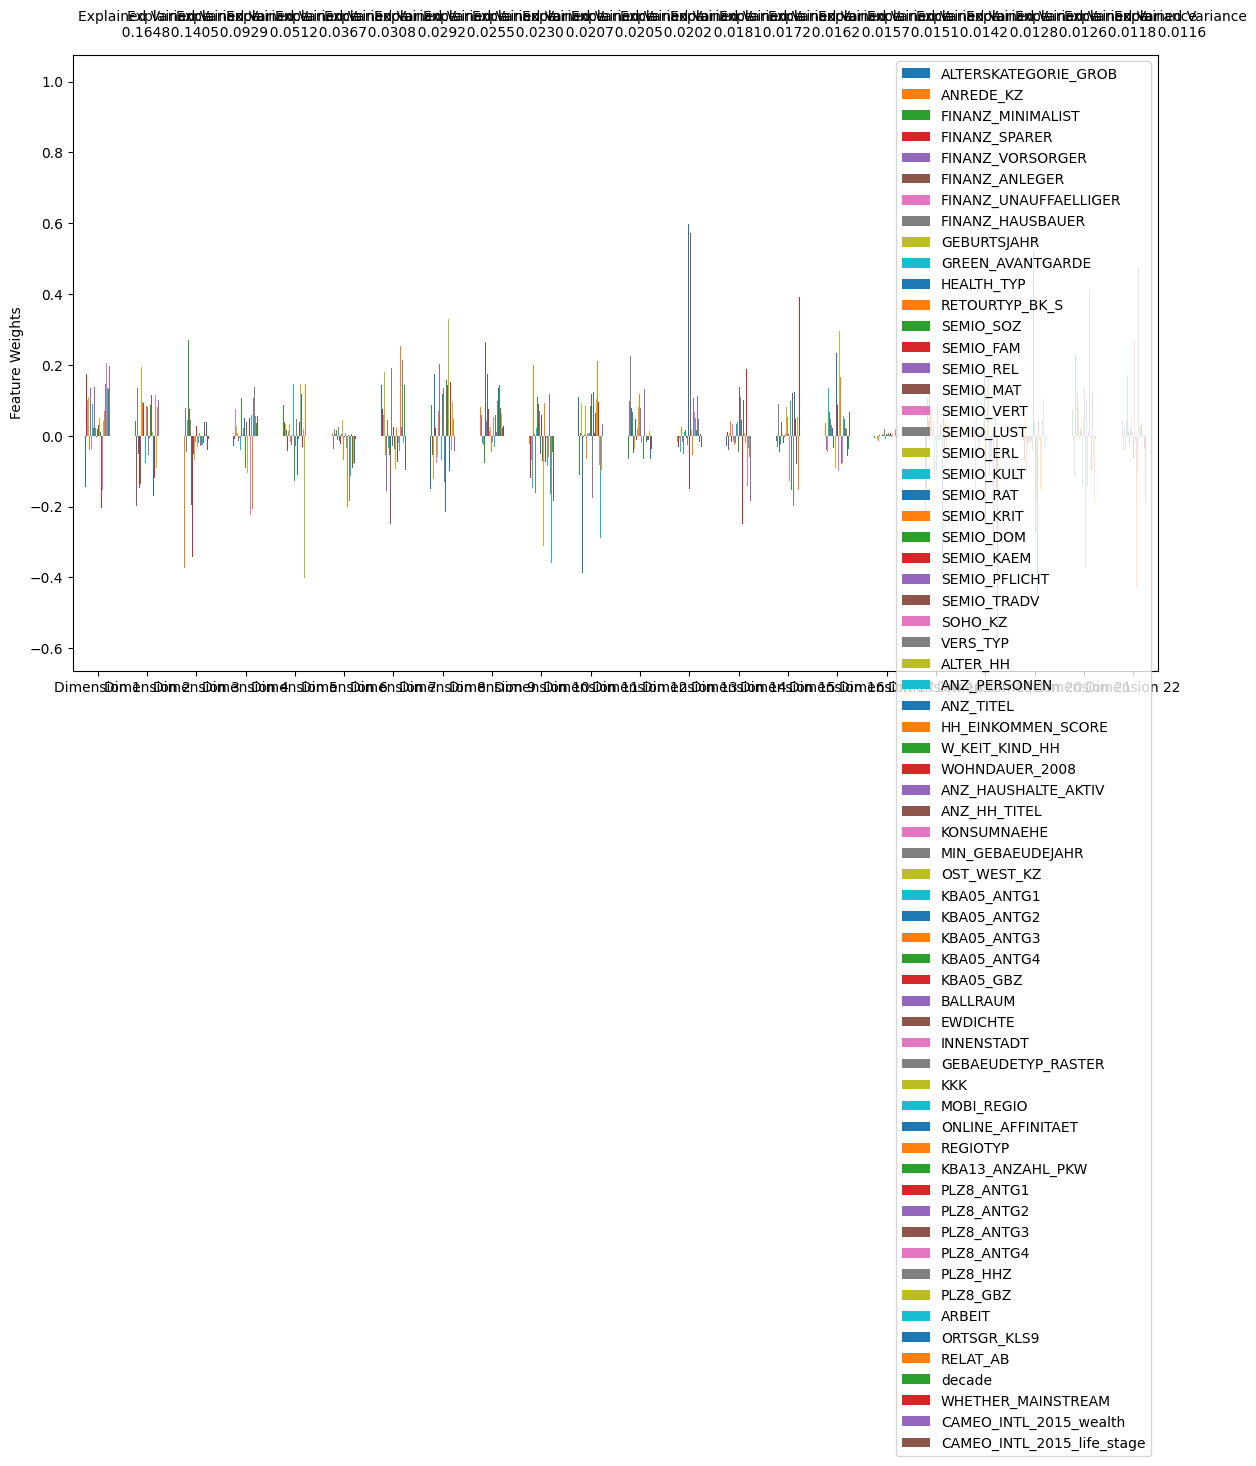

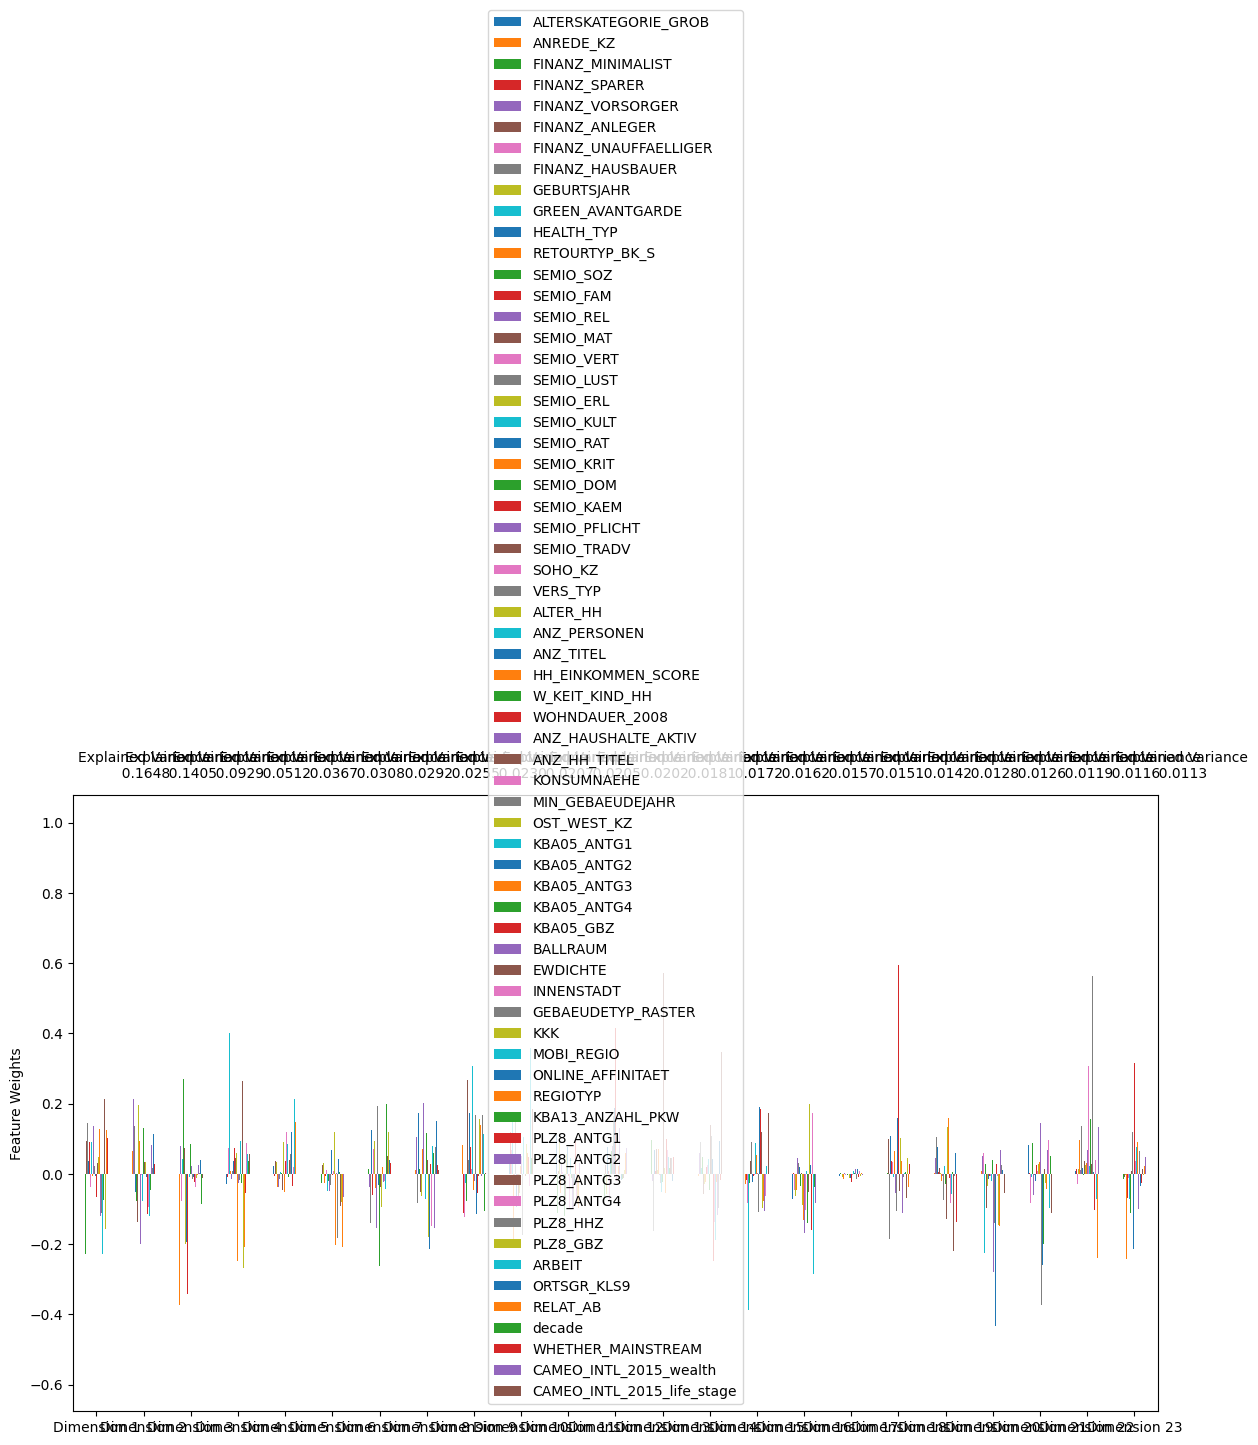

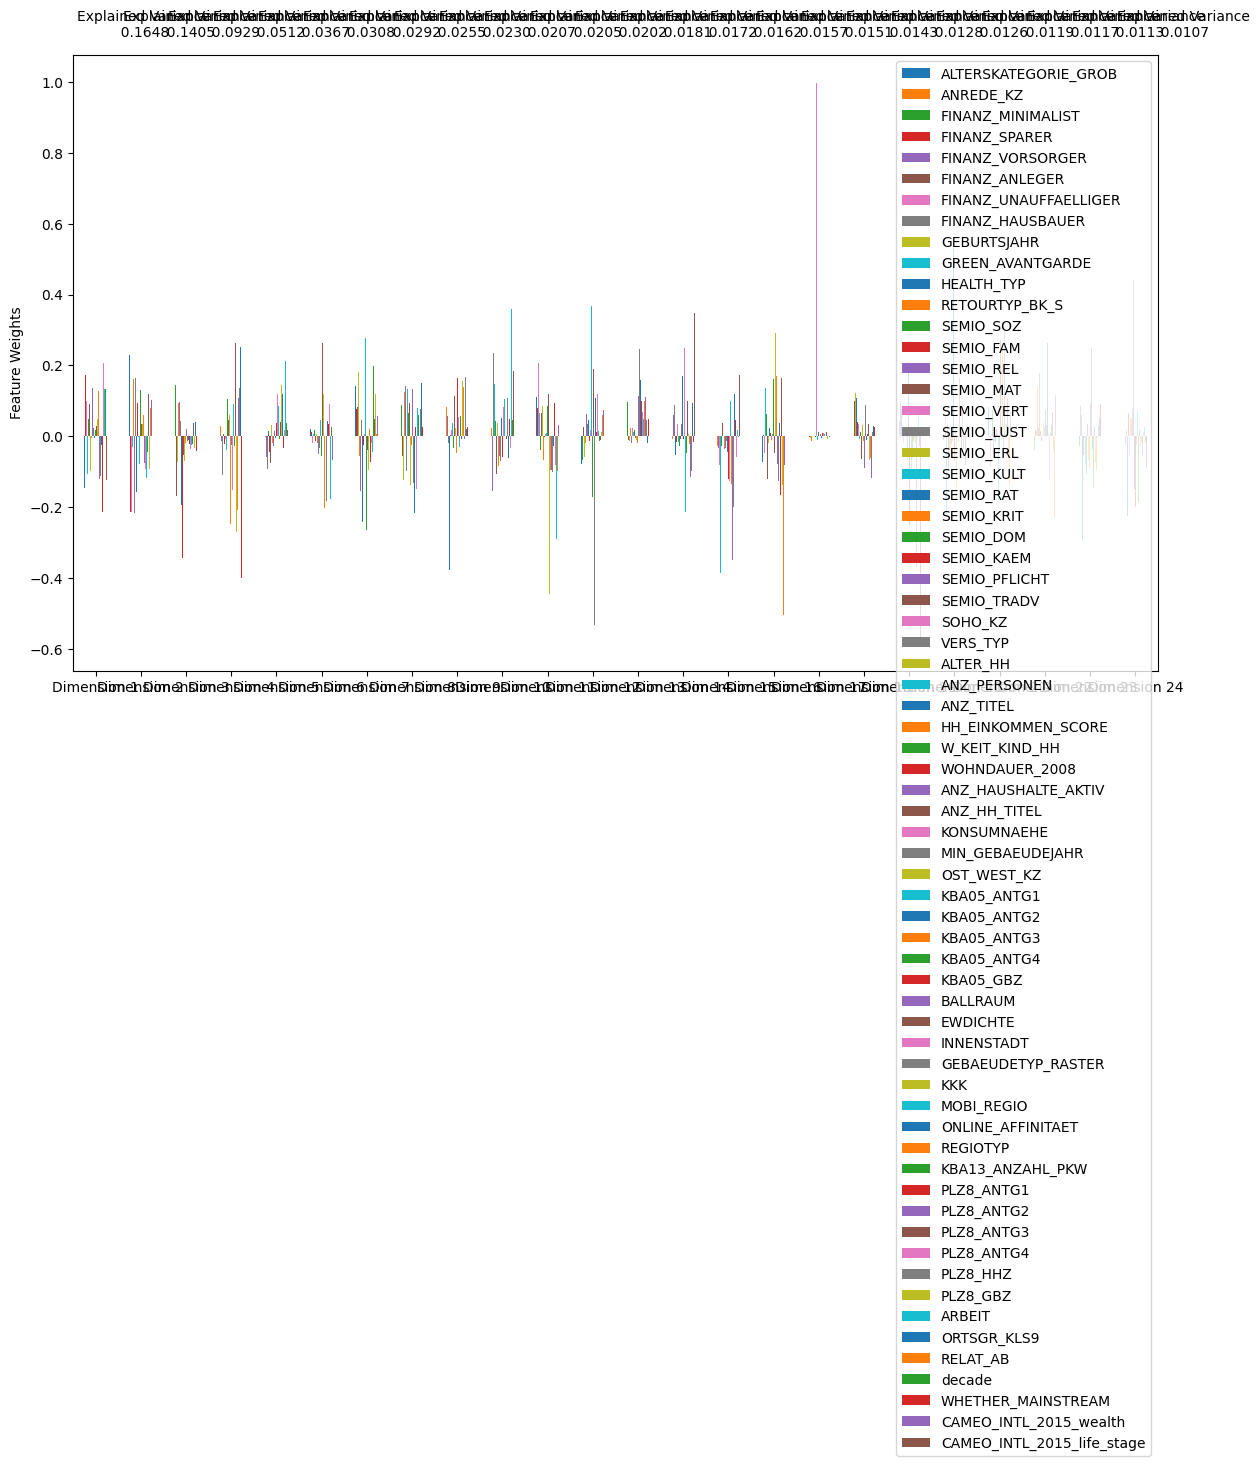

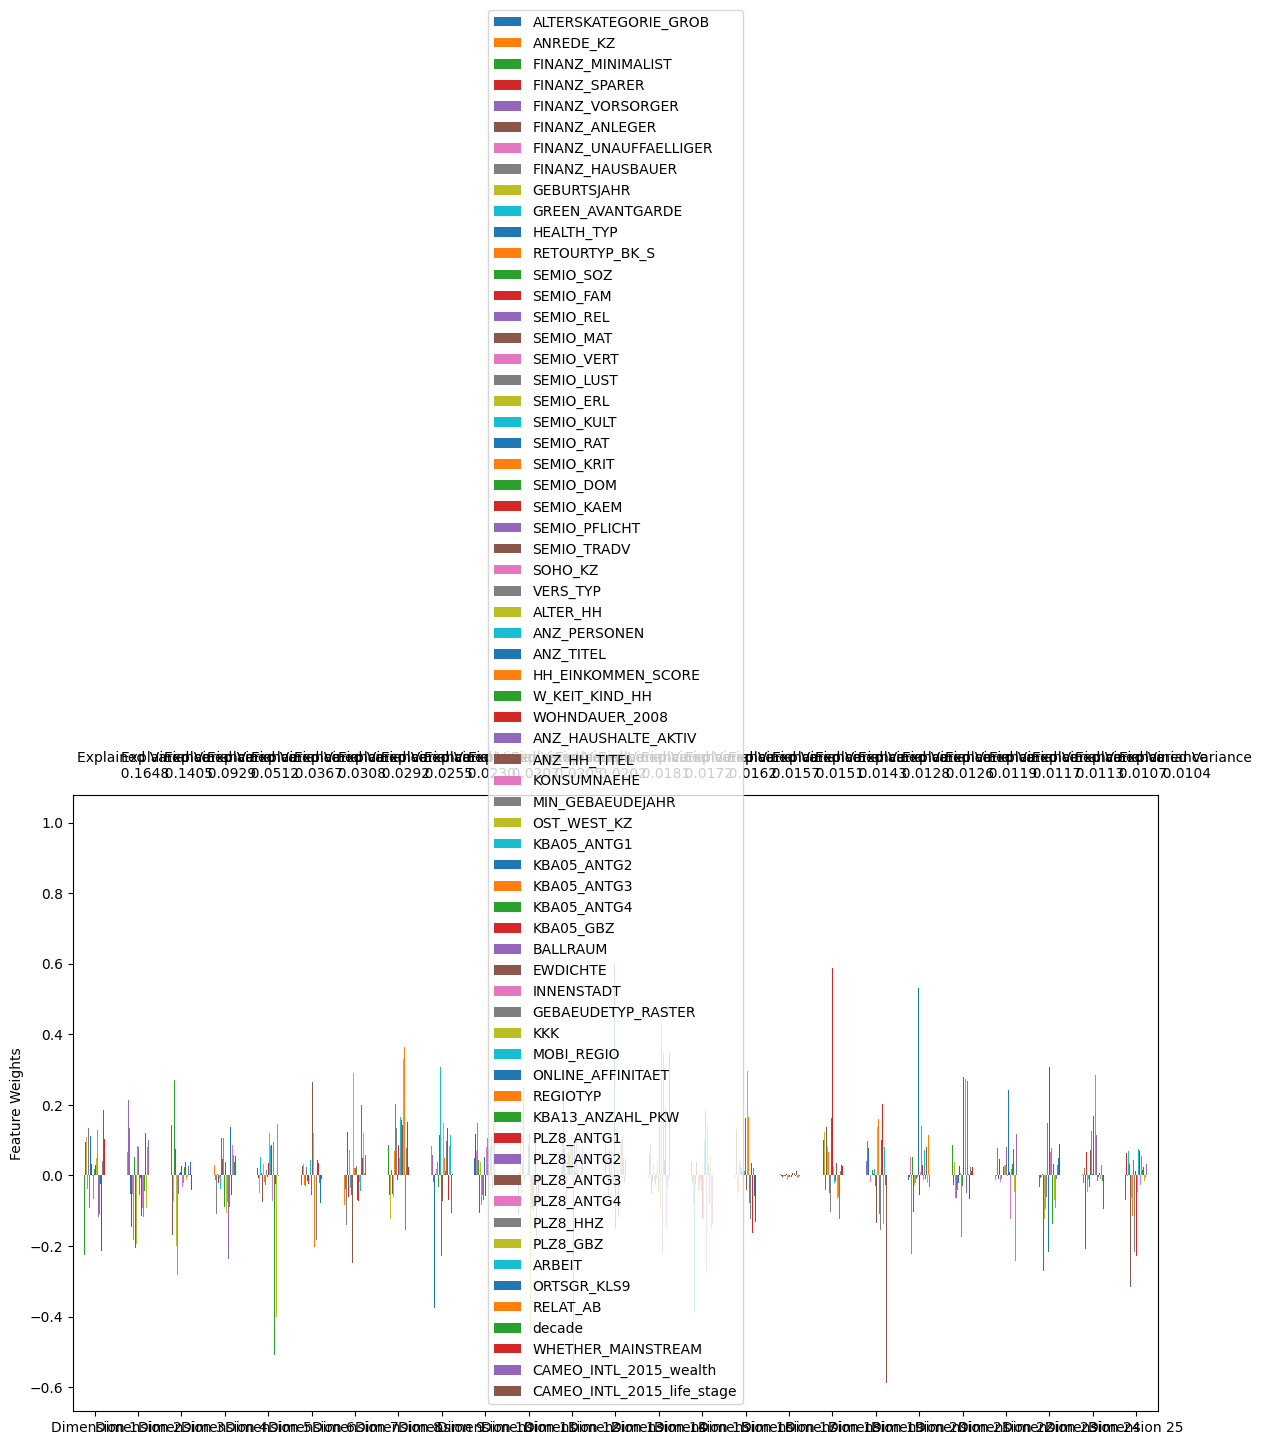

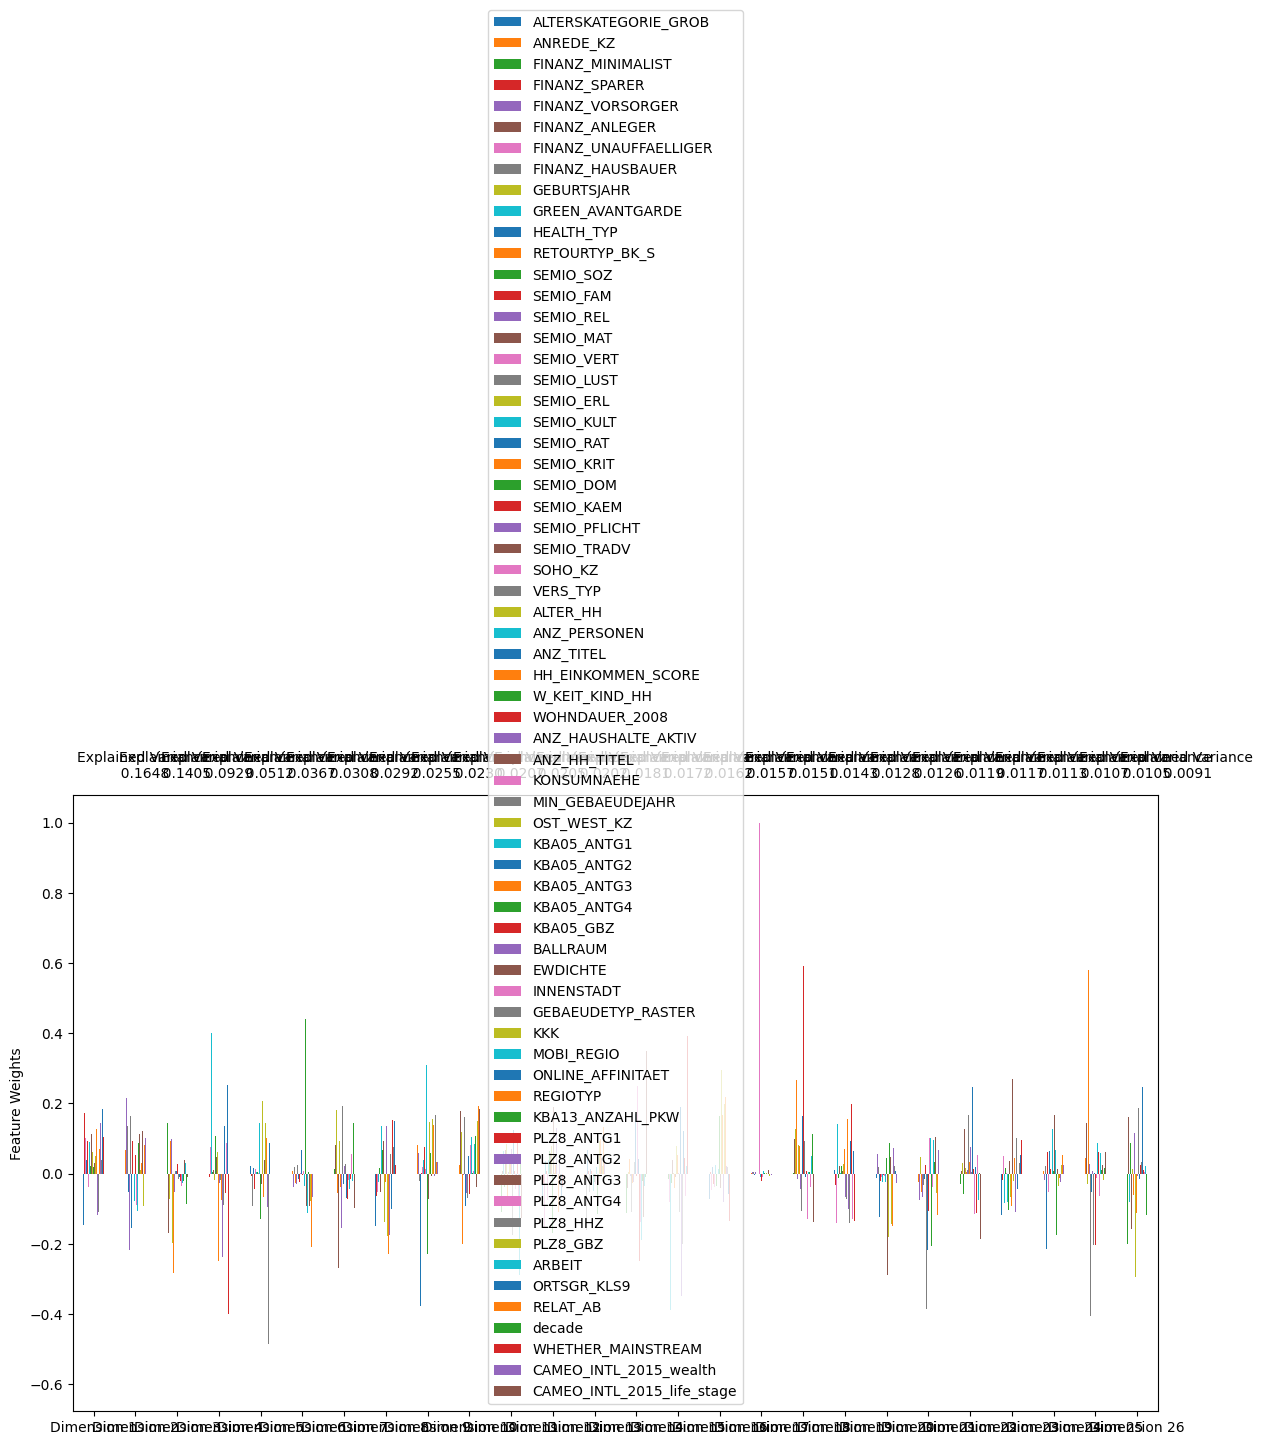

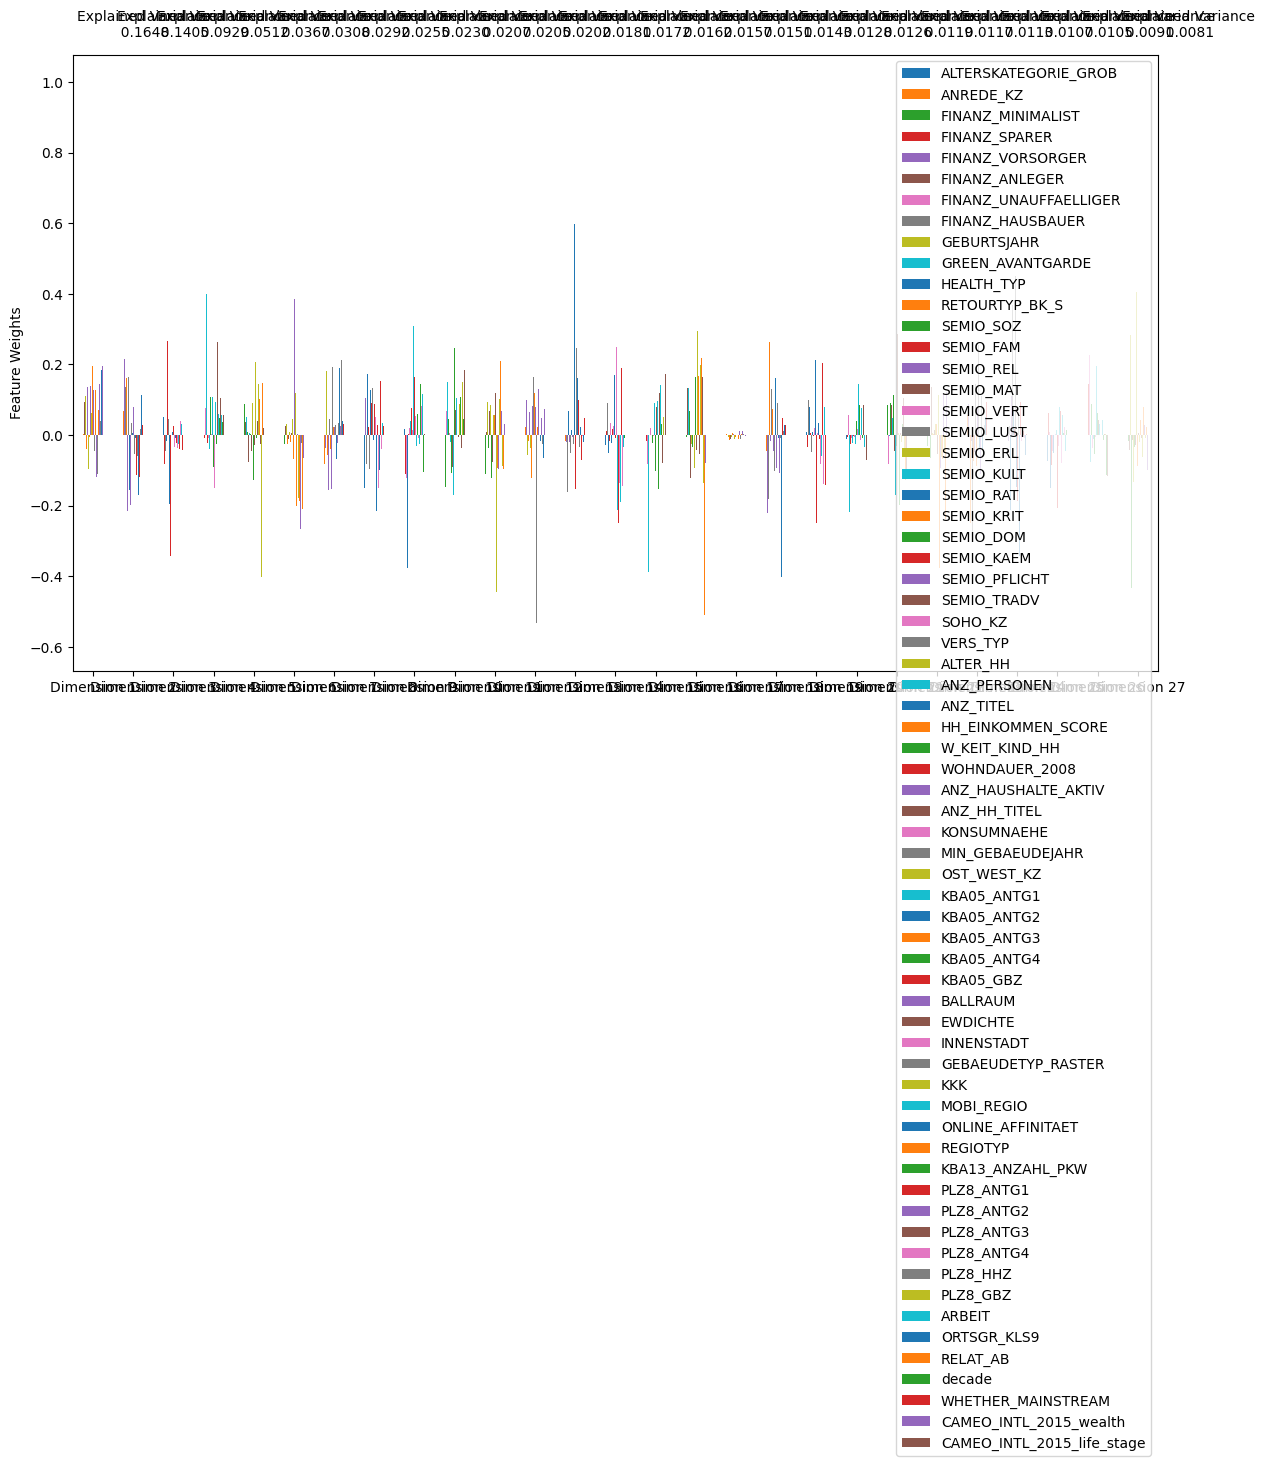

In [20]:
for comp in range(3, 40):
    pca, pca_X = do_pca(comp, scaled_df)
    comp_check = pca_results(scaled_df, pca)
    if comp_check['Explained Variance'].sum() > 0.85:
        break
        

num_comps = comp_check.shape[0]
print("Using {} components, we can explain {}% of the variability in the original data.".format(comp_check.shape[0],comp_check['Explained Variance'].sum()))

In [14]:
# Re-apply PCA to the data while selecting for number of components to retain.
pca, pca_X = do_pca(27, scaled_df)
np.cumsum(pca.explained_variance_ratio_)

array([0.16476504, 0.3053009 , 0.39822154, 0.44944919, 0.48617191,
       0.51700761, 0.54621213, 0.57167981, 0.59467656, 0.61540986,
       0.63595123, 0.6561285 , 0.67426532, 0.69146037, 0.70769979,
       0.72342527, 0.73857329, 0.7528283 , 0.76564368, 0.77825187,
       0.79013564, 0.80181994, 0.8131348 , 0.82386775, 0.83435666,
       0.84348955, 0.85157147])

### Discussion 2.2: Perform Dimensionality Reduction

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding dimensionality reduction. How many principal components / transformed features are you retaining for the next step of the analysis?)

### Answer 2.2:
I started with 40 (out of 66) components and apply the PCA and then plot scree plot to find the varience explained by each component of them. Now, to have a good judgment on the number of components that we should use, I define a function to check the results of PCA and then I do a for loop for different components that computes the comulative varience explained by the that number of component, so I decided to stop when the commulative varience explained by the components is about 85% and then the number of components that I chosed is 27 which explains 85.2% from the total varience and thats the number that I will go for in the next step.

### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [14]:
# weights for the first component
pca_df = pd.DataFrame(pca.components_, columns=list(scaled_df.columns))

In [23]:
print (pca_df.iloc[0].sort_values(ascending=False))

PLZ8_ANTG3                    0.212775
PLZ8_ANTG4                    0.206637
CAMEO_INTL_2015_wealth        0.195455
HH_EINKOMMEN_SCORE            0.194414
ORTSGR_KLS9                   0.184561
EWDICHTE                      0.182682
FINANZ_SPARER                 0.173165
FINANZ_HAUSBAUER              0.146190
PLZ8_ANTG2                    0.144666
KBA05_ANTG4                   0.143141
SEMIO_PFLICHT                 0.137714
SEMIO_REL                     0.135797
ARBEIT                        0.133737
decade                        0.132494
KBA05_ANTG3                   0.128432
ANZ_HAUSHALTE_AKTIV           0.126807
RELAT_AB                      0.126324
SEMIO_RAT                     0.113036
SEMIO_TRADV                   0.111934
GEBURTSJAHR                   0.109141
WHETHER_MAINSTREAM            0.103682
FINANZ_UNAUFFAELLIGER         0.100268
FINANZ_ANLEGER                0.094697
SEMIO_MAT                     0.092248
SEMIO_FAM                     0.091863
SEMIO_KULT               

In [15]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
# HINT: Try defining a function here or in a new cell that you can reuse in the
# other cells.
def map_weights_to_features(df, component):
    pca_df = pd.DataFrame(pca.components_, columns=list(df.columns))
    print (pca_df.iloc[component].sort_values(ascending=False))

In [16]:
map_weights_to_features(scaled_df, 0)

PLZ8_ANTG3                    0.212775
PLZ8_ANTG4                    0.206637
CAMEO_INTL_2015_wealth        0.195455
HH_EINKOMMEN_SCORE            0.194414
ORTSGR_KLS9                   0.184561
EWDICHTE                      0.182682
FINANZ_SPARER                 0.173165
FINANZ_HAUSBAUER              0.146190
PLZ8_ANTG2                    0.144666
KBA05_ANTG4                   0.143141
SEMIO_PFLICHT                 0.137714
SEMIO_REL                     0.135797
ARBEIT                        0.133737
decade                        0.132494
KBA05_ANTG3                   0.128432
ANZ_HAUSHALTE_AKTIV           0.126807
RELAT_AB                      0.126324
SEMIO_RAT                     0.113036
SEMIO_TRADV                   0.111934
GEBURTSJAHR                   0.109141
WHETHER_MAINSTREAM            0.103682
FINANZ_UNAUFFAELLIGER         0.100268
FINANZ_ANLEGER                0.094697
SEMIO_MAT                     0.092248
SEMIO_FAM                     0.091863
SEMIO_KULT               

In [26]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.
map_weights_to_features(scaled_df, 1)

ALTERSKATEGORIE_GROB          0.230482
FINANZ_VORSORGER              0.214301
SEMIO_ERL                     0.195392
SEMIO_LUST                    0.165219
RETOURTYP_BK_S                0.162350
FINANZ_HAUSBAUER              0.135533
W_KEIT_KIND_HH                0.131498
PLZ8_ANTG3                    0.120304
PLZ8_ANTG4                    0.115219
EWDICHTE                      0.113933
ORTSGR_KLS9                   0.112857
CAMEO_INTL_2015_wealth        0.101506
SEMIO_KRIT                    0.095066
SEMIO_KAEM                    0.092956
KBA05_ANTG4                   0.086705
ARBEIT                        0.085386
PLZ8_ANTG2                    0.082615
HH_EINKOMMEN_SCORE            0.082589
RELAT_AB                      0.080849
ANZ_HAUSHALTE_AKTIV           0.079741
ANREDE_KZ                     0.066522
KBA05_ANTG3                   0.060279
SEMIO_DOM                     0.052895
WOHNDAUER_2008                0.052040
FINANZ_MINIMALIST             0.041637
ANZ_HH_TITEL             

In [27]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.
map_weights_to_features(scaled_df, 2)

SEMIO_VERT                    0.346513
SEMIO_SOZ                     0.269898
SEMIO_FAM                     0.267316
SEMIO_KULT                    0.256249
FINANZ_MINIMALIST             0.144323
SEMIO_REL                     0.097451
RETOURTYP_BK_S                0.093977
W_KEIT_KIND_HH                0.084315
FINANZ_VORSORGER              0.078508
SEMIO_MAT                     0.074354
ALTERSKATEGORIE_GROB          0.049486
SEMIO_LUST                    0.044046
GREEN_AVANTGARDE              0.043337
PLZ8_ANTG4                    0.039525
ORTSGR_KLS9                   0.039258
PLZ8_ANTG3                    0.039046
EWDICHTE                      0.038478
ARBEIT                        0.030428
RELAT_AB                      0.026948
WOHNDAUER_2008                0.026268
PLZ8_ANTG2                    0.025939
CAMEO_INTL_2015_wealth        0.024654
KBA05_ANTG4                   0.022584
ANZ_HAUSHALTE_AKTIV           0.021677
OST_WEST_KZ                   0.014438
ANZ_HH_TITEL             

### Discussion 2.3: Interpret Principal Components

(Double-click this cell and replace this text with your own text, reporting your observations from detailed investigation of the first few principal components generated. Can we interpret positive and negative values from them in a meaningful way?)

### Answer 2.3:
The most important features are those with highest positive or negative values, because they explain the most of the variation captured by any component.

For the first component, we see that PLZ8_ANTG3, PLZ8_ANTG4 are the top 2 positive components which means that number of family houses in the PLZ8 region are very important features, as well as FINANZ_MINIMALIST, MOBI_REGIO which are the financial typology and the movement patterns but in negative.

In the second component, it appears that ALTERSKATEGORIE_GROB, FINANZ_VORSORGER which are the estimated age and the financial typology are the most (+ve), where SEMIO_REL, decade which are personality typology and the which decade they belong to are the most (-ve).

Finally, for the third component, SEMIO_VERT, SEMIO_SOZ, SEMIO_FAM and SEMIO_KULT which are all personality typology are the most (+ve), and SEMIO_KRIT, SEMIO_DOM, SEMIO_KAEM, ANREDE_KZ which are personality typology and age are the most (-ve)

## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

In [17]:
# Over a number of different cluster counts...
cluster_range = range(3, 31)
average_distances = []
    
for k in cluster_range:  
    # run k-means clustering on the data and...
    kmeans = KMeans(n_clusters=k)
    model = kmeans.fit(pca_X)
    
    # Calculate average distance to cluster centers
    pred_centroids = kmeans.cluster_centers_
    centers = pred_centroids[kmeans.labels_]
    distances = np.linalg.norm(pca_X - centers, axis=1)
    
    # compute the average within-cluster distances.
    average_distance = distances.mean()
    average_distances.append(average_distance)    

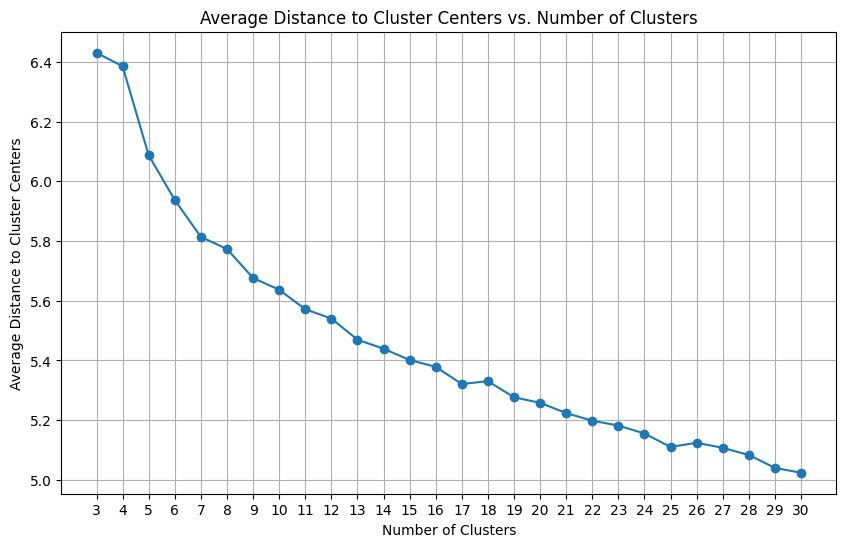

In [19]:
# Investigate the change in within-cluster distance across number of clusters.
# HINT: Use matplotlib's plot function to visualize this relationship.
def n_clusters_distance_relation(cluster_range, average_distances):
    plt.figure(figsize=(10, 6))
    plt.plot(cluster_range, average_distances, marker='o')
    plt.title("Average Distance to Cluster Centers vs. Number of Clusters")
    plt.xlabel("Number of Clusters")
    plt.ylabel("Average Distance to Cluster Centers")
    plt.xticks(cluster_range)
    plt.grid()
    plt.show()

n_clusters_distance_relation(cluster_range, average_distances)

In [20]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.
kmeans = KMeans(n_clusters=7)
model = kmeans.fit(pca_X)
prediction_clusters = model.predict(pca_X)

In [21]:
prediction_clusters

array([4, 2, 0, ..., 2, 3, 6], dtype=int32)

In [22]:
final_cleaned_data['cluster'] = prediction_clusters

In [23]:
final_cleaned_data['cluster'].value_counts()

cluster
0    164912
2    126826
1    116458
6    110601
5    106800
4     96183
3     76015
Name: count, dtype: int64

### Discussion 3.1: Apply Clustering to General Population

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding clustering. Into how many clusters have you decided to segment the population?)

### Answer 3.1:
After doing pca and choosing 27 components, we want to find the best number of clusters for kmeans, so I did a for loop through different number of clusters from 3 to 30 clusters, to find which number is the best for each number of clusters we find the distance between each point and the center then we compute the average distance within cluster, then I plot those average distances per each number of clusters to find the point where the average distance dicrease significantly comparing to the previous step, but in the same time we should stop when the improvements bacame too miner beacause we don't want to increase the number of clusters with no good reason.

Based on the plot, I found that 7 clusters is a good choice because there is a significant decrease in the average distance and after that the decrease bacame so miner. So, I choose to go with 7 clusters and I fit my data and have predicted labels (clusters) after that.

### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [24]:
# Load in the customer demographics data.
customers = pd.read_csv('Udacity_CUSTOMERS_Subset.csv', sep=';')

In [25]:
customers.shape

(191652, 85)

In [26]:
customers.head()

AGER_TYP  ALTERSKATEGORIE_GROB  ANREDE_KZ  CJT_GESAMTTYP  \
0         2                     4          1            5.0   
1        -1                     4          1            NaN   
2        -1                     4          2            2.0   
3         1                     4          1            2.0   
4        -1                     3          1            6.0   

   FINANZ_MINIMALIST  FINANZ_SPARER  FINANZ_VORSORGER  FINANZ_ANLEGER  \
0                  5              1                 5               1   
1                  5              1                 5               1   
2                  5              1                 5               1   
3                  5              1                 5               2   
4                  3              1                 4               4   

   FINANZ_UNAUFFAELLIGER  FINANZ_HAUSBAUER  FINANZTYP  GEBURTSJAHR  \
0                      2                 2          2            0   
1                      3                 2          2            0   
2                      4                 4          2            0   
3                      1                 2          6            0   
4                      5                 2          2         1960   

   GFK_URLAUBERTYP  GREEN_AVANTGARDE  HEALTH_TYP  LP_LEBENSPHASE_FEIN  \
0              4.0                 1           1                 20.0   
1              NaN                 0           1                  NaN   
2              3.0                 1           2                 13.0   
3             10.0                 0           2                  0.0   
4              2.0                 0           3                 31.0   

   LP_LEBENSPHASE_GROB  LP_FAMILIE_FEIN  LP_FAMILIE_GROB  LP_STATUS_FEIN  \
0                  5.0              2.0              2.0            10.0   
1                  NaN              NaN              NaN             NaN   
2                  3.0              1.0              1.0            10.0   
3                  0.0              0.0              0.0             9.0   
4                 10.0             10.0              5.0             1.0   

   LP_STATUS_GROB  NATIONALITAET_KZ  PRAEGENDE_JUGENDJAHRE  RETOURTYP_BK_S  \
0             5.0                 1                      4             5.0   
1             NaN                 1                      0             NaN   
2             5.0                 1                      4             5.0   
3             4.0                 1                      1             3.0   
4             1.0                 1                      8             5.0   

   SEMIO_SOZ  SEMIO_FAM  SEMIO_REL  SEMIO_MAT  SEMIO_VERT  SEMIO_LUST  \
0          6          5          2          6           6           7   
1          3          6          2          6           7           5   
2          2          2          1          3           3           7   
3          6          5          3          4           7           5   
4          4          5          4          6           5           6   

   SEMIO_ERL  SEMIO_KULT  SEMIO_RAT  SEMIO_KRIT  SEMIO_DOM  SEMIO_KAEM  \
0          3           4          1           3          1           1   
1          3           4          1           3          3           2   
2          7           1          2           7          5           6   
3          3           4          3           3          3           3   
4          4           5          5           3          5           2   

   SEMIO_PFLICHT  SEMIO_TRADV  SHOPPER_TYP  SOHO_KZ  TITEL_KZ  VERS_TYP  \
0              2            1            3      0.0       0.0         1   
1              4            1            3      0.0       0.0         1   
2              4            1            1      0.0       0.0         2   
3              3            4            0      0.0       0.0         1   
4              5            4            1      0.0       0.0         2   

   ZABEOTYP  ALTER_HH  ANZ_PERSONEN  ANZ_TITEL  HH_EINKOMMEN_SCO

In [27]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.
#cleaning
customers_cleaned_data = clean_data(customers)
customers_cleaned_data.shape

(141683, 66)

In [28]:
#scaling
customers_scaled_df = scaling(customers_cleaned_data)
customers_scaled_df.shape

(141683, 66)

In [29]:
#pca
customers_pca = pca.transform(customers_scaled_df)
customers_pca.shape

(141683, 27)

In [30]:
#clusters
customers_labels = model.predict(customers_pca)

In [31]:
customers_labels

array([0, 1, 0, ..., 0, 1, 5], dtype=int32)

In [32]:
customers_cleaned_data['cluster'] = customers_labels

In [33]:
customers_cleaned_data['cluster'].value_counts()

cluster
0    80837
6    20583
1    17084
5    13668
2     6353
4     1618
3     1540
Name: count, dtype: int64

### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

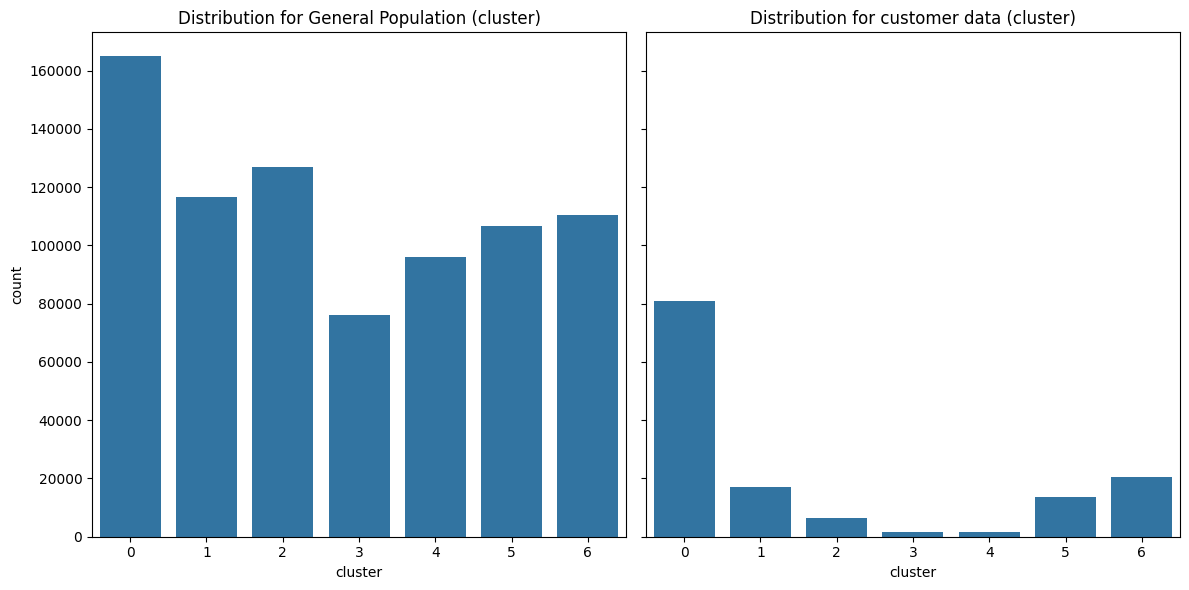

In [34]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.

#compare counts

column_name = 'cluster'
fig, axes = plt.subplots(1, 2, figsize=(12, 6), sharey=True)

sns.countplot(x='cluster', data=final_cleaned_data, ax=axes[0])
axes[0].set_title(f'Distribution for General Population ({column_name})')

sns.countplot(x='cluster', data=customers_cleaned_data, ax=axes[1])
axes[1].set_title(f'Distribution for customer data ({column_name})')

plt.tight_layout()
plt.show()

In [44]:
final_cleaned_data['cluster'].value_counts(normalize=True).sort_index().values

array([0.20670974, 0.14597484, 0.15897066, 0.09528137, 0.12056105,
       0.13386898, 0.13863336])

In [43]:
customers_cleaned_data['cluster'].value_counts(normalize=True).sort_index().values

array([0.57054834, 0.12057904, 0.04483954, 0.01086934, 0.01141986,
       0.09646888, 0.14527502])

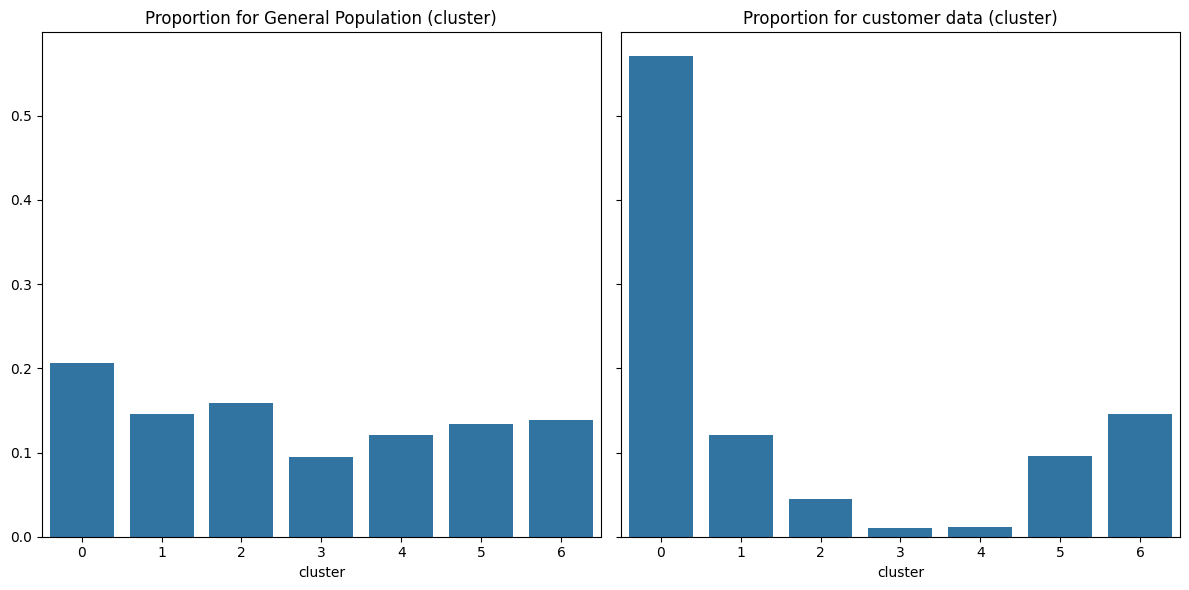

In [46]:
#Compare proportions
column_name = 'cluster'
fig, axes = plt.subplots(1, 2, figsize=(12, 6), sharey=True)

sns.barplot(x=final_cleaned_data['cluster'].value_counts(normalize=True).sort_index().index, 
            y=final_cleaned_data['cluster'].value_counts(normalize=True).sort_index().values,
            ax=axes[0])
axes[0].set_title(f'Proportion for General Population ({column_name})')

sns.barplot(x=customers_cleaned_data['cluster'].value_counts(normalize=True).sort_index().index,
              y=customers_cleaned_data['cluster'].value_counts(normalize=True).sort_index().values,
              ax=axes[1])
axes[1].set_title(f'Proportion for customer data ({column_name})')

plt.tight_layout()
plt.show()

In [53]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?
# Cluster 0
def cluster_characteristic(cluster_num):
    
    cluster_centroid = model.cluster_centers_[cluster_num].reshape(1, -1)
    original_scaled_features = pca.inverse_transform(cluster_centroid)
    original_features = scaler.inverse_transform(original_scaled_features)
    
    feature_names = customers_cleaned_data.drop(['cluster'],axis=1).columns  
    cluster_features = dict(zip(feature_names, original_features.flatten()))
    return cluster_features


cluster_num = 0
print(f"Cluster ({cluster_num}) characteristics:")
for feature, value in cluster_characteristic(cluster_num).items():
    print(f"{feature}: {value:.2f}")


Cluster (0) characteristics:
ALTERSKATEGORIE_GROB: 3.59
ANREDE_KZ: 1.47
FINANZ_MINIMALIST: 4.53
FINANZ_SPARER: 1.21
FINANZ_VORSORGER: 4.65
FINANZ_ANLEGER: 1.79
FINANZ_UNAUFFAELLIGER: 1.67
FINANZ_HAUSBAUER: 2.55
GEBURTSJAHR: 1956.92
GREEN_AVANTGARDE: 0.44
HEALTH_TYP: 1.98
RETOURTYP_BK_S: 3.82
SEMIO_SOZ: 3.88
SEMIO_FAM: 3.36
SEMIO_REL: 2.74
SEMIO_MAT: 2.94
SEMIO_VERT: 4.75
SEMIO_LUST: 5.54
SEMIO_ERL: 5.43
SEMIO_KULT: 3.37
SEMIO_RAT: 2.82
SEMIO_KRIT: 4.43
SEMIO_DOM: 4.20
SEMIO_KAEM: 3.93
SEMIO_PFLICHT: 2.85
SEMIO_TRADV: 2.62
SOHO_KZ: 0.01
VERS_TYP: 1.47
ALTER_HH: 13.51
ANZ_PERSONEN: 1.93
ANZ_TITEL: 0.01
HH_EINKOMMEN_SCORE: 3.16
W_KEIT_KIND_HH: 4.62
WOHNDAUER_2008: 8.54
ANZ_HAUSHALTE_AKTIV: 1.86
ANZ_HH_TITEL: 0.01
KONSUMNAEHE: 3.83
MIN_GEBAEUDEJAHR: 1993.29
OST_WEST_KZ: 0.16
KBA05_ANTG1: 2.71
KBA05_ANTG2: 0.99
KBA05_ANTG3: 0.07
KBA05_ANTG4: 0.02
KBA05_GBZ: 4.19
BALLRAUM: 4.84
EWDICHTE: 3.01
INNENSTADT: 5.44
GEBAEUDETYP_RASTER: 4.07
KKK: 2.57
MOBI_REGIO: 4.22
ONLINE_AFFINITAET: 2.63
REGIOTY

### Cluster 0 : 
elderly, money-saver, investor, home ownership, conservative Low-Returner, dutiful and tradional-minded, the age of head of household 1955 to 1960, average to unlikely children, length of residence 7-10 years, average distance to nearest urban center, far from city center, average purchase power, very low movement, middle online use, middle size community, decade 60's, Prosperous Households

In [54]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?
#Cluster 2
cluster_num = 2
print(f"Cluster ({cluster_num}) characteristics:")
for feature, value in cluster_characteristic(cluster_num).items():
    print(f"{feature}: {value:.2f}")

Cluster (2) characteristics:
ALTERSKATEGORIE_GROB: 2.31
ANREDE_KZ: 1.97
FINANZ_MINIMALIST: 2.83
FINANZ_SPARER: 3.46
FINANZ_VORSORGER: 2.64
FINANZ_ANLEGER: 4.04
FINANZ_UNAUFFAELLIGER: 3.49
FINANZ_HAUSBAUER: 2.45
GEBURTSJAHR: 1974.14
GREEN_AVANTGARDE: 0.25
HEALTH_TYP: 2.32
RETOURTYP_BK_S: 2.76
SEMIO_SOZ: 2.78
SEMIO_FAM: 3.12
SEMIO_REL: 4.12
SEMIO_MAT: 4.03
SEMIO_VERT: 2.72
SEMIO_LUST: 3.49
SEMIO_ERL: 5.06
SEMIO_KULT: 3.33
SEMIO_RAT: 5.22
SEMIO_KRIT: 5.60
SEMIO_DOM: 5.95
SEMIO_KAEM: 5.65
SEMIO_PFLICHT: 5.01
SEMIO_TRADV: 4.59
SOHO_KZ: 0.01
VERS_TYP: 1.37
ALTER_HH: 17.14
ANZ_PERSONEN: 2.07
ANZ_TITEL: 0.00
HH_EINKOMMEN_SCORE: 3.73
W_KEIT_KIND_HH: 3.08
WOHNDAUER_2008: 7.74
ANZ_HAUSHALTE_AKTIV: 2.73
ANZ_HH_TITEL: 0.01
KONSUMNAEHE: 3.80
MIN_GEBAEUDEJAHR: 1994.41
OST_WEST_KZ: 0.15
KBA05_ANTG1: 2.31
KBA05_ANTG2: 1.27
KBA05_ANTG3: 0.22
KBA05_ANTG4: 0.06
KBA05_GBZ: 3.94
BALLRAUM: 5.02
EWDICHTE: 2.89
INNENSTADT: 5.54
GEBAEUDETYP_RASTER: 4.03
KKK: 2.64
MOBI_REGIO: 3.88
ONLINE_AFFINITAET: 3.54
REGIOTY

### Cluster 2:
middle age, not money-severs, not investors, have home ownership, incentive-receptive Normal-Returner, socially-minded, dreamful, the age of head of household 1975 to 1980, likely have children, length of residence 6-7 years, far from nearest urban center, middle distance to downtown, average to high purchase power, low movement, high to very high online users, low community size, decade 80's, Prosperous Households

In [55]:
#Cluster 4
cluster_num = 4
print(f"Cluster ({cluster_num}) characteristics:")
for feature, value in cluster_characteristic(cluster_num).items():
    print(f"{feature}: {value:.2f}")

Cluster (4) characteristics:
ALTERSKATEGORIE_GROB: 1.72
ANREDE_KZ: 2.01
FINANZ_MINIMALIST: 1.18
FINANZ_SPARER: 4.27
FINANZ_VORSORGER: 2.23
FINANZ_ANLEGER: 4.17
FINANZ_UNAUFFAELLIGER: 3.73
FINANZ_HAUSBAUER: 4.19
GEBURTSJAHR: 1976.22
GREEN_AVANTGARDE: 0.05
HEALTH_TYP: 2.21
RETOURTYP_BK_S: 2.66
SEMIO_SOZ: 3.30
SEMIO_FAM: 3.93
SEMIO_REL: 5.32
SEMIO_MAT: 4.96
SEMIO_VERT: 2.25
SEMIO_LUST: 3.18
SEMIO_ERL: 4.38
SEMIO_KULT: 4.07
SEMIO_RAT: 6.09
SEMIO_KRIT: 5.56
SEMIO_DOM: 6.12
SEMIO_KAEM: 6.10
SEMIO_PFLICHT: 6.16
SEMIO_TRADV: 5.47
SOHO_KZ: 0.01
VERS_TYP: 1.47
ALTER_HH: 16.75
ANZ_PERSONEN: 1.52
ANZ_TITEL: 0.00
HH_EINKOMMEN_SCORE: 5.58
W_KEIT_KIND_HH: 4.00
WOHNDAUER_2008: 7.31
ANZ_HAUSHALTE_AKTIV: 14.23
ANZ_HH_TITEL: 0.05
KONSUMNAEHE: 2.17
MIN_GEBAEUDEJAHR: 1992.55
OST_WEST_KZ: 0.25
KBA05_ANTG1: 0.50
KBA05_ANTG2: 1.33
KBA05_ANTG3: 1.11
KBA05_ANTG4: 0.58
KBA05_GBZ: 2.27
BALLRAUM: 3.27
EWDICHTE: 5.06
INNENSTADT: 3.48
GEBAEUDETYP_RASTER: 3.42
KKK: 2.87
MOBI_REGIO: 1.88
ONLINE_AFFINITAET: 2.94
REGIOT

### Cluster 4:
youth, low money saving, low investment, don't have home ownership, dreamful, the age of head of household 1970 to 1975, may have chidren, length of residence 6-7 years, not so far from a urban center, close to downtown, average to high purchase power, high to very high movement, middle to high online users, average community size, decade middle 80's, Less Affluent Households

### Discussion 3.3: Compare Customer Data to Demographics Data

(Double-click this cell and replace this text with your own text, reporting findings and conclusions from the clustering analysis. Can we describe segments of the population that are relatively popular with the mail-order company, or relatively unpopular with the company?)

### Answer 3.3:
As we see from the main characteristics of the above clusters, I think that the segment from population that could be relatively popular with the mail-order company is cluster 0 which has this describtion : 

elderly, money-saver, investor, home ownership, conservative Low-Returner, dutiful and tradional-minded, the age of head of household 1955 to 1960, average to unlikely children, length of residence 7-10 years, average distance to nearest urban center, far from city center, average purchase power, very low movement, middle online use, middle size community, decade 60's, Prosperous Households

On the other hand, the segments which are relatively unpopular with the company are 2,3 and 4 and here is the description of 2 of them :

cluster2: middle age, not money-severs, not investors, have home ownership, incentive-receptive Normal-Returner, socially-minded, dreamful, the age of head of household 1975 to 1980, likely have children, length of residence 6-7 years, far from nearest urban center, middle distance to downtown, average to high purchase power, low movement, high to very high online users, low community size, decade 80's, Prosperous Households

cluster 4: youth, low money saving, low investment, don't have home ownership, dreamful, the age of head of household 1970 to 1975, may have chidren, length of residence 6-7 years, not so far from a urban center, close to downtown, average to high purchase power, high to very high movement, middle to high online users, average community size, decade middle 80's, Less Affluent Households

> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.